<h2>Store 3266 OGP Associate Metric Analysis 12/20/2024 - 4/24/2025</h2>
<p>Saturday is set as start of a new week</p>
<p>Accounts for old style format from O.G. Report 3.0 and new style from new dashboard. Trains on market 178 data starting 3/17/2025.</p>

In [3859]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install xgboost
!pip install lightgbm
!pip install tensorflow-macos
!pip install tensorflow-metal
!pip install keras-tuner
!pip install psutil


In [3860]:
import warnings
warnings.filterwarnings("ignore", message=".*XGBoost is not compiled with CUDA support.*")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import seaborn as sns
from datetime import datetime, timedelta, date 
import glob
import os
import time
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb
import platform

notebook_start_time = time.time()
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
print(f"Is CUDA available? {torch.cuda.is_available()}")

# Check if MPS is available
print("Is MPS available?", torch.backends.mps.is_available())

# Check if MPS is built into your PyTorch installation
print("Is MPS built?", torch.backends.mps.is_built())

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
#prevents text wrapping from output
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 2000)        # Set a wide display width
pd.set_option('display.max_colwidth', None) # Show full content in each cell

Is CUDA available? False
Is MPS available? True
Is MPS built? True
mps
tensor([1.], device='mps:0')


In [3861]:
print(f'Platform: {platform.platform()}')
print(f'Platform processor: {platform.processor()}')
def cpu_info(): 
    if platform.system() == 'Windows': 
        return platform.processor() 
    elif platform.system() == 'Darwin': 
        command = '/usr/sbin/sysctl -n machdep.cpu.brand_string' 
        return os.popen(command).read().strip() 
    elif platform.system() == 'Linux': 
        command = 'cat /proc/cpuinfo' 
        return os.popen(command).read().strip() 
    return 'platform not identified' 
 
print(cpu_info()) 

Platform: macOS-26.2-arm64-arm-64bit
Platform processor: arm
Apple M4 Max
Apple M4 Max


In [3862]:
print(xgb.__version__)  # Ensure it shows the version with GPU support

from xgboost import XGBRegressor
model = XGBRegressor(tree_method="gpu_hist")
print(model.get_params())  # Check if tree_method is set to gpu_hist


2.1.3
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None}


<h1>Select Store</h1>

In [3863]:
selected_store = 3266


In [3864]:
def drop_embedded_headers(df):
    first_col = df.columns[0]
    header_str = ",".join(df.columns.astype(str))
    # Drop rows where first column == the entire header string
    df = df[df[first_col].astype(str) != header_str]
    # Drop rows where first column is literally the column name itself (e.g., "Store #")
    df = df[df[first_col].astype(str) != first_col]
    return df


In [3865]:
file = "Data/ByAssociateView_12-20-2024_1-19-2025.csv"
file2 = "Data/ByAssociateView_1-20-2025_1-22-2025.csv"
files = [file, file2]
'''with open(file, "rb") as file:
        result = chardet.detect(file_name.read(10000))
        print(f"File: {file_name}")
        print(f"Detected Encoding: {result['encoding']}, Confidence: {result['confidence']}\n")'''
#df = pd.read_csv(file, encoding="utf-16", sep="\t", engine="python")
#df2 = pd.read_csv(file2, encoding="utf-16", sep="\t", engine="python")
'''
test = False #flag for text files to csv 
delim_same = False #flag for same delimiter across files
market = False
# Specify the directory where your CSV files are located
csv_dir = "Data/"  # Update this to your folder path
if test == True:
    csv_dir = "Data/TestTextInput/"  # Update this to your folder path
if market == True:
    csv_dir = "Data/MarketData/"  # Update this to your folder path
# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(csv_dir, "ByAssociateView_*.csv"))
# Create an empty list to store DataFrames
dataframes = []
# Loop through each file, read it into a DataFrame, and append it to the list
# Process each file
for file_path in csv_files:
    print(f"File being processed: {file_path}") 
    # Detect encoding
    with open(file_path, "rb") as f:
        result = chardet.detect(f.read(10000))   
    encoding = result['encoding']
    print(f"Detected Encoding: {encoding}, Confidence: {result['confidence']}\n")   
    # Read the file into a DataFrame
    if test == True and delim_same == False:
        print("test == True and delim_same == False")
        try:
            df = pd.read_csv(file_path, encoding=encoding, engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    if test == True and delim_same == True:
        print("test == True and delim_same == True")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    if market == True:
        print("market == True")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    else:
        print("test == False")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

if len(dataframes) > 0:
    dataframes[0].head()
    # Combine the DataFrames row-wise
    combined_df = pd.concat(dataframes, ignore_index=True)
    #print(combined_df)
    print(f'df shape: {df.shape}\ncombined_df shape: {combined_df.shape}')
    df = combined_df
    #if 'Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,SFS Pack Hours,SFS Packed Qty,SFS Pack Rate' in df.columns:
    #    df = df.drop('Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,SFS Pack Hours,SFS Packed Qty,SFS Pack Rate', axis=1)

    df = drop_embedded_headers(df)
    if "Associate ID" in df.columns:
        df = df.sort_values(by=["Associate ID", "Day of Pick Date"], ascending=[True,False])
    elif "Associate" in df.columns:
        df = df.sort_values(by=["Associate", "Day of Pick Date"], ascending=[True,False])
    else:
        print("No 'Associate ID' or 'Associate' column found for sorting.")
    #df.drop_duplicates(subset=["Associate ID", "Day of Pick Date"], keep='first', inplace=True)
    df.reset_index(drop=True)
    print(f'Columns in df: {df.columns.unique()}')
    print(f'Before dropping duplicates: {df.shape}')
    df_unique = df.drop_duplicates()
    print(f'After dropping duplicates: {df_unique.shape}')
    df = df_unique
else:
    print("No DataFrames to combine.")

'''

'\ntest = False #flag for text files to csv \ndelim_same = False #flag for same delimiter across files\nmarket = False\n# Specify the directory where your CSV files are located\ncsv_dir = "Data/"  # Update this to your folder path\nif test == True:\n    csv_dir = "Data/TestTextInput/"  # Update this to your folder path\nif market == True:\n    csv_dir = "Data/MarketData/"  # Update this to your folder path\n# Use glob to get a list of all CSV files in the directory\ncsv_files = glob.glob(os.path.join(csv_dir, "ByAssociateView_*.csv"))\n# Create an empty list to store DataFrames\ndataframes = []\n# Loop through each file, read it into a DataFrame, and append it to the list\n# Process each file\nfor file_path in csv_files:\n    print(f"File being processed: {file_path}") \n    # Detect encoding\n    with open(file_path, "rb") as f:\n        result = chardet.detect(f.read(10000))   \n    encoding = result[\'encoding\']\n    print(f"Detected Encoding: {encoding}, Confidence: {result[\'conf

<h1>Import all data used from ByAssociateView (handles old format pre-March 2025)</h1>

In [3866]:
import pandas as pd
import chardet
import os
import glob
import csv

# Flags
test = False        # flag for text files to csv
delim_same = False  # flag for same delimiter across files
market = False      # flag for market data

# Directory of CSV files
csv_dir = "Data/"
if test:
    csv_dir = "Data/TestTextInput/"
if market:
    csv_dir = "Data/MarketData/"

# Get list of CSV files
csv_files = glob.glob(os.path.join(csv_dir, "ByAssociateView_*.csv"))

# Create a list to store DataFrames
dataframes = []

for file_path in csv_files:
    print(f"File being processed: {file_path}")

    # Detect encoding
    with open(file_path, "rb") as f:
        raw_data = f.read(10000)
        result = chardet.detect(raw_data)
    encoding = result['encoding']
    print(f"Detected Encoding: {encoding}, Confidence: {result['confidence']}")

    # Read first few lines to detect delimiter
    try:
        with open(file_path, 'r', encoding=encoding) as f:
            sample = f.read(2048)  # read a sample for delimiter detection
        if test and not delim_same:
            print("test == True and delim_same == False")
            df = pd.read_csv(file_path, encoding=encoding, engine="python")
        elif test and delim_same:
            print("test == True and delim_same == True")
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
        elif market:
            print("market == True")
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
        else:
            # Detect delimiter using csv.Sniffer
            try:
                dialect = csv.Sniffer().sniff(sample, delimiters=[",", "\t", ";", "|"])
                delimiter = dialect.delimiter
                print(f"Detected delimiter: '{delimiter}'")
            except csv.Error:
                delimiter = ","  # fallback
                print("Could not detect delimiter, defaulting to comma.")
            df = pd.read_csv(file_path, encoding=encoding, sep=delimiter, engine="python")
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
    print('\n')

# Combine all DataFrames
if len(dataframes) > 0:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"Combined df shape: {combined_df.shape}")

    # 🔹 Clean header columns
    for col in combined_df.columns:
        if "," in col and len(col.split(",")) > 3:
            print(f"Dropping embedded header column: {col}")
            combined_df = combined_df.drop(columns=[col])

    # Sort if associate columns exist
    if "Associate ID" in combined_df.columns:
        combined_df = combined_df.sort_values(by=["Associate ID", "Day of Pick Date"], ascending=[True, False])
    elif "Associate" in combined_df.columns:
        combined_df = combined_df.sort_values(by=["Associate", "Day of Pick Date"], ascending=[True, False])
    else:
        print("No 'Associate ID' or 'Associate' column found for sorting.")

    # Reset index and drop duplicates
    combined_df.reset_index(drop=True, inplace=True)
    print(f'Columns in df: {combined_df.columns.unique()}')
    print(f'Before dropping duplicates: {combined_df.shape}')
    combined_df = combined_df.drop_duplicates()
    print(f'After dropping duplicates: {combined_df.shape}')

    # Final DataFrame
    df = combined_df
    df['Associate'] = df['Associate'].str.upper().str.strip()
else:
    print("No DataFrames to combine.")

df = drop_embedded_headers(df)

File being processed: Data/ByAssociateView_10-12-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being processed: Data/ByAssociateView_6-20-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being processed: Data/ByAssociateView_3-25_3-26-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being processed: Data/ByAssociateView_8-16-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being processed: Data/ByAssociateView_7-4-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being processed: Data/ByAssociateView_11-5_11-6-2025_market178.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being processed: Data/ByAssociateView_7-8_7-9-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being processed: Data/ByAssociateView_9-

<h1>Import all Associate By Day files to get Associate and Associate ID pairs (Starts 9/20/2025)</h1>

In [3867]:
import pandas as pd
import chardet
import os
import glob
import csv

# Flags
test = False        # flag for text files to csv
delim_same = False  # flag for same delimiter across files
market = False      # flag for market data

# Directory of CSV files
csv_dir = "Data/"
if test:
    csv_dir = "Data/TestTextInput/"
if market:
    csv_dir = "Data/MarketData/"

# Get list of CSV files
csv_files = glob.glob(os.path.join(csv_dir, "AssociateByDay_*.csv"))

# Create a list to store DataFrames
dataframes = []

for file_path in csv_files:
    print(f"File being processed: {file_path}")

    # Detect encoding
    with open(file_path, "rb") as f:
        raw_data = f.read(10000)
        result = chardet.detect(raw_data)
    encoding = result['encoding']
    print(f"Detected Encoding: {encoding}, Confidence: {result['confidence']}")

    # Read first few lines to detect delimiter
    try:
        with open(file_path, 'r', encoding=encoding) as f:
            sample = f.read(2048)  # read a sample for delimiter detection
        if test and not delim_same:
            print("test == True and delim_same == False")
            df_by_view = pd.read_csv(file_path, encoding=encoding, engine="python")
        elif test and delim_same:
            print("test == True and delim_same == True")
            df_by_view = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
        elif market:
            print("market == True")
            df_by_view = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
        else:
            # Detect delimiter using csv.Sniffer
            try:
                dialect = csv.Sniffer().sniff(sample, delimiters=[",", "\t", ";", "|"])
                delimiter = dialect.delimiter
                print(f"Detected delimiter: '{delimiter}'")
            except csv.Error:
                delimiter = ","  # fallback
                print("Could not detect delimiter, defaulting to comma.")
            df_by_view = pd.read_csv(file_path, encoding=encoding, sep=delimiter, engine="python")
        dataframes.append(df_by_view)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
    print('\n')

# Combine all DataFrames
if len(dataframes) > 0:
    combined_df_by_view = pd.concat(dataframes, ignore_index=True)
    print(f"Combined df shape: {combined_df_by_view.shape}")

    # 🔹 Clean header columns
    for col in combined_df_by_view.columns:
        if "," in col and len(col.split(",")) > 3:
            print(f"Dropping embedded header column: {col}")
            combined_df_by_view = combined_df_by_view.drop(columns=[col])

    # Sort if associate columns exist
    if "Associate ID" in combined_df_by_view.columns:
        combined_df_by_view = combined_df_by_view.sort_values(by=["Associate ID", "Pick Date"], ascending=[True, False])
    elif "Associate" in combined_df.columns:
        combined_df_by_view = combined_df_by_view.sort_values(by=["Associate", "Pick Date"], ascending=[True, False])
    else:
        print("No 'Associate ID' or 'Associate' column found for sorting.")

    # Reset index and drop duplicates
    combined_df_by_view.reset_index(drop=True, inplace=True)
    print(f'Columns in df: {combined_df_by_view.columns.unique()}')
    print(f'Before dropping duplicates: {combined_df_by_view.shape}')
    combined_df_by_view.dropna(subset=['Associate ID'], inplace=True)
    combined_df_by_view = combined_df_by_view.drop_duplicates()
    print(f'After dropping duplicates: {combined_df_by_view.shape}')

    # Final DataFrame
    df_by_view = combined_df_by_view
    df_by_view['Associate'] = df_by_view['Associate'].str.upper().str.strip()
else:
    print("No DataFrames to combine.")
df_by_view = drop_embedded_headers(df_by_view)
df_by_view['Store #'] = pd.to_numeric(df_by_view['Store #'], errors='coerce')
print(f'Unique Associate IDs: {df_by_view["Associate ID"].nunique()}')


File being processed: Data/AssociateByDay_11-3_11-5-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being processed: Data/AssociateByDay_10-18-2025_HAS-USER-IDS_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being processed: Data/AssociateByDay_11-25-2025_market178.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being processed: Data/AssociateByDay_10-24-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being processed: Data/AssociateByDay_9-2-_10-19-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being processed: Data/AssociateByDay_11-17_11-10-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being processed: Data/AssociateByDay__11-12_11-16-2025_MARKET178.csv
Detected Encoding: UTF-16, Confidence: 1.0
Detected delimiter: '	'


File being pr

In [3868]:
df['Store #'] = pd.to_numeric(df['Store #'], errors='coerce').fillna(0).astype(int)
if selected_store not in df['Store #'].unique():
    print(f"Store {selected_store} not found in the dataset.")
    selected_store = 3266
stores = df['Store #'].unique()
print(f"Stores: {stores}")
store_market = {}
for store in stores:
    store_market[store] = 178
df['Market'] = df['Store #'].map(store_market)
#df.head()

Stores: [3266 1844 1921 1977 2195 2518 3236 3830 5012 5142 5414]


In [3869]:
#df.sample(50)

In [3870]:
def convert_weekday_number_to_day(date):
    switch = {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday"
    }
    return switch.get(date.weekday(), "Invalid weekday number")

In [3871]:
# Remove rows where "Day of Pick Date" is "Total"
df = df.loc[df["Day of Pick Date"] != "Total"]  # market data starting from 3/17/2025

# Convert to datetime once for efficiency
df["Day of Pick Date"] = pd.to_datetime(df["Day of Pick Date"], errors="coerce")

# Extract Month and Year
df["Month"] = df["Day of Pick Date"].dt.month
df["Year"] = df["Day of Pick Date"].dt.year

# If needed, you can drop rows where conversion failed (invalid dates):
df = df.dropna(subset=["Day of Pick Date"])


In [3872]:
'''df = df.drop(df.columns[15], axis=1)
df = df.drop(df.columns[14], axis=1)
df = df.drop(df.columns[14], axis=1)
df = df.drop(df.columns[0], axis=1)
#df = df.set_index("Associate ID")'''

if 'SFS Pack Hours' in df.columns and 'SFS Packed Qty' in df.columns and 'SFS Pack Rate' in df.columns:
    df = df.drop(['SFS Pack Hours', 'SFS Packed Qty', 'SFS Pack Rate'], axis=1)
df = df.dropna(subset=['Store #'])
df['Store #'] = df['Store #'].astype(int)

In [3873]:
df.head()
df.loc[df['Store #'] == 1977, :].head()

Store #        Associate Day of Pick Date     FTPR FTP Expected FTP Actual Pick Rate Pick Hours Picked As Req Qty Substitution Qty  Ovrd Qty Nil Pick Qty Exception Qty Req to Pick Exception Picked As Req Qty Exception Substitution Qty Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty Qty Req to Pick Associate ID  Market  Month  Year
56894     1977      AKILA RABBI       2025-09-09  100.00%            4          4     38.10       0.11                 4                0      0.00            0                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178      9  2025
56895     1977  ANDREW SCHWARTZ       2025-09-09   87.60%          258        226     98.70       2.41               228               10      0.00           15                       107                          40                         11                     47                  NaN                 NaN             NaN          NaN     178      9  2025
56896     1977   ANGELI CAMACHO       2025-09-09   76.19%           21         16     44.70       0.38                17                0      0.00            1                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178      9  2025
56897     1977     BRENDA LEYVA       2025-09-09   87.97%          557        490    122.20       4.35               493               38      0.00           52                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178      9  2025
56898     1977    BRITTANI RUSH       2025-09-09      NaN            0          0       NaN       0.00                 0                0      0.00            0                        11                           0                          0                     11                  NaN                 NaN             NaN          NaN     178      9  2025

In [3874]:
ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
ids_to_drop = ["csp", "Total"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica Amegavluie',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Matthew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chetna Patel', 'k0b09gt' : 'KENNY BUSTAMANTE',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total',
    's0z06gj' : 'Sohrab Zarghanishiraz', 'f0w03c8': 'Fallon Wilcox', 'n0m0hav': 'Noah Mea',
    'cmo0039' : 'Carmen Olivera', 'occ0006' : 'Olga Caldas', 'a0a12k2' : 'Ana Alcantara Bonilla', 'a0y046n' : 'Andy Yunga',
    'b0p0cus' : 'Binalben Patel', 'c0l0p7g' : 'Chaojian Lawrence', 'g0k00w0' : 'Gurdip Kaur', 'h0w03bd' : 'Hla Win',
    'm0c08ob' : 'Maria Campos', 'mdcapan' : 'Maria Capano', 'm0i01db' : 'Maria Ixcopal', 'm0g0r9c' : 'Marina Garcia',
    'p0k010w' : 'Paramjit Kaur', 'p0p0136' : 'Parul Patel', 'r0j07ef' : 'Renu Juneja', 'sps0025' : 'Scott Suarez',
    's0d0j6p' : 'Sharonda Daniels', 's0m160e' : 'Shagelly Melgar', 'r0r0k5w' : 'Ryaan Rafi', 'a0s1maf' : 'Aidan Tobia',
    'a0r16c4' : 'Amaan Rafi', 'b0l01lp' : 'Bryan Lisboa Adames', 'mtslabo' : 'Martin Slaboda', 'djthras' : 'David Thrasher',
    'm0m0prn' : 'Michael Weiss', 'n0m05hq' : 'Nitin More', 'd0h0u6h' : 'Dipshikha Hazra', 'mmp00af' : 'Madhusudan Patel',
    't0c0n5t' : 'Tatiana Charles', 'h0u00fb' : 'Humna Usman', 'e0c0lkv' : 'Edwin Charles', 'nsm' : 'nsm'

}
# Make sure these columns exist
if "Associate ID" in df_by_view.columns and "Associate" in df_by_view.columns:

    # Loop through unique rows to avoid duplicates
    for _, row in df_by_view[["Associate ID", "Associate"]].dropna().drop_duplicates().iterrows():
        assoc_id = str(row["Associate ID"]).strip()
        assoc_name = str(row["Associate"]).strip().upper()

        # Add only if ID not already in dictionary and name is valid
        if assoc_id not in names_to_ids and assoc_id != "" and assoc_name != "":
            names_to_ids[assoc_id] = assoc_name

    print("Dictionary updated successfully.")
    
else:
    print("Columns 'Associate ID' or 'Associate' not found in df_by_view.")

if "Associate ID" not in df.columns:
    # If Associate ID is missing but Associate Name exists, fill ID using the reverse of names_to_ids
    df['Associate ID'] = None

Dictionary updated successfully.


In [3875]:
use_first = False

In [3876]:
if use_first:
    ids_to_names = {v.upper(): k for k, v in names_to_ids.items()}
    names_to_ids = {v: k for k, v in ids_to_names.items()}  # lowercase keys

    # IDs to exclude if needed
    ids_to_drop = {"csp", "total", "nsm"}
    ids_to_drop = {"csp", "total"}

    # Separate 3266 and other stores
    df_selected_store = df[df['Store #'] == 3266].copy()
    df_other = df[df['Store #'] != 3266].copy()

    # Ensure Associate ID column exists
    if "Associate ID" not in df_selected_store.columns:
        df_selected_store["Associate ID"] = None

    # Fill missing Associate IDs for 3266
    df["Associate ID"] = df.apply(
        lambda row: ids_to_names.get(str(row.get("Associate", "")).upper().strip(), row["Associate ID"])
        if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
        axis=1
    )

    # Remove dropped IDs from 3266
    df = df[~df["Associate ID"].str.lower().isin(ids_to_drop)]

    # Add readable names
    df["Associate Name"] = df["Associate ID"].map(names_to_ids).fillna("NA")

    # Remove old Associate column from 3266
    df.drop(columns=["Associate"], inplace=True, errors="ignore")

    # Reorder 3266 columns
    for col in ["Associate ID", "Associate Name"]:
        vals = df[col]
        df.drop(columns=[col], inplace=True)
        df.insert(0 if col == "Associate ID" else 1, col, vals)

    # Combine 3266 and other stores back together
    #df = pd.concat([df_selected_store, df_other], ignore_index=True)

    # Optional: Combine names cleanly into `Associate` if needed
    def merge_names(row):
        name = row.get("Associate Name", "")
        original = row.get("Associate", "")

        if pd.isna(name) or name == "NA":
            return original
        elif pd.isna(original) or name.strip().lower() == original.strip().lower():
            return name
        else:
            return f"{name} ({original})"

    if "Associate Name" in df.columns:
        df["Associate"] = df.apply(merge_names, axis=1)
    else:
        df["Associate"] = df["Associate"]

    if "Associate Name" in df.columns:
        df["Associate"] = df.apply(
            lambda row: row["Associate Name"]
            if pd.notna(row["Associate Name"]) and row["Associate Name"] != "NA"
            else row["Associate"],
            axis=1
        )
        df.drop(columns=["Associate Name"], inplace=True, errors="ignore")

    #df = df[df['Associate'] != 'nsm'] #nsm sometimes accounts for picks from associates. shows nsm as shopper
    df = df[df['Associate'] != 'csp']
    df = df[df['Associate'] != 'Total']
 
    # Final cleanup
    #f.dropna(subset=['Associate', 'Associate ID], inplace=True) #keep rows without Associate ID, dataset for market IDs starts 9/20/2025
    df['Store #'] = df['Store #'].astype(int)
    print("Stores after filtering:", df["Store #"].unique())
    print(df[df['Store #'] == selected_store][['Associate ID', 'Associate']].drop_duplicates())

    

In [3877]:
from collections import defaultdict

# IDs to drop
ids_to_drop = {"csp", "Total", "nsm"}
ids_to_drop = {"csp", "Total"}

# Build a mapping from existing dictionary
# Allows multiple names per ID
id_to_names = defaultdict(set)
for assoc_id, assoc_name in names_to_ids.items():
    if assoc_id.lower() not in ids_to_drop:
        id_to_names[assoc_id].add(assoc_name)

# Update mapping from combined_df_by_view
if "Associate ID" in combined_df_by_view.columns and "Associate" in combined_df_by_view.columns:
    for _, row in combined_df_by_view[["Associate ID", "Associate"]].dropna().drop_duplicates().iterrows():
        assoc_id = str(row["Associate ID"]).strip()
        assoc_name = str(row["Associate"]).strip().upper()
        if assoc_id and assoc_name and assoc_id.lower() not in ids_to_drop:
            id_to_names[assoc_id].add(assoc_name)
else:
    print("Columns 'Associate ID' or 'Associate' not found in combined_df_by_view.")

# Update mapping from df_by_view
if "Associate ID" in df_by_view.columns and "Associate" in df_by_view.columns:
    for _, row in df_by_view[["Associate ID", "Associate"]].dropna().drop_duplicates().iterrows():
        assoc_id = str(row["Associate ID"]).strip()
        assoc_name = str(row["Associate"]).strip().upper()
        if assoc_id and assoc_name and assoc_id.lower() not in ids_to_drop:
            id_to_names[assoc_id].add(assoc_name)
else:
    print("Columns 'Associate ID' or 'Associate' not found in df_by_view.")

# Ensure df has 'Associate ID' column
if "Associate ID" not in df.columns:
    df["Associate ID"] = None

# Build reverse mapping: name (lowercase) -> set of IDs
name_to_ids = defaultdict(set)
for assoc_id, names in id_to_names.items():
    for name in names:
        name_to_ids[name.lower()].add(assoc_id)

# Fill missing Associate IDs in df using name_to_ids
def resolve_id(row):
    if pd.isna(row.get("Associate ID")) or row["Associate ID"] is None:
        name_lower = str(row.get("Associate", "")).strip().lower()
        if name_lower in name_to_ids and name_to_ids[name_lower]:
            # Pick first ID in set
            return list(name_to_ids[name_lower])[0]
    return row.get("Associate ID")

df["Associate ID"] = df.apply(resolve_id, axis=1)

# Fill Associate column using the first name in id_to_names
def resolve_name(row):
    assoc_id = str(row.get("Associate ID", "")).strip()
    if assoc_id in id_to_names and id_to_names[assoc_id]:
        # Pick first name (or you can implement logic to pick latest/frequent)
        return list(id_to_names[assoc_id])[0]
    return row.get("Associate", "")

df["Associate"] = df.apply(resolve_name, axis=1)

# Remove unwanted IDs or placeholder names
df = df[~df["Associate ID"].astype(str).str.lower().isin(ids_to_drop)]
df = df[~df["Associate"].str.lower().isin(["csp", "total"])]
df.dropna(subset=["Associate"], inplace=True)

# Ensure Store # is integer
df["Store #"] = df["Store #"].astype(int)
df['Associate'] = df['Associate'].str.strip()
df['Associate'] = df['Associate'].str.upper()
df.loc[df['Associate'] == 'NSM', 'Associate'] = 'nsm'
df.loc[df['Associate'].str.lower() == 'nsm', 'Associate ID'] = 'nsm'

# Output for current store
print("Stores after filtering:", df["Store #"].unique())
print(df[df['Store #'] == selected_store][['Associate ID', 'Associate']].drop_duplicates())
df_associate_associateid = df[df['Store #'] == selected_store][['Associate ID', 'Associate']].drop_duplicates()
for _, row in df_associate_associateid.iterrows():
    print(f"ID: {row['Associate ID']}, Name: {row['Associate']}")


Stores after filtering: [3266 1844 1921 1977 2195 2518 3236 3830 5012 5142 5414]
       Associate ID        Associate
24          a0b0ad9    ANGELA BAIORI
56          a0c02mv   AURORA COMPRES
76          a0f0grp  ANDREA FIGUEROA
108         a0p0fc6     ANDREW PLAZA
136         a0s1jgx  ARPANA SILUMALA
...             ...              ...
120477      w0r03z8       WAYNE RAAB
124597      d0r0qlv     DEMARIO REED
132800      a0r1bx8        AARTI ROY
133368      h0u00fb      HUMNA USMAN
137955      m0a09xk    MOHAMED ARAFA

[84 rows x 2 columns]
ID: a0b0ad9, Name: ANGELA BAIORI
ID: a0c02mv, Name: AURORA COMPRES
ID: a0f0grp, Name: ANDREA FIGUEROA
ID: a0p0fc6, Name: ANDREW PLAZA
ID: a0s1jgx, Name: ARPANA SILUMALA
ID: azi0001, Name: AMMAD IQBAL
ID: c0c116s, Name: CHRISTINA CUCITRO
ID: c0p07a7, Name: CHETNA PATEL
ID: c0r0k4h, Name: CIANA RIPA
ID: d0c0as3, Name: DANIELLE CASIANO
ID: d0r0khi, Name: DANIEL RUSSO
ID: dapanal, Name: DANILO PANALES
ID: e0e04sh, Name: ERIK ENRIQUEZ
ID: e0m0abw, Name:

In [3878]:
df.sample(50)

Store #              Associate Day of Pick Date     FTPR FTP Expected FTP Actual Pick Rate Pick Hours Picked As Req Qty Substitution Qty  Ovrd Qty Nil Pick Qty Exception Qty Req to Pick Exception Picked As Req Qty Exception Substitution Qty Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty Qty Req to Pick Associate ID  Market  Month  Year
110567     5414        EMILY PESSOLANO       2025-04-13   98.72%           78         77    186.20       0.42                77                1      0.00            0                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178      4  2025
67540      3236       JESSICA CUATLATL       2025-09-13   98.15%           54         53    108.60       0.50                53                1      0.00            0                         0                           0                          0                      0                  NaN                 NaN             NaN      j0c1lzr     178      9  2025
75596      5012     EDNA TOC HERNANDEZ       2025-08-17   93.06%          144        134     88.90       1.56               135                4      0.00            4                         6                           4                          1                      1                  NaN                 NaN             NaN      e0t04us     178      8  2025
112310     3830   JACOB ORTIZ-EPISCOPO       2025-03-30   92.24%          116        107     84.30       1.31               109                1      0.00            0                         0                           0                          0                      0                  NaN                 NaN             NaN      j0o0bsp     178      3  2025
116087     3266          SHARON TUFANO       2025-03-01  100.00%          NaN        NaN     50.00       1.00                50                0       NaN            0                         0                           0                          0                      0                  NaN                 NaN              50      stufano     178      3  2025
118249     5012         EVELIN MENDOZA       2025-11-06   85.11%          188        160     89.40       1.95               166                8      0.00            4                         0                           0                          0                      0                  NaN                 NaN             NaN      e0m0q6i     178     11  2025
61197      1977            DONNA SMITH       2025-09-27   88.04%          301        265      79.0       3.62               268               18      0.00           17                         0                           0                          0                      0                  NaN                 NaN             NaN      d0s10s2     178      9  2025
119525     5142          NICHOLAS ROSE       2025-11-30   97.88%          189        185     89.40       2.10               186                2      0.00            5                        95                          42                         19                     34                  NaN                 NaN             NaN       njrose     178     11  2025
76505      5142          ROJINA RAHMAN       2025-08-14      NaN            0          0       NaN       0.00                 0                0      0.00            0                         5                           2                          0                      3                  NaN                 NaN             NaN      r0r042c     178      8  2025
135645     5142         JUNIE RICHARDS       2025-10-06   93.02%          129        120     136.7       0.94               120                8      0.00            2                         6                           6                          0                      0                  NaN                 NaN             NaN      j0b03wm     178     10  2025
130666     3236

In [3879]:
df.loc[df['Associate'] == 'mohamed arafa'.upper()]

Store #      Associate Day of Pick Date    FTPR FTP Expected FTP Actual Pick Rate Pick Hours Picked As Req Qty Substitution Qty  Ovrd Qty Nil Pick Qty Exception Qty Req to Pick Exception Picked As Req Qty Exception Substitution Qty Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty Qty Req to Pick Associate ID  Market  Month  Year
137955     3266  MOHAMED ARAFA       2025-10-30  97.87%           47         46     42.00       1.12                46                1      0.00            0                         0                           0                          0                      0                  NaN                 NaN             NaN      m0a09xk     178     10  2025

In [3880]:
df_temp = df.loc[df['Store #'] == 3266, :]
print(df_temp['Associate'].unique())
print(f'total unique associates in store 3266: {df_temp["Associate"].nunique()}')
associate_list_3266 = ['ANGELA BAIORI', 'DANIEL RUSSO', 'ERIK ENRIQUEZ', 'ESTHER MARTINEZ', 'ERICKA SUIN',
 'JESICA PUGO', 'JULIA SIGUENCIA', 'KENNY BUSTAMANTE', 'MARIA SANCHEZ', 
 'NATHANIEL VENTURA', 'NOELIA VENTURA DE SANTANA', 'NICOLE WEAVER', 'SHUBHADA MENGLE', 
 'SIDDH PANDYA', 'SHARON TUFANO', 'TIERRA BROWN', 'FALLON WILCOX', 'NOAH MEA',
 'Shagelly Melgar', 'Madhusudan Patel', 'Tatiana Charles', 'Edwin Charles', 'alan haley', 'nikki nelson',
 'RASHEED WALLACE', 'DIEGO MARQUEZ VENTO', 'MARCENA AGUIRRE AREVALO', 'DYLAN QUITUISACA',
 'red roberts', 'kamini chawhan', 'mario ballesteros', 'steven batista rosario']
print(f'len associate_list_3266: {len(associate_list_3266)}')

former_associates_3266 = ['ANDREW PLAZA', 'ARPANA SILUMALA', 'LUCILLE LAWSON', 'MAGDALENA GRIJALVA','MIROLLA SAID', 
                          'Kishor Khetia','ANDREA FIGUEROA', 'VICTORIA MORALES', 'AURORA COMPRES', 'heena patel', 'shamima haque mitu','humna usman',
                          'SWETHA LOTHUKUNTA','dipshikha hazra']
fashion_associates = ['SILVIA ROCANO', 'YNGRID PENA SOSA', 'SOHRAB ZARGHANISHIRAZ',
                      'Carmen Olivera', 'Olga Caldas', 'Ana Alcantara Bonilla', 'Andy Yunga',
                      'Binalben Patel', 'Chaojian Lawrence', 'Gurdip Kaur', 'Hla Win',
                      'Maria Campos', 'Maria Capano', 'Maria Ixcopal', 'Marina Garcia',
                      'Paramjit Kaur', 'Parul Patel', 'Renu Juneja', 'Scott Suarez', 'Sharonda Daniels',
                      'AARTI ROY']
management_list_3266 = ['CHRISTINA CUCITRO', 'DANIELLE CASIANO', 'DANILO PANALES', 
                        'GABE NYDICK', 'HARMINDER MANGAT', 'RENU SINGH', 'MATTHEW BEDNARCZUK', 
                        'STEPHANIE MORABITO', 'SOHRAB ZARGHANISHIRAZ', 'CIANA RIPA',
                        'AMAAN RAFI', 'RYAAN RAFI', 'MARTIN SLABODA', 'MICHAEL WEISS',
                        'DAVID THRASHER', 'AIDAN TOBIA', 'BRYAN LISBOA ADAMES', 'NITIN MORE', 'sera HOJNACKI', 'mohamed arafa', 'AARTI ROY']
associate_list_3266 = [name.upper() for name in associate_list_3266]
fashion_associates = [name.upper() for name in fashion_associates]
management_list_3266 = [name.upper() for name in management_list_3266]
former_associates_3266 = [name.upper() for name in former_associates_3266]

['ANGELA BAIORI' 'AURORA COMPRES' 'ANDREA FIGUEROA' 'ANDREW PLAZA'
 'ARPANA SILUMALA' 'AMMAD IQBAL' 'CHRISTINA CUCITRO' 'CHETNA PATEL'
 'CIANA RIPA' 'DANIELLE CASIANO' 'DANIEL RUSSO' 'DANILO PANALES'
 'ERIK ENRIQUEZ' 'ESTHER MARTINEZ' 'ERICKA SUIN' 'GABRIEL NYDICK'
 'HEENA PATEL' 'HARMINDER MANGAT' 'JESSICA AMEGAVLUIE' 'JESICA PUGO'
 'JOHN MCKENNA' 'JULIA SIGUENCIA' 'KISHOR KHETIA' 'LUCILLE LAWSON'
 'MAGDALENA GRIJALVA' 'MIROLLA SAID' 'MARIA SANCHEZ' 'NATHANIEL VENTURA'
 'NOELIA VENTURA DE SANTANA' 'NICOLE WEAVER' 'nsm' 'RENU SINGH'
 'SHAMIMA HAQUE MITU' 'SHUBHADA MENGLE' 'SIDDH PANDYA' 'SHARON TUFANO'
 'TIERRA BROWN' 'WIJESIRI DESILVA' 'KENNY BUSTAMANTE' 'MARIA IXCOPAL'
 'PARAMJIT KAUR' 'RASHEED WALLACE' 'SILVIA ROCANO' 'YNGRID PENA SOSA'
 'MADHUSUDAN PATEL' 'MILTON TORRES' 'PARUL PATEL' 'SCOTT SUAREZ'
 'SHAGELLY MELGAR' 'SOHRAB ZARGHANISHIRAZ' 'CARMEN OLIVERA' 'DENIS GANDHI'
 'SANA ALTAF' 'AMAAN RAFI' 'GURDIP KAUR' 'RYAAN RAFI' 'DIPSHIKHA HAZRA'
 'DIEGO MARQUEZ VENTO' 'EDWIN CHARLES'

<H1>All cells below work for selected_store</h1>

In [3881]:
#df.loc[df['Associate Name'] == 0, :].head()

In [3882]:
'''

print("Stores before filtering:", df["Store #"].unique())

#df = df[df["Associate ID"] != "csp"]
ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica Amegavluie',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Matthew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chetna Patel',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total'
}


if "Associate ID" not in df.columns:
    # If Associate ID is missing but Associate Name exists, fill ID using the reverse of names_to_ids
    df['Associate ID'] = None

ids_to_names = {v.upper(): k for k, v in names_to_ids.items()}  # Reverse dictionary
ids_to_names["csp"] = "csp"
ids_to_names["Total"] = "Total"
print(ids_to_names)
# Fill missing Associate ID using Associate Name
df["Associate ID"] = df.apply(
    lambda row: ids_to_names.get(row["Associate"], row["Associate ID"]) 
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)
#df = df[~df["Associate ID"].isin(ids_to_drop)]
df['Associate Name'] = df['Associate ID'].map(names_to_ids).fillna("NA")
#df = df.reset_index()
df['Associate ID'].unique()
#df = df.drop(['Associate'], axis=1)

if "Associate ID" in df.columns:
    print("True")
    df = df[~df["Associate ID"].isin(ids_to_drop)]
    df['Associate Name'] = df['Associate ID'].map(names_to_ids).fillna("NA")

df["Associate ID"] = df["Associate ID"].replace({None: pd.NA})
df = df.dropna(subset=["Associate ID"])

col_to_move = "Associate ID"
col_vals = df["Associate ID"]
df.drop(col_to_move, axis=1, inplace=True)
df.insert(0, col_to_move, col_vals)

col_to_move = "Associate Name"
col_vals = df["Associate Name"]
df.drop(col_to_move, axis=1, inplace=True)
df.insert(1, col_to_move, col_vals)
print(f'\nAssociate Name: {df['Associate Name'].unique()}\n')
print(f'\nAssociate: {df['Associate'].unique()}\n')
df_selected_store = df.loc[df['Store #'] == selected_store, :]
print("Stores after filtering:", df["Store #"].unique())


'''

'\n\nprint("Stores before filtering:", df["Store #"].unique())\n\n#df = df[df["Associate ID"] != "csp"]\nids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]\nids_to_drop = ["csp", "Total", "nsm"]\n#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]\nnames_to_ids = {\n    \'a0b0ad9\': \'Angela Baiori\', \'a0c02mv\': \'Aurora Compres\', \'a0f0grp\': \'Andrea Figueroa\',\n    \'a0p0fc6\': \'Andrew Plaza\', \'a0s1jgx\': \'Arpana Silumala\', \'c0r0k4h\': \'Ciana Ripa\',\n    \'d0r0khi\': \'Daniel Russo\', \'e0e04sh\': \'Erik Enriquez\', \'e0m0abw\': \'Esther Martinez\',\n    \'e0s0frj\': \'Ericka Suin\', \'h0p01q8\': \'Heena Patel\', \'j0a0f5h\': \'Jessica Amegavluie\',\n    \'j0p0vpl\': \'Jesica Pugo\', \'jrsigue\': \'Julia Siguencia\', \'l0l064x\': \'Lucil

In [3883]:
'''ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
# Dictionary mapping IDs to Names
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica Amegavluie',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Matthew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chatna Patel',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total'
}

# Convert all dictionary keys to lowercase (for IDs) and uppercase (for Names)
names_to_ids = {k.lower().strip(): v.upper().strip() for k, v in names_to_ids.items()}
ids_to_names = {v.upper().strip(): k.lower().strip() for k, v in names_to_ids.items()}

# Ensure "Associate ID" and "Associate Name" columns exist
if "Associate ID" not in df.columns:
    df["Associate ID"] = None
if "Associate Name" not in df.columns:
    df["Associate Name"] = None

# Convert columns to string, strip spaces, and normalize case
df["Associate ID"] = df["Associate ID"].astype(str).str.lower().str.strip().replace("none", None)
df["Associate Name"] = df["Associate Name"].astype(str).str.upper().str.strip().replace("NONE", None)

# Preserve original columns
original_columns = df.columns.tolist()

# Fill missing Associate ID using Associate Name
df["Associate ID"] = df.apply(
    lambda row: ids_to_names.get(row["Associate Name"], row["Associate ID"]) 
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)

# Fill missing Associate Name using Associate ID
df["Associate Name"] = df.apply(
    lambda row: names_to_ids.get(row["Associate ID"], row["Associate Name"]) 
    if pd.isna(row["Associate Name"]) or row["Associate Name"] is None else row["Associate Name"],
    axis=1
)

# Ensure we are not accidentally dropping other columns
df = df[original_columns]

# Debugging: Print final columns to verify
print("Final columns in DataFrame:", df.columns.tolist())

# Print a preview of the DataFrame to check
print(df.head())
'''



'ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]\nids_to_drop = ["csp", "Total", "nsm"]\n#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]\n# Dictionary mapping IDs to Names\nnames_to_ids = {\n    \'a0b0ad9\': \'Angela Baiori\', \'a0c02mv\': \'Aurora Compres\', \'a0f0grp\': \'Andrea Figueroa\',\n    \'a0p0fc6\': \'Andrew Plaza\', \'a0s1jgx\': \'Arpana Silumala\', \'c0r0k4h\': \'Ciana Ripa\',\n    \'d0r0khi\': \'Daniel Russo\', \'e0e04sh\': \'Erik Enriquez\', \'e0m0abw\': \'Esther Martinez\',\n    \'e0s0frj\': \'Ericka Suin\', \'h0p01q8\': \'Heena Patel\', \'j0a0f5h\': \'Jessica Amegavluie\',\n    \'j0p0vpl\': \'Jesica Pugo\', \'jrsigue\': \'Julia Siguencia\', \'l0l064x\': \'Lucille Lawson\',\n    \'m0g065v\': \'Magdalena Grijalva\', \'m0s0q17\': \

In [3884]:
df.head(75)
#df.set_index('Associate', inplace=True)
#df.loc[df['Associate Name'] == 'NA', :]
df.loc[df['Associate'] == 'NA', :]

Empty DataFrame
Columns: [Store #, Associate, Day of Pick Date, FTPR, FTP Expected, FTP Actual, Pick Rate, Pick Hours, Picked As Req Qty, Substitution Qty, Ovrd Qty, Nil Pick Qty, Exception Qty Req to Pick, Exception Picked As Req Qty, Exception Substitution Qty, Exception Nil Pick Qty, First Pick Assgn Qty, First Disp Pick Qty, Qty Req to Pick, Associate ID, Market, Month, Year]
Index: []

In [3885]:
df.loc[(df['Associate'] == 'nsm') & (df['Store #'] == 3266), :]

Store # Associate Day of Pick Date     FTPR FTP Expected FTP Actual Pick Rate Pick Hours Picked As Req Qty Substitution Qty  Ovrd Qty Nil Pick Qty Exception Qty Req to Pick Exception Picked As Req Qty Exception Substitution Qty Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty Qty Req to Pick Associate ID  Market  Month  Year
744        3266       nsm       2025-02-02  100.00%          NaN        NaN       NaN       0.00                 0                0       NaN            0                         0                           0                          0                      0                  NaN                 NaN               0          nsm     178      2  2025
745        3266       nsm       2024-12-26  100.00%          NaN        NaN       NaN       0.00                 0                0       NaN            0                         0                           0                          0                      0                  NaN                 NaN               0          nsm     178     12  2024
746        3266       nsm       2024-12-24  100.00%          NaN        NaN       NaN       0.00                 0                0       NaN            0                         0                           0                          0                      0                  NaN                 NaN               0          nsm     178     12  2024
747        3266       nsm       2024-12-23  100.00%          NaN        NaN       NaN       0.00                 0                0       NaN            0                         0                           0                          0                      0                  NaN                 NaN               0          nsm     178     12  2024
748        3266       nsm       2025-01-06  100.00%          NaN        NaN       NaN       0.00                 0                0       NaN            0                         0                           0                          0                      0                  NaN                 NaN               0          nsm     178      1  2025
...         ...       ...              ...      ...          ...        ...       ...        ...               ...              ...       ...          ...                       ...                         ...                        ...                    ...                  ...                 ...             ...          ...     ...    ...   ...
116327     3266       nsm       2025-02-16  100.00%          NaN        NaN       NaN       0.00                 0                0       NaN            0                         0                           0                          0                      0                  NaN                 NaN               0          nsm     178      2  2025
116340     3266       nsm       2025-02-15  100.00%          NaN        NaN       NaN       0.00                 0                0       NaN            0                         0                           0                          0                      0                  NaN                 NaN               0          nsm     178      2  2025
116354     3266       nsm       2025-02-14  100.00%          NaN        NaN       NaN       0.00                 0                0       NaN            0                         0                           0                          0                      0                  NaN                 NaN               0          nsm     178      2  2025
116366     3266       nsm       2025-02-13  100.00%          NaN        NaN       NaN       0.00                 0                0       NaN            0                         0                           0                          0                      0                  NaN                 NaN               0          nsm     178      2  2025
116393     3266       nsm       2025-02-12  100.00%          NaN        NaN       NaN       0.00                 0                0       NaN            0    

In [3886]:
print(f"Selected store: {selected_store}")
df.loc[(df['Associate ID'].isna()) & (df['Store #'] == selected_store), :]

Selected store: 3266


Store #       Associate Day of Pick Date     FTPR FTP Expected FTP Actual Pick Rate Pick Hours Picked As Req Qty Substitution Qty  Ovrd Qty Nil Pick Qty Exception Qty Req to Pick Exception Picked As Req Qty Exception Substitution Qty Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty Qty Req to Pick Associate ID  Market  Month  Year
76130      3266  RAMANDEEP KAUR       2025-08-15  100.00%           23         23     57.40       0.40                23                0      0.00            0                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178      8  2025
76713      3266   SERA HOJNACKI       2025-08-13   94.87%           39         37     79.20       0.49                37                2      0.00            1                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178      8  2025
111800     3266   JONATHAN CRUZ       2025-03-06  100.00%          NaN        NaN     53.50       0.11                 6                0      0.00            0                         0                           0                          0                      0                    6                   6             NaN          NaN     178      3  2025
112293     3266  RAMANDEEP KAUR       2025-03-30   88.46%           26         23     42.30       0.54                23                0      0.00            3                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178      3  2025
112450     3266  RAMANDEEP KAUR       2025-03-30   88.46%           26      23.00     42.30       0.54                23                0      0.00            3                         0                           0                       0.00                   0.00                  NaN                 NaN             NaN          NaN     178      3  2025
112484     3266  RAMANDEEP KAUR       2025-03-30   88.46%           26         23     42.30       0.54                23                0      0.00            3                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178      3  2025

In [3887]:
df = df.loc[df["Day of Pick Date"] != "Total"] # market data starting from 3/17/2025
df['Store #'] = df['Store #'].astype(int)
#df.head(10)

In [3888]:
df= df.dropna(subset=['Day of Pick Date'])
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'], format='%m/%d/%y')
df['Day of Week #'] = df['Day of Pick Date'].dt.dayofweek.astype(int)
df['Day of Week'] = df['Day of Pick Date'].apply(convert_weekday_number_to_day)

In [3889]:
df.loc[(df['Associate ID'].isna()), :]

Store #          Associate Day of Pick Date     FTPR FTP Expected FTP Actual Pick Rate Pick Hours Picked As Req Qty Substitution Qty  Ovrd Qty Nil Pick Qty Exception Qty Req to Pick Exception Picked As Req Qty Exception Substitution Qty Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week
56883      1921      DEVON DRAYTON       2025-09-09   93.60%          125        117     37.70       3.16               117                2      0.00            9                         6                           5                          0                      1                  NaN                 NaN             NaN          NaN     178      9  2025              1     Tuesday
56905      1977   EDWARD ROMANCHIK       2025-09-09   85.96%           57         49     93.00       0.57                49                4      0.00            3                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178      9  2025              1     Tuesday
56911      1977   MARGARET SINANAN       2025-09-09   92.25%          142        131     99.30       1.34               133                0      0.00            9                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178      9  2025              1     Tuesday
57047      3830   STEVEN SCHOPPAUL       2025-09-09   72.13%           61         44     60.20       0.81                46                3      0.00           11                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178      9  2025              1     Tuesday
57054      5012  ANIELKA RODRIGUEZ       2025-09-09   79.31%           87         69     82.10       0.96                70                9      0.00            7                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178      9  2025              1     Tuesday
...         ...                ...              ...      ...          ...        ...       ...        ...               ...              ...       ...          ...                       ...                         ...                        ...                    ...                  ...                 ...             ...          ...     ...    ...   ...            ...         ...
142157     5142         GARY CUPAS       2025-10-02  100.00%           14         14     12.40       1.13                14                0      0.00            0                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178     10  2025              3    Thursday
145922     2195    AURORA MANCILLA       2025-10-12  100.00%           17         17    177.90       0.10                17                0      0.00            0                         0                           0                          0                      0                  NaN                 NaN             NaN          NaN     178     10  2025              6      Sunday
147442     2195    AURORA MANCILLA       2025-10-10   93.22%          118        110    101.70       1.13               115                0      0.00            0                        17                          16                          1                      0                  NaN                 NaN             NaN          NaN     178     10  2025              4      Friday
147991     1977         JILL CLARK       2025-10-01   92.62%          244        226     55.00       4.25               228                6      0.

<h1>Fill NA values for FTP Expected and Qty Req to Pick</h1>

In [3890]:
test = True
if test == False:    
    # Replace NaN values with 0
    #df['Qty Req to Pick'] = df['Qty Req to Pick'].fillna(0)
    # Ensure both columns are cleaned and converted to numeric
    if 'Qty Req to Pick' in df.columns:
        df['Qty Req to Pick'] = df['Qty Req to Pick'].replace(',', '', regex=True).fillna(0).astype(int)
    else:
        df['Qty Req to Pick'] = df['FTP Expected'].replace(',', '', regex=True).fillna(0).astype(int)
    if 'FTP Expected' in df.columns:
        df['FTP Expected'] = df['FTP Expected'].replace(',', '', regex=True).fillna(0).astype(int)
    else:
        df['FTP Expected'].fillna(0, inplace=True).astype(int)
    if 'Picked As Req Qty' in df.columns:    
        df['Picked As Req Qty'] = df['Picked As Req Qty'].replace(',', '', regex=True).fillna(0).astype(int)
    else:
        df['Picked As Req Qty'].fillna(0, inplace=True).astype(int)
    if 'FTP Actual' in df.columns:
        df['FTP Actual'] = df['FTP Actual'].replace(',', '', regex=True).fillna(0).astype(int)
    else:
        df['FTP Actual'].fillna(0, inplace=True).astype(int)
    # Replace 0 values in 'Qty Req to Pick' with corresponding values from 'FTP Expected'
    #df.loc[df['Qty Req to Pick'] == 0, 'Qty Req to Pick'] = df.loc[df['Qty Req to Pick'] == 0, 'FTP Expected']
    df['Qty Req to Pick'] = df['Qty Req to Pick'].mask(df['Qty Req to Pick'] == 0, df['FTP Expected'])
    df['FTP Expected'] = df['FTP Expected'].mask(df['FTP Expected'] == 0, df['Qty Req to Pick'])
    df['Picked As Req Qty'] = df['Picked As Req Qty'].mask(df['Picked As Req Qty'] == 0, df['FTP Actual'])
    df['FTP Actual'] = df['FTP Actual'].mask(df['FTP Actual'] == 0, df['Picked As Req Qty'])
    df = df.loc[:,:].fillna(0)

    # Ensure 'Qty Req to Pick' is numeric
    df['Qty Req to Pick'] = pd.to_numeric(df['Qty Req to Pick'], errors='coerce')
    df["FTPR"] = df["FTPR"].str.replace("%", "").astype(float)
    #df = df.dropna()
    df.head()
else:
   # ------------------- Data Cleaning and Column Swap -------------------

    # Ensure numeric columns, replace commas, fill NaN with 0
    for col in ['Qty Req to Pick', 'FTP Expected', 'Picked As Req Qty', 'FTP Actual']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].replace(',', '', regex=True), errors='coerce').fillna(0)
        else:
            # If column missing, create it from a corresponding column or fill with 0
            if col == 'Qty Req to Pick' and 'FTP Expected' in df.columns:
                df[col] = pd.to_numeric(df['FTP Expected'].replace(',', '', regex=True), errors='coerce').fillna(0)
            else:
                df[col] = 0

    # ------------------- Swap 0 values with corresponding columns -------------------

    df['Qty Req to Pick'] = df['Qty Req to Pick'].mask(df['Qty Req to Pick'] == 0, df['FTP Expected'])
    df['FTP Expected'] = df['FTP Expected'].mask(df['FTP Expected'] == 0, df['Qty Req to Pick'])
    df['Picked As Req Qty'] = df['Picked As Req Qty'].mask(df['Picked As Req Qty'] == 0, df['FTP Actual'])
    df['FTP Actual'] = df['FTP Actual'].mask(df['FTP Actual'] == 0, df['Picked As Req Qty'])

    # ------------------- Safety check for rows where all four columns are zero -------------------

    cols_to_check = ['Qty Req to Pick', 'FTP Expected', 'Picked As Req Qty', 'FTP Actual']
    all_zero_mask = (df[cols_to_check] == 0).all(axis=1)

    # Option 1: set these rows to NaN (won’t skew averages)
    df.loc[all_zero_mask, cols_to_check] = np.nan

    # Option 2: alternatively, you could fill with 1 to keep them in averages
    # df.loc[all_zero_mask, cols_to_check] = 1

    # ------------------- Ensure numeric and clean FTPR -------------------

    df['Qty Req to Pick'] = pd.to_numeric(df['Qty Req to Pick'], errors='coerce')
    df['FTP Expected'] = pd.to_numeric(df['FTP Expected'], errors='coerce')
    df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')
    df['FTP Actual'] = pd.to_numeric(df['FTP Actual'], errors='coerce')

    # Convert FTPR to numeric
    if 'FTPR' in df.columns:
        df['FTPR'] = df['FTPR'].str.replace('%', '', regex=False).astype(float)

    # Drop rows with NaN in FTPR (optional, since other NaNs are from all-zero rows)
    #df = df.dropna(subset=['FTPR'])

    # Final fill remaining NaNs with 0 if needed
    df = df.fillna(0)

    df.head()


    #df.loc[df['Store #'] == 1844, :].head(20)
test = False
print(df.size)
df = df.dropna()
print(df.size)

2199175
2199175


In [3891]:
#df.loc["a0b0ad9", :]
#df = df.loc[df["Day of Pick Date"] != "Total"]
#df.loc[df["Associate ID"] == "a0b0ad9" ,:]

In [3892]:
#df.loc[df['Associate ID'] == "rsw000v" , :]
#df.loc[df['Associate Name'] == "Victoria Morales", :]

In [3893]:
# Convert "Day of Pick Date" to datetime
df["Day of Pick Date"] = pd.to_datetime(df["Day of Pick Date"], format="%m/%d/%y")

# Adjust dates to align with Saturday as the start of the week
df["Custom Week Start"] = df["Day of Pick Date"] - pd.to_timedelta((df["Day of Pick Date"].dt.dayofweek + 2) % 7, unit="d")

# Calculate the end of the week (Friday)
df["Custom Week End"] = df["Custom Week Start"] + pd.Timedelta(days=6)

# Combine start and end dates into a single "Week" column as a range
df['Week'] = df["Custom Week Start"].dt.strftime('%Y-%m-%d') + " to " + df["Custom Week End"].dt.strftime('%Y-%m-%d')
df_selected_store = df.loc[df['Store #'] == selected_store, :]

oldest_pick_date = df["Day of Pick Date"].min()
last_pick_date = df["Day of Pick Date"].max()
oldest_pick_date = pd.to_datetime(oldest_pick_date).date()
last_pick_date = pd.to_datetime(last_pick_date).date()
print(f"start date: {oldest_pick_date}")
print(f"end date: {last_pick_date}")
def combine_data_to_csv():
    oldest_pick_date = df["Day of Pick Date"].min()
    last_pick_date = df["Day of Pick Date"].max()
    oldest_pick_date = pd.to_datetime(oldest_pick_date).date()
    last_pick_date = pd.to_datetime(last_pick_date).date()
    # Create the directory
    try:
        os.mkdir("Data/Combined/")
        print(f"Directory '{"Data/Combined/"}' created successfully.")
        df.to_csv(f"Data/Combined/ByAssociateView_{oldest_pick_date}_{last_pick_date}.csv", index=False, encoding='utf-8-sig')
        #df.to_csv(file_path, index=False, encoding='utf-8-sig')  # ✅ Proper encoding
        print(f"Saved CSV to {file_path}")
        print(f"Total rows: {df.shape[0]}")
        print(f'total rows: {df.shape[0]}')
    except FileExistsError:
        print(f"Directory '{"Data/Combined/"}' already exists.")
        df.to_csv(f"Data/Combined/ByAssociateView_{oldest_pick_date}_{last_pick_date}.csv", index=False, encoding='utf-8-sig')
        print(f'total rows: {df.shape[0]}')
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")
#combine_data_to_csv()
#df.loc[df["Associate ID"] == "a0b0ad9", :]
oldest_pick_date = df_selected_store["Day of Pick Date"].min()
last_pick_date = df_selected_store["Day of Pick Date"].max()
oldest_pick_date = pd.to_datetime(oldest_pick_date).date()
last_pick_date = pd.to_datetime(last_pick_date).date()

start date: 2024-12-20
end date: 2025-11-30


In [3894]:
def cols_to_convert_to_float(df):
    cols_to_convert = [
    'Picked As Req Qty',
    'Nil Pick Qty',
    'Qty Req to Pick',
    'Substitution Qty',
    'Exception Qty Req to Pick',
    'Exception Picked As Req Qty',
    'Exception Substitution Qty',
    'Exception Nil Pick Qty'
]

    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

<h1>Assign fiscal year to each row</h1>

In [3895]:
def assign_fiscal_year(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df['FY Start Year'] = (df[date_col] - pd.DateOffset(months=1)).dt.year
    df['FY End Year'] = df['FY Start Year'] + 1
    df['Fiscal Year'] = 'FY' + df['FY End Year'].astype(str)
    return df

df = assign_fiscal_year(df, 'Day of Pick Date')

<h1>Assign WM Week to cells</h1>

In [3896]:
date_col = 'Day of Pick Date'
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# Fiscal year start (first Monday on or before Feb 1)
fiscal_start = pd.to_datetime(df['FY Start Year'].astype(str) + '-02-01')
fiscal_start = fiscal_start - pd.to_timedelta(fiscal_start.dt.weekday, unit='d')

# Days and weeks since fiscal start
days_since_start = (df[date_col] - fiscal_start).dt.days
df['Fiscal Week'] = (days_since_start // 7 + 1).where(days_since_start >= 0).astype("Int64")
df['Fiscal Week'] = df['Fiscal Week'].clip(lower=1, upper=53)

# 4-5-4 months
weeks_per_month = [4,5,4]*4  # 12 months
month_end_week = np.cumsum(weeks_per_month)
def fiscal_month_from_week(week):
    # Any week beyond last month → assign to last month (month 12)
    if week > month_end_week[-1]:
        return 12
    else:
        return np.searchsorted(month_end_week, week) + 1


month_names = {
    1:'February', 2:'March', 3:'April',
    4:'May', 5:'June', 6:'July',
    7:'August', 8:'September', 9:'October',
    10:'November', 11:'December', 12:'January'
}
df['Fiscal Month Number'] = df['Fiscal Week'].apply(fiscal_month_from_week)
df['Fiscal Month'] = df['Fiscal Month Number'].map(month_names)


In [3897]:
df.loc[(df['Associate ID'] == 'a0b0ad9') & (df['Fiscal Week'] == 53), :]

Store #      Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual Pick Rate Pick Hours  Picked As Req Qty Substitution Qty  Ovrd Qty Nil Pick Qty Exception Qty Req to Pick Exception Picked As Req Qty Exception Substitution Qty Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month
36     3266  ANGELA BAIORI       2025-01-31  84.54        106.00       82.00     50.00       1.84              82.00               10      0.00            2                         1                           0                          0                      1                    0                   0           106.00      a0b0ad9     178      1  2025              4      Friday        2025-01-25      2025-01-31  2025-01-25 to 2025-01-31           2024         2025      FY2025           53                   12      January
37     3266  ANGELA BAIORI       2025-01-30 102.21        133.00      139.00        41       3.45             139.00                4      0.00            0                         0                           0                          0                      0                    0                   0           133.00      a0b0ad9     178      1  2025              3    Thursday        2025-01-25      2025-01-31  2025-01-25 to 2025-01-31           2024         2025      FY2025           53                   12      January
38     3266  ANGELA BAIORI       2025-01-29  95.61        234.00      218.00     50.00       4.55             218.00                9      0.00            2                         0                           0                          0                      0                    0                   0           234.00      a0b0ad9     178      1  2025              2   Wednesday        2025-01-25      2025-01-31  2025-01-25 to 2025-01-31           2024         2025      FY2025           53                   12      January

In [3898]:
print(df.info())
# Group by Associate ID and Week and apply aggregations
# Convert problematic columns to numeric, coercing errors to NaN
#df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')
#df['Nil Pick Qty'] = pd.to_numeric(df['Nil Pick Qty'], errors='coerce')
cols_to_convert = [
    'Picked As Req Qty',
    'Nil Pick Qty',
    'Qty Req to Pick',
    'Substitution Qty',
    'Exception Qty Req to Pick',
    'Exception Picked As Req Qty',
    'Exception Substitution Qty',
    'Exception Nil Pick Qty',
    'Pick Rate'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_selected_store = df.loc[df['Store #'] == selected_store, :].copy()
# Check for NaN values introduced after conversion
print("Null values after conversion:")
print(df_selected_store[['Picked As Req Qty', 'Nil Pick Qty']].isna().sum())
weekly_data = df_selected_store.groupby(['Week', 'Associate']).agg(
    total_qty_req_to_pick=('Qty Req to Pick', 'sum'),  # Ensure correct column name here
    total_picked_qty=('Picked As Req Qty', 'sum'),  # Added for reference
    avg_pick_rate=('Pick Rate', 'mean'),
    total_substitution_qty=('Substitution Qty', 'sum'),
    total_nil_pick_qty=('Nil Pick Qty', 'sum'),
    total_exception_qty_req=('Exception Qty Req to Pick', 'sum'),
    total_exception_picked_qty=('Exception Picked As Req Qty', 'sum'),
    total_exception_substitution_qty=('Exception Substitution Qty', 'sum'),
    total_exception_nil_pick_qty=('Exception Nil Pick Qty', 'sum')
).reset_index()
weekly_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 87967 entries, 24 to 148231
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Store #                      87967 non-null  int64         
 1   Associate                    87967 non-null  object        
 2   Day of Pick Date             87967 non-null  datetime64[ns]
 3   FTPR                         87967 non-null  float64       
 4   FTP Expected                 87967 non-null  float64       
 5   FTP Actual                   87967 non-null  float64       
 6   Pick Rate                    87967 non-null  object        
 7   Pick Hours                   87967 non-null  object        
 8   Picked As Req Qty            87967 non-null  float64       
 9   Substitution Qty             87967 non-null  object        
 10  Ovrd Qty                     87967 non-null  float64       
 11  Nil Pick Qty                 87967 non-null 

Week          Associate  total_qty_req_to_pick  total_picked_qty  avg_pick_rate  total_substitution_qty  total_nil_pick_qty  total_exception_qty_req  total_exception_picked_qty  total_exception_substitution_qty  total_exception_nil_pick_qty
0  2024-12-14 to 2024-12-20    ANDREA FIGUEROA                 147.00            144.00          55.00                       1                   2                        1                           1                              0.00                          0.00
1  2024-12-14 to 2024-12-20       ANDREW PLAZA                  50.00             49.00          36.00                       0                   0                        0                           0                              0.00                          0.00
2  2024-12-14 to 2024-12-20  CHRISTINA CUCITRO                   4.00              4.00          46.00                       0                   0                        0                           0                              0.00                          0.00
3  2024-12-14 to 2024-12-20       DANIEL RUSSO                  34.00             32.00          81.00                       2                   0                        0                           0                              0.00                          0.00
4  2024-12-14 to 2024-12-20   DANIELLE CASIANO                   0.00              0.00           0.00                       0                   0                       14                           0                              0.00                         14.00

In [3899]:
#if selected_store == 3266:
weekly_data.loc[weekly_data['Associate'] == 'GABE NYDICK', :]

Empty DataFrame
Columns: [Week, Associate, total_qty_req_to_pick, total_picked_qty, avg_pick_rate, total_substitution_qty, total_nil_pick_qty, total_exception_qty_req, total_exception_picked_qty, total_exception_substitution_qty, total_exception_nil_pick_qty]
Index: []

In [3900]:
#df.loc[df['Associate ID'] == 'a0p0fc6']

In [3901]:
unique_ids = df["Associate"].unique()
unique_ids_list = unique_ids.tolist()
#for a in unique_ids_list:
#    print(a)

In [3902]:
#for a in unique_ids_list:
#    print(df.loc[df["Associate ID"] == a, : "Pick Hours"])

In [3903]:
#df["FTPR"] = df["FTPR"].str.replace("%", "").astype(float)

In [3904]:
avdf = df_selected_store.groupby(["Associate ID", "Associate"]).mean(numeric_only=True)
avdf['Store #'] = avdf['Store #'].astype(int)

In [3905]:
avdf.head()

Store #   FTPR  FTP Expected  FTP Actual  Pick Rate  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  Qty Req to Pick  Market  Month    Year  Day of Week #  FY Start Year  FY End Year  Fiscal Week  Fiscal Month Number
Associate ID Associate                                                                                                                                                                                                                                                                                                                                                        
0            JONATHAN CRUZ      3266 100.00          0.00        6.00      53.50               6.00              0.00      0.00          0.00                       0.00                         0.00                        0.00                    0.00             0.00  178.00   3.00 2025.00           3.00        2025.00      2026.00         6.00                 2.00
             RAMANDEEP KAUR     3266  91.34         25.25       23.00      46.07              23.00              0.00      0.00          2.25                       0.00                         0.00                        0.00                    0.00            25.25  178.00   4.25 2025.00           5.50        2025.00      2026.00        14.00                 3.25
             SERA HOJNACKI      3266  94.87         39.00       37.00      79.20              37.00              2.00      0.00          1.00                       0.00                         0.00                        0.00                    0.00            39.00  178.00   8.00 2025.00           2.00        2025.00      2026.00        29.00                 7.00
a0b0ad9      ANGELA BAIORI      3266  92.60        176.04      174.44      49.95             176.05              3.84      0.00          6.35                       1.44                         0.35                        0.28                    0.71           176.04  178.00   6.29 2024.98           3.17        2024.90      2025.90        26.00                 6.35
a0c02mv      AURORA COMPRES     3266  83.77         69.83       68.94      36.76              69.06              1.77      0.00          3.54                       0.56                         0.03                        0.24                    0.17            69.83  178.00   5.41 2024.99           4.28        2024.86      2025.86        24.32                 5.99

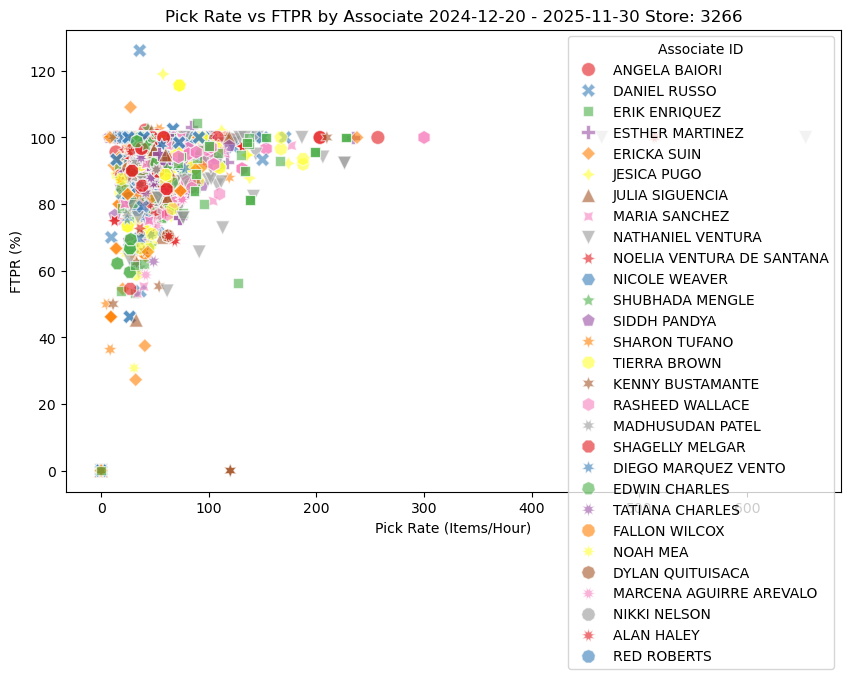

In [3906]:
# Scatter plot with Pick Rate vs FTPR
#selected_store = 3266
df_selected_store = df[df['Store #'] == selected_store]

# Apply associate filter only for store 3266
if selected_store == 3266:
    df_selected_store = df_selected_store[df_selected_store['Associate'].isin(associate_list_3266)]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_selected_store,  # use the correctly filtered DataFrame
    x='Pick Rate', y='FTPR',
    hue='Associate', palette='Set1',
    style='Associate', s=100, alpha=0.6
)
plt.title(f'Pick Rate vs FTPR by Associate {oldest_pick_date} - {last_pick_date} Store: {selected_store}')
plt.xlabel('Pick Rate (Items/Hour)')
plt.ylabel('FTPR (%)')
plt.legend(title='Associate ID')
plt.show()

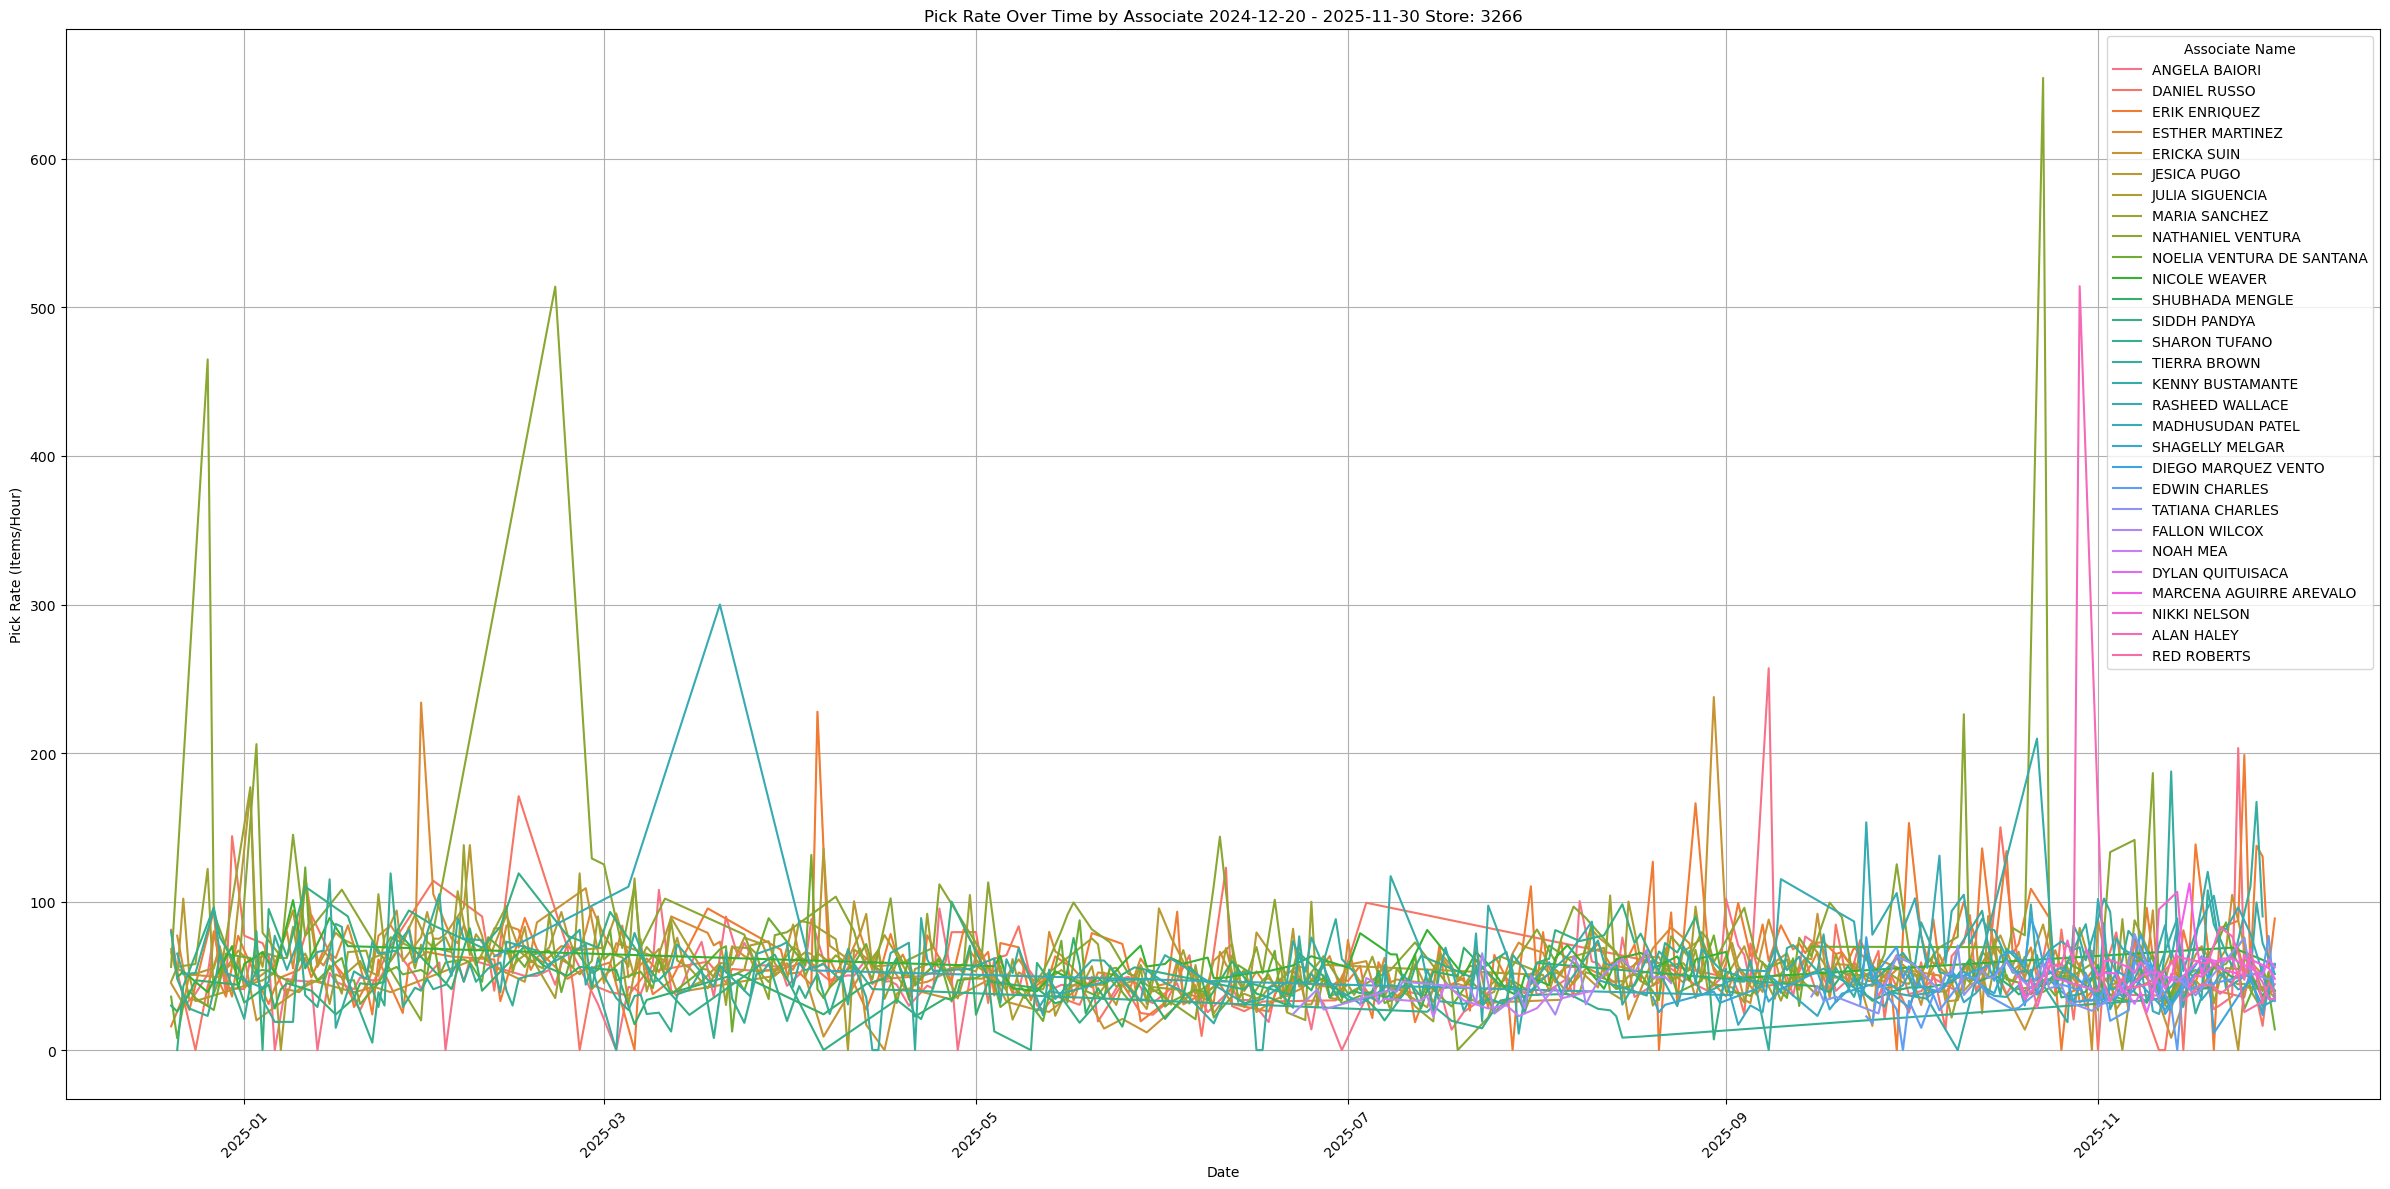

In [3907]:
# Convert 'Day of Pick Date' to datetime format for time-based analysis
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'], format='%m/%d/%y')
df_selected_store['Day of Pick Date'] = pd.to_datetime(df_selected_store['Day of Pick Date'], format='%m/%d/%y')
df_selected_store = df_selected_store.drop_duplicates()

# Filter associates appropriately
if selected_store == 3266:
    df_selected_store_associates_only = df_selected_store[df_selected_store['Associate'].isin(associate_list_3266)]
else:
    df_selected_store_associates_only = df_selected_store

# Line plot of Pick Rate over time for each Associate
plt.figure(figsize=(24, 12))
sns.lineplot(
    data=df_selected_store_associates_only,
    x='Day of Pick Date', y='Pick Rate',
    hue='Associate', markers=True
)
plt.title(f'Pick Rate Over Time by Associate {oldest_pick_date} - {last_pick_date} Store: {selected_store}')
plt.xlabel('Date')
plt.ylabel('Pick Rate (Items/Hour)')
plt.xticks(rotation=45)
plt.legend(title='Associate Name')
plt.grid(True)
plt.tight_layout()
plt.show()

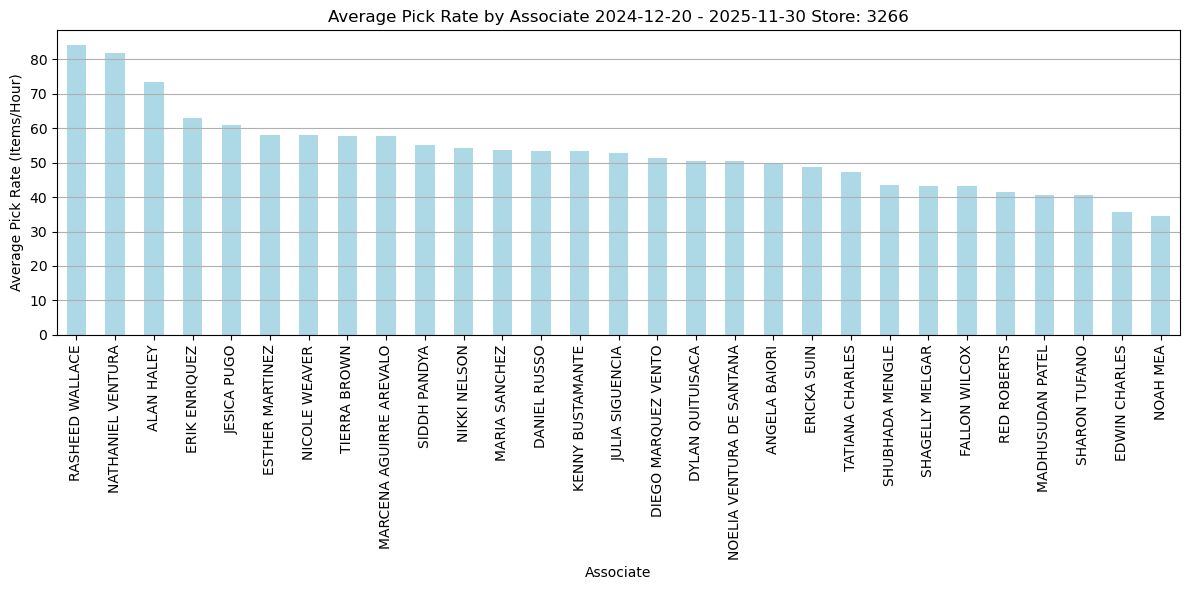

Associate
RASHEED WALLACE             84.19
NATHANIEL VENTURA           81.71
ALAN HALEY                  73.53
ERIK ENRIQUEZ               62.82
JESICA PUGO                 60.94
ESTHER MARTINEZ             58.05
NICOLE WEAVER               57.89
TIERRA BROWN                57.60
MARCENA AGUIRRE AREVALO     57.59
SIDDH PANDYA                55.24
NIKKI NELSON                54.24
MARIA SANCHEZ               53.79
DANIEL RUSSO                53.45
KENNY BUSTAMANTE            53.42
JULIA SIGUENCIA             52.72
DIEGO MARQUEZ VENTO         51.32
DYLAN QUITUISACA            50.48
NOELIA VENTURA DE SANTANA   50.44
ANGELA BAIORI               49.80
ERICKA SUIN                 48.59
TATIANA CHARLES             47.39
SHUBHADA MENGLE             43.52
SHAGELLY MELGAR             43.18
FALLON WILCOX               43.18
RED ROBERTS                 41.42
MADHUSUDAN PATEL            40.63
SHARON TUFANO               40.53
EDWIN CHARLES               35.68
NOAH MEA                    34.36
Name

In [3908]:
# Grouping by Associate ID and calculating average Pick Rate
avg_pick_rate = df_selected_store.groupby('Associate')['Pick Rate'].mean().sort_values(ascending=False)
if selected_store == 3266:
    avg_pick_rate = avg_pick_rate[avg_pick_rate.index.isin(associate_list_3266)]

# Bar plot for average Pick Rate per Associate ID
plt.figure(figsize=(12, 6))
avg_pick_rate.plot(kind='bar', color='lightblue')
plt.title(f'Average Pick Rate by Associate {oldest_pick_date} - {last_pick_date} Store: {selected_store}')
plt.xlabel('Associate')
plt.ylabel('Average Pick Rate (Items/Hour)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

avg_pick_rate

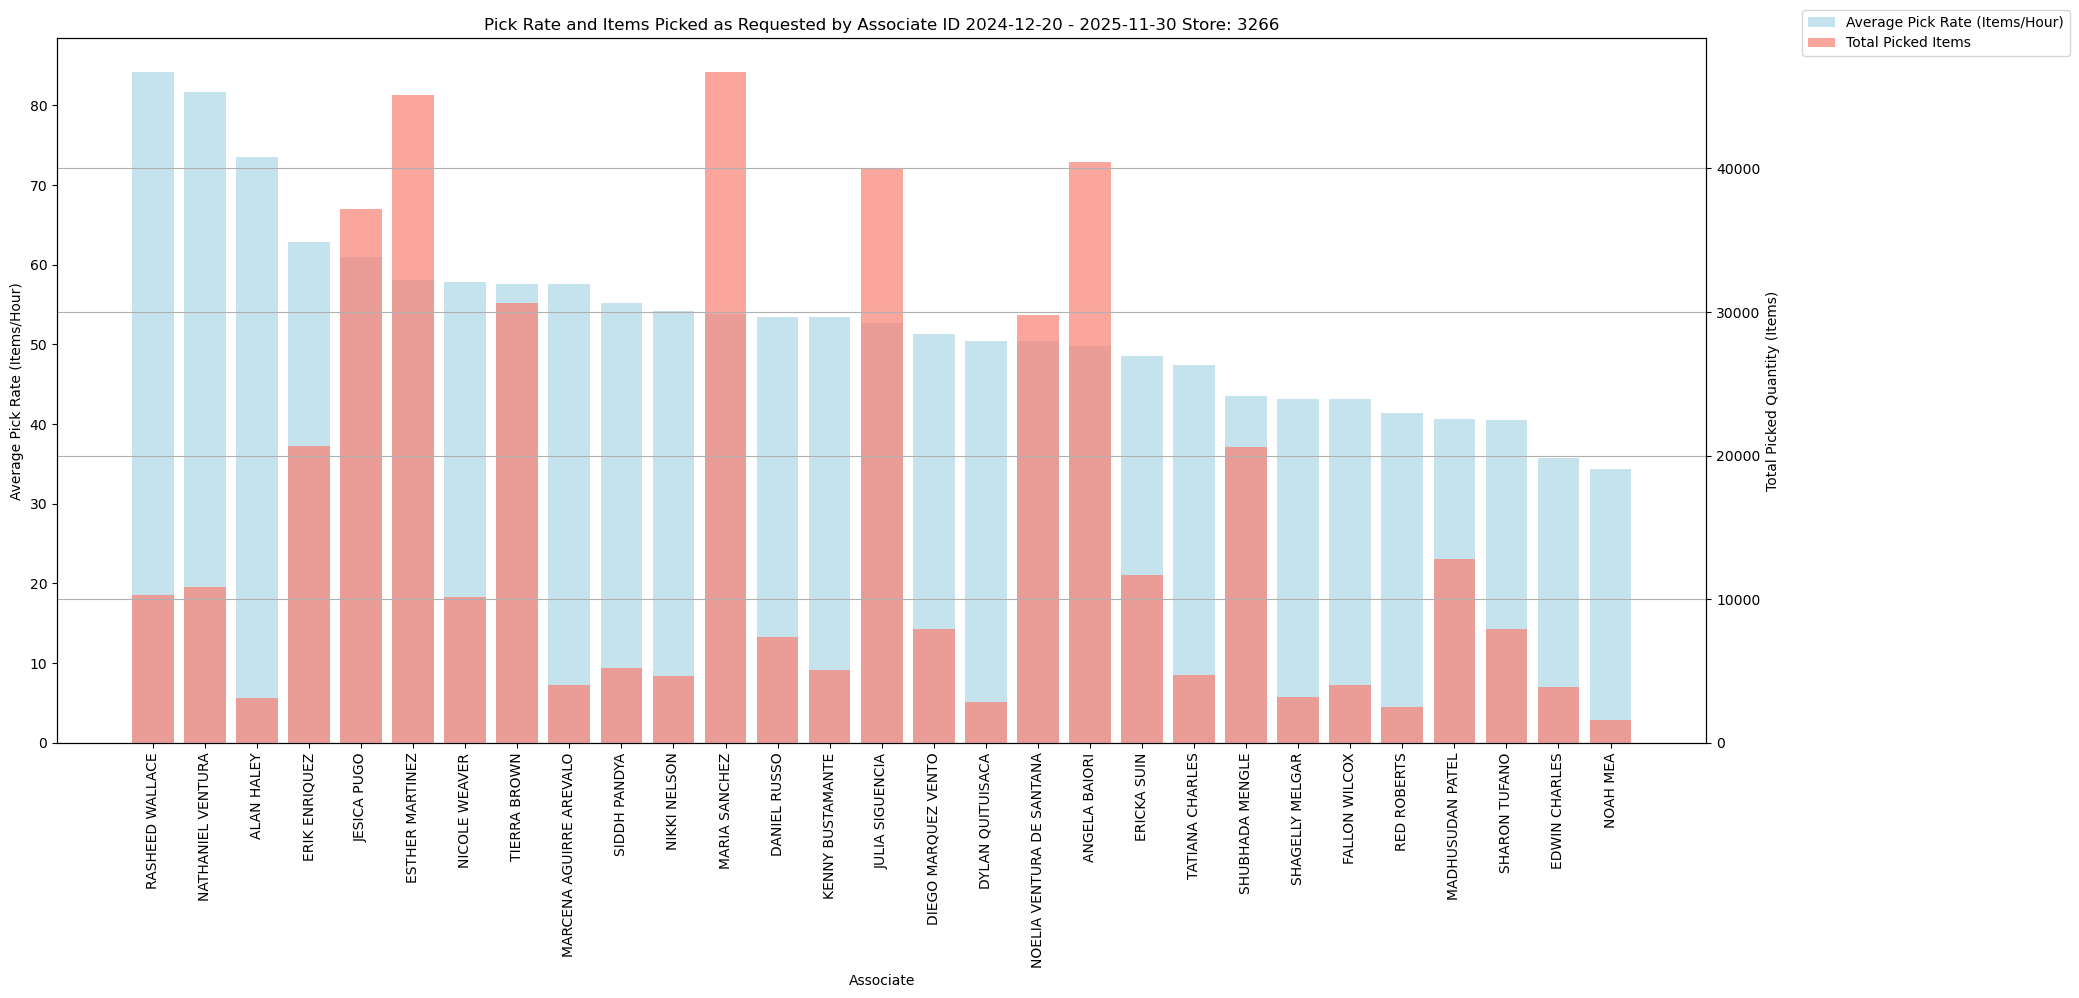

In [3909]:
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Pick Rate'] = pd.to_numeric(df['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df_selected_store['Picked As Req Qty'] = pd.to_numeric(df_selected_store['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['Pick Rate'] = pd.to_numeric(df_selected_store['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN

df_selected_store = df_selected_store.loc[df_selected_store['Store #'] == selected_store, :]

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df_selected_store.dropna(subset=['Picked As Req Qty', 'Pick Rate'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_pick_rate = df_clean.groupby('Associate')['Pick Rate'].mean().sort_values(ascending=False)
if selected_store == 3266:
    avg_pick_rate = avg_pick_rate[avg_pick_rate.index.isin(associate_list_3266)]
total_picked_qty = df_clean.groupby('Associate')['Picked As Req Qty'].sum()
if selected_store == 3266:
    total_picked_qty = total_picked_qty[total_picked_qty.index.isin(associate_list_3266)]

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(18, 10))
avg_pick_rate.index = avg_pick_rate.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_pick_rate.index, avg_pick_rate, color='lightblue', alpha=0.7, label='Average Pick Rate (Items/Hour)')
ax1.set_xlabel('Associate')
ax1.set_ylabel('Average Pick Rate (Items/Hour)')
ax1.set_title(f'Pick Rate and Items Picked as Requested by Associate ID {oldest_pick_date} - {last_pick_date} Store: {selected_store}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()


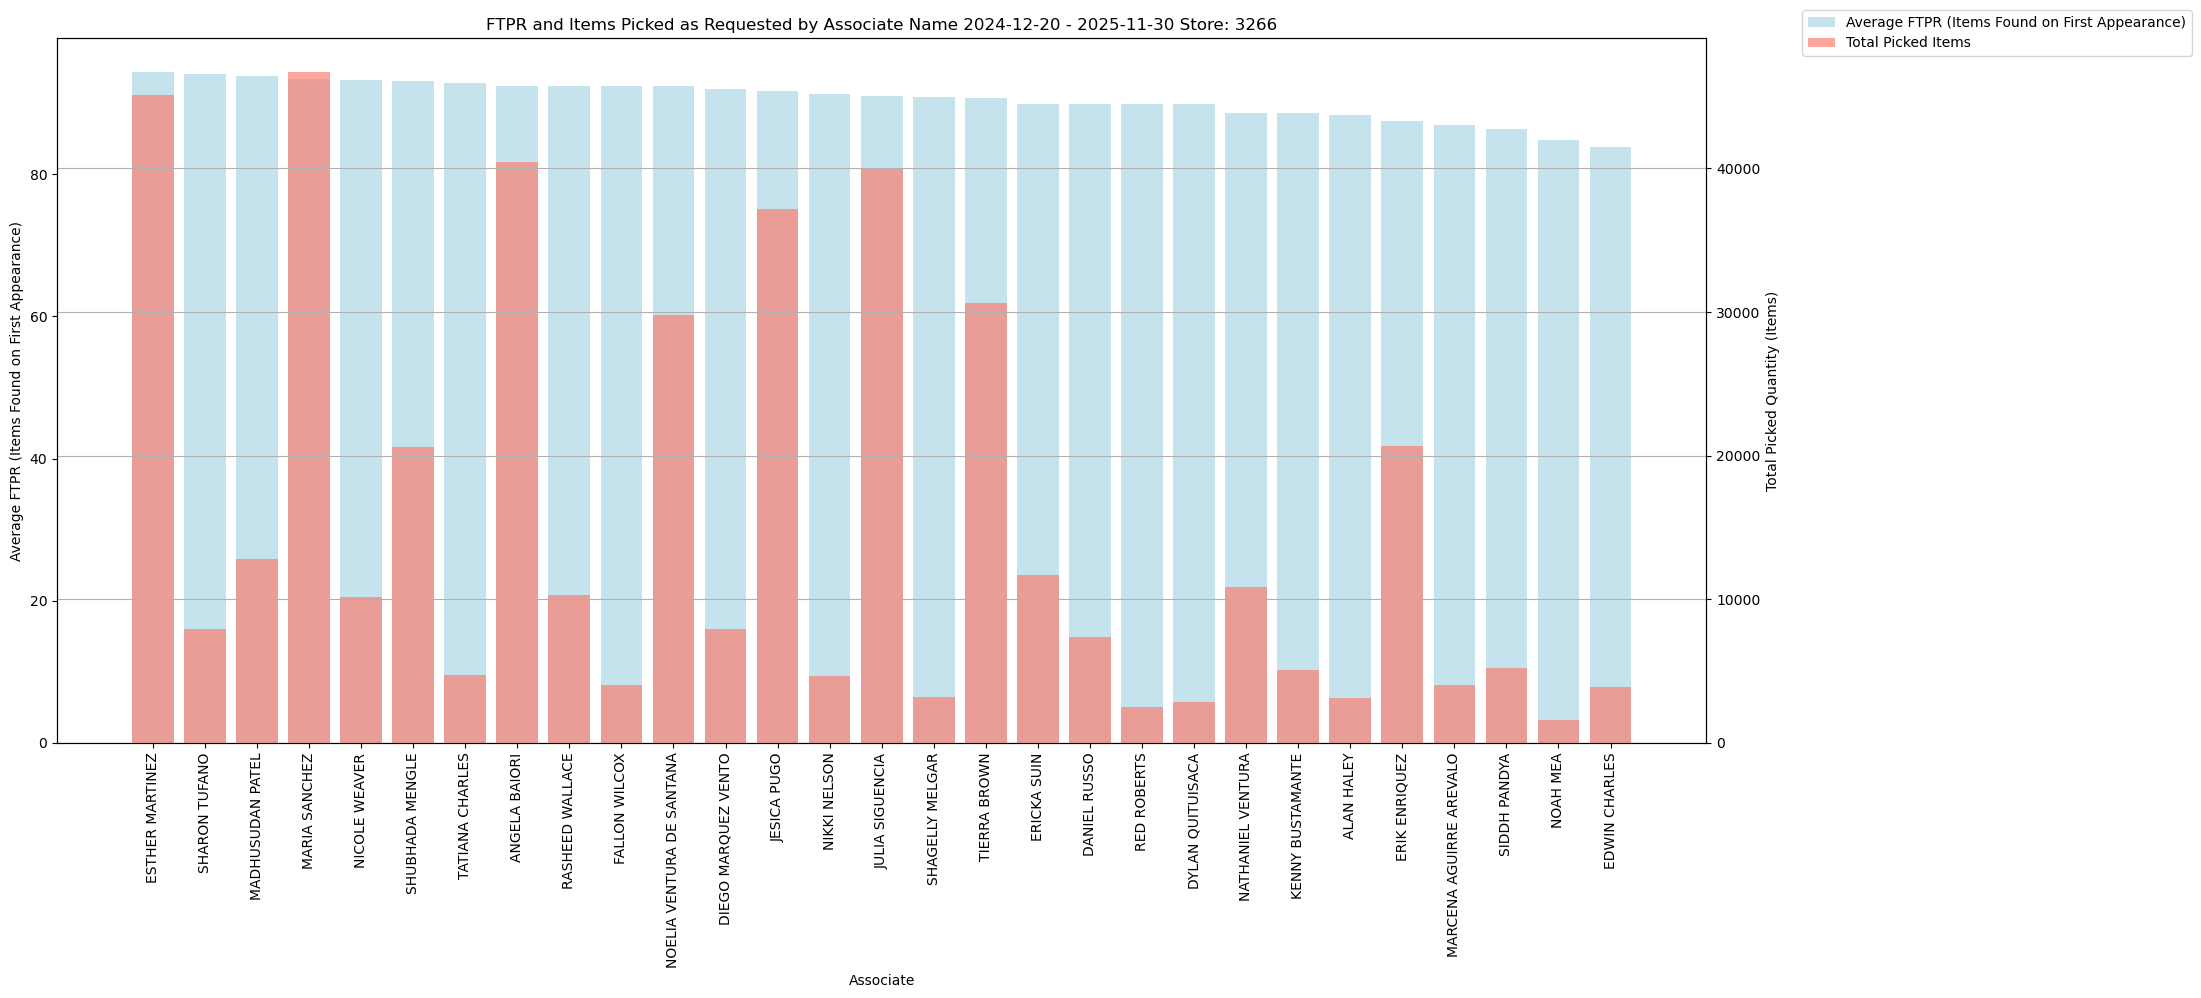

In [3910]:
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['FTPR'] = pd.to_numeric(df['FTPR'], errors='coerce')  # Convert to numeric, coerce errors to NaN
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df_selected_store['Picked As Req Qty'] = pd.to_numeric(df_selected_store['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['FTPR'] = pd.to_numeric(df_selected_store['FTPR'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df_selected_store.dropna(subset=['Picked As Req Qty', 'FTPR'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_ftpr = df_clean.groupby('Associate')['FTPR'].mean().astype(float).sort_values(ascending=False)
if selected_store == 3266:
    avg_ftpr = avg_ftpr[avg_ftpr.index.isin(associate_list_3266)]
total_picked_qty = df_clean.groupby('Associate')['Picked As Req Qty'].sum()
if selected_store == 3266:
    total_picked_qty = total_picked_qty[total_picked_qty.index.isin(associate_list_3266)]

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(18, 10))

avg_ftpr.index = avg_ftpr.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_ftpr.index, avg_ftpr, color='lightblue', alpha=0.7, label='Average FTPR (Items Found on First Appearance)')
ax1.set_xlabel('Associate')
ax1.set_ylabel('Average FTPR (Items Found on First Appearance)')
ax1.set_title(f'FTPR and Items Picked as Requested by Associate Name {oldest_pick_date} - {last_pick_date} Store: {selected_store}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()

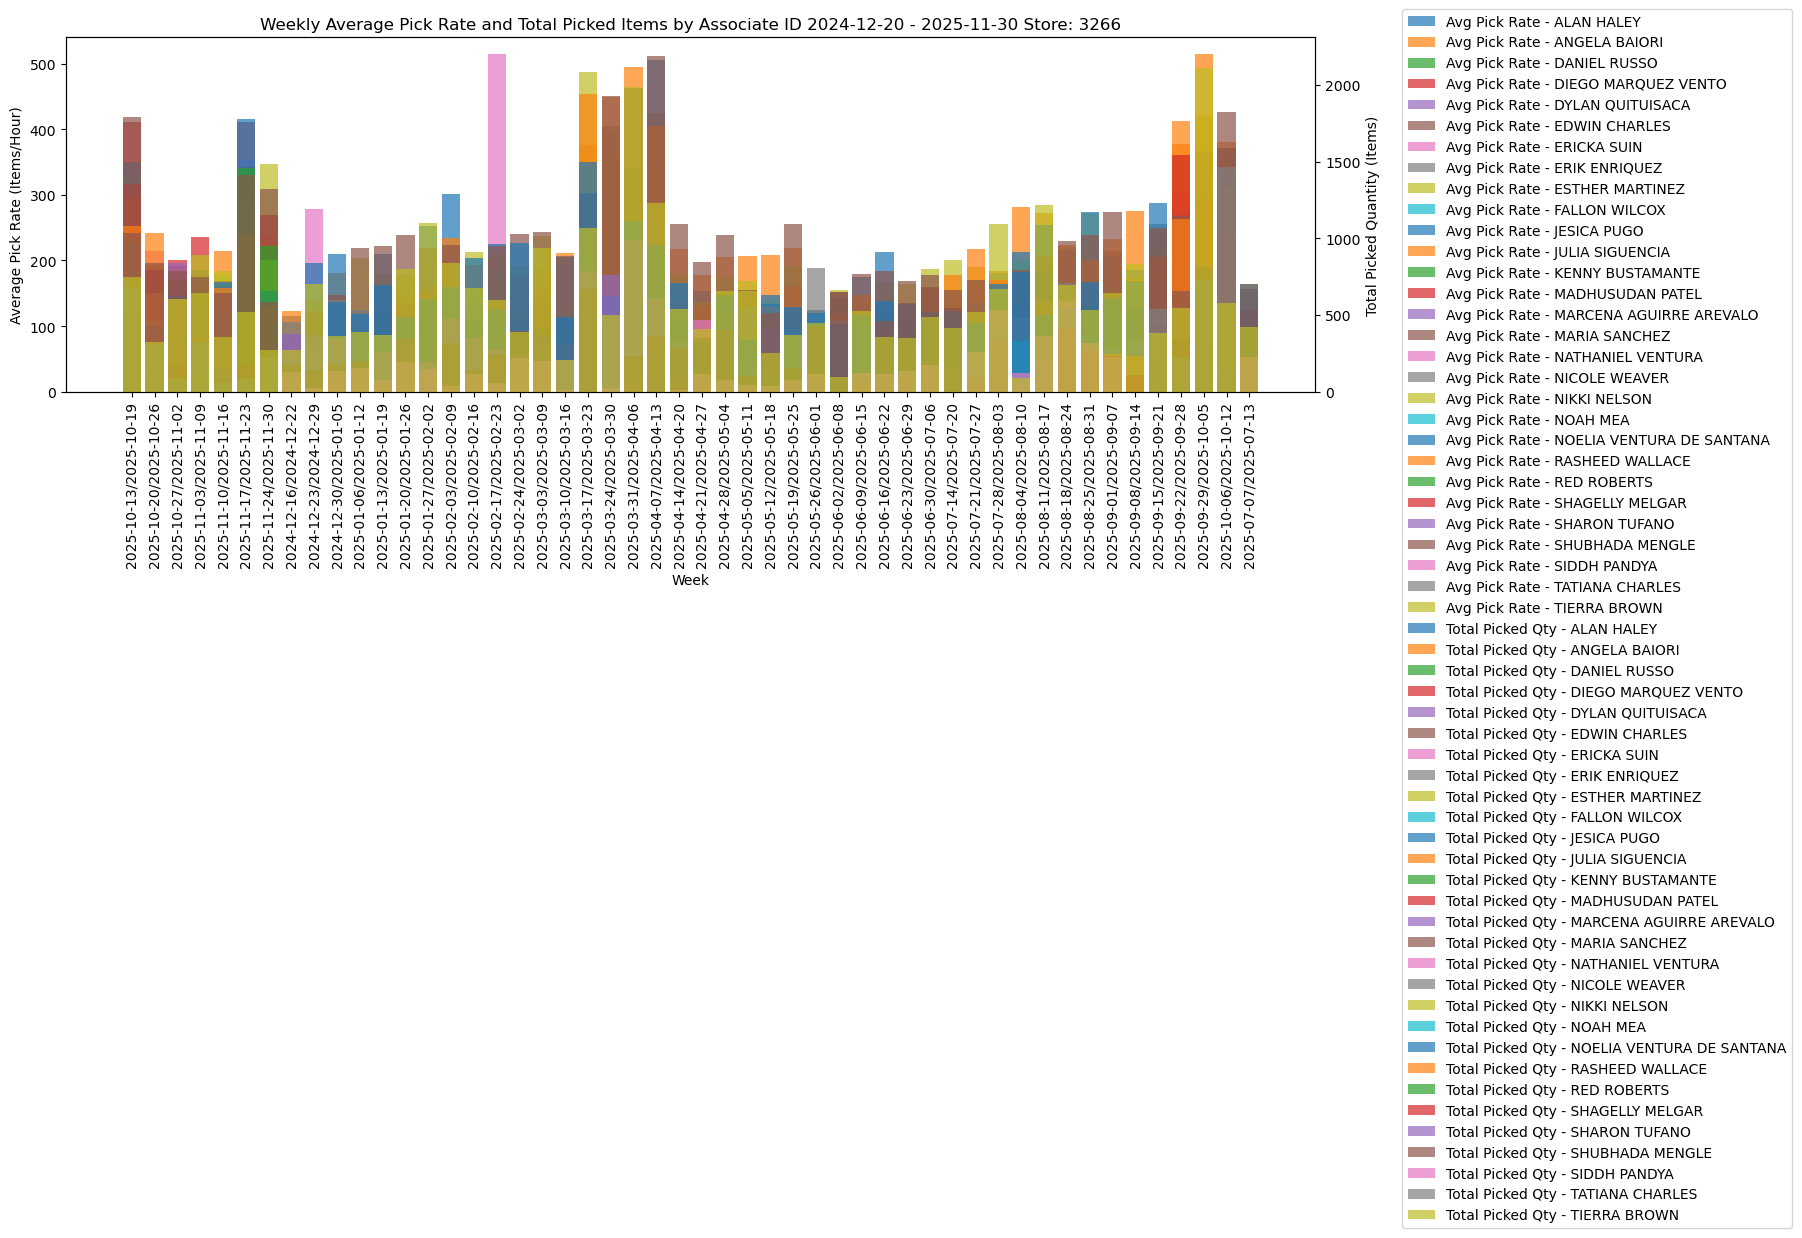

In [3911]:
# Ensure columns like 'Picked As Req Qty' and 'Pick Rate' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Pick Rate'] = pd.to_numeric(df['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN
# Ensure columns like 'Picked As Req Qty' and 'Pick Rate' are numeric and handle any missing data
df_selected_store['Picked As Req Qty'] = pd.to_numeric(df_selected_store['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['Pick Rate'] = pd.to_numeric(df_selected_store['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df_selected_store.dropna(subset=['Picked As Req Qty', 'Pick Rate'])

# Grouping by Associate ID and week (using 'Day of Pick Date' for weekly grouping)
# We're using pd.Grouper to group by week and Associate ID
df_clean['Week'] = df_clean['Day of Pick Date'].dt.to_period('W')
if selected_store == 3266:
    df_clean = df_clean[df_clean['Associate'].apply(lambda x: x in associate_list_3266)]
df_clean = df_clean.drop_duplicates()

# Group by Week and Associate ID to calculate the sum of 'Picked As Req Qty' and average 'Pick Rate'
weekly_data = df_clean.groupby(['Week', 'Associate']).agg(
    avg_pick_rate=('Pick Rate', 'mean'),
    total_picked_qty=('Picked As Req Qty', 'sum')
).reset_index()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty by Week
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for average Pick Rate (items per hour) by Week
for label, data in weekly_data.groupby('Associate'):
    ax1.bar(data['Week'].astype(str), data['avg_pick_rate'], label=f'Avg Pick Rate - {label}', alpha=0.7)

ax1.set_xlabel('Week')
ax1.set_ylabel('Average Pick Rate (Items/Hour)')
ax1.set_title(f'Weekly Average Pick Rate and Total Picked Items by Associate ID {oldest_pick_date} - {last_pick_date} Store: {selected_store}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()

# Bar plot for total Picked As Req Qty by Week
for label, data in weekly_data.groupby('Associate'):
    ax2.bar(data['Week'].astype(str), data['total_picked_qty'], label=f'Total Picked Qty - {label}', alpha=0.7)

ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Week
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()


In [3912]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

'''# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution in y_train
print("Class distribution in y_train:")
print(Counter(y_train))

# Check class distribution in y_test
print("\nClass distribution in y_test:")
print(Counter(y_test))

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Get probabilistic predictions (probabilities of the positive class)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions for accuracy, precision, recall, and f1 score
threshold = 0.5  # You can adjust this threshold as needed
y_pred = (y_pred_proba >= threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use probabilistic predictions here

print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")'''

'# Assuming X and y are your features and target variable\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Check class distribution in y_train\nprint("Class distribution in y_train:")\nprint(Counter(y_train))\n\n# Check class distribution in y_test\nprint("\nClass distribution in y_test:")\nprint(Counter(y_test))\n\n# Oversample the minority class\nros = RandomOverSampler(random_state=42)\nX_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)\n\n# Initialize and train the model\nmodel = RandomForestClassifier(random_state=42)\nmodel.fit(X_train_resampled, y_train_resampled)\n\n# Get probabilistic predictions (probabilities of the positive class)\ny_pred_proba = model.predict_proba(X_test)[:, 1]\n\n# Convert probabilities to binary predictions for accuracy, precision, recall, and f1 score\nthreshold = 0.5  # You can adjust this threshold as needed\ny_pred = (y_pred_proba >= threshold).astype(int)\n\n# Calculate metrics\n

In [3913]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Assuming df is the DataFrame containing your data
threshold_pick_rate = 50
threshold_ftpr = 97.5
'''df['Handled_Exceptions'] = ((df['Pick Rate'] < threshold_pick_rate) | 
                            (df['FTPR'] > threshold_ftpr)).astype(int)'''
'''df['Handled_Exceptions'] = (
    (df['Pick Rate'] < threshold_pick_rate) | 
    (df['FTPR'] > threshold_ftpr) | 
    (df['Exception Qty Req to Pick'] > 0) | 
    (df['Exception Nil Pick Qty'] > 0)
).astype(int)
'''
#df['Exception Qty Req to Pick'] = pd.to_numeric(df['Exception Qty Req to Pick'], errors='coerce').fillna(0)
#df['Handled_Exceptions'] = (df['Exception Qty Req to Pick'] > 0).astype(int)
#df['Handled_Exceptions'] = np.where(df['Exception Qty Req to Pick'] > 0, 1, 0)
df['Exception Qty Req to Pick'] = pd.to_numeric(df['Exception Qty Req to Pick'], errors='coerce').fillna(0)

# Sanity threshold: ignore floating point noise
df['Handled_Exceptions'] = (df['Exception Qty Req to Pick'] > 1e-6).astype(int)


print(df['Handled_Exceptions'].value_counts())

features = ['FTPR', 'Pick Rate', 'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty']
target = 'Handled_Exceptions'
X = df[features]
y = df[target]

# Check if there are at least two classes in y
if len(np.unique(y)) < 2:
    print("Only one class present in the target variable. Cannot calculate ROC AUC score.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Check if there are at least two classes in both y_train and y_test
    if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
        print("Only one class present in either the training or test set. Cannot calculate ROC AUC score.")
    else:
        model = RandomForestClassifier(random_state=42, n_jobs=-1)  # Use all CPU cores
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Calculate ROC AUC score only if there are at least two classes in y_test
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"ROC AUC: {roc_auc}")

# Perform grid search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Calculate cross-validation score
cross_val_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, n_jobs=-1)
print(f"Cross-Validation Scores: {cross_val_scores}")

Handled_Exceptions
0    67952
1    20015
Name: count, dtype: int64
Accuracy: 0.8305104012731613
Precision: 0.6909090909090909
Recall: 0.4280593958013313
F1 Score: 0.5286120771419538
ROC AUC: 0.7931395277328142
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Best Score: 0.8177994366746084
Cross-Validation Scores: [0.81740675 0.82351687 0.81271758 0.81924115 0.81611482]


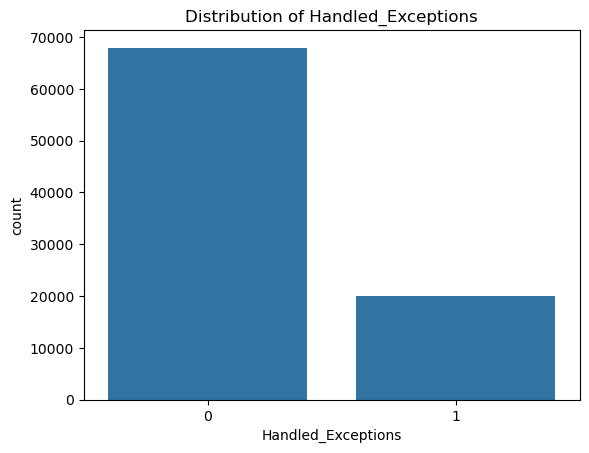

In [3914]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Handled_Exceptions', data=df)
plt.title('Distribution of Handled_Exceptions')
plt.show()


In [3915]:
df.head(3)

Store #      Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions
24     3266  ANGELA BAIORI       2025-02-05 97.01        233.00      227.00      60.00       3.86             227.00                 4      0.00             3                          0                            0                        0.00                    0.00                    0                   0           233.00      a0b0ad9     178      2  2025              2   Wednesday        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07           2025         2026      FY2026            2                    1     February                   0
25     3266  ANGELA BAIORI       2025-02-03  0.00          0.00        0.00       0.00       0.00               0.00                 0      0.00             0                          1                            0                        2.00                    0.00                    0                   0             0.00      a0b0ad9     178      2  2025              0      Monday        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07           2025         2026      FY2026            2                    1     February                   1
26     3266  ANGELA BAIORI       2025-02-02 97.03        268.00      254.00      59.00       4.36             254.00                 2      0.00            10                          0                            0                        0.00                    0.00                    0                   0           268.00      a0b0ad9     178      2  2025              6      Sunday        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07           2025         2026      FY2026            1                    1     February                   0

In [3916]:
print(df['Exception Qty Req to Pick'].loc[df['Handled_Exceptions'] == 1].unique())
# Sanity check: show where Exception Qty Req to Pick is 0 but Handled_Exceptions is 1
df[(df['Exception Qty Req to Pick'] == 0) & (df['Handled_Exceptions'] == 1)]


[  1   2   8   3  10   4   7   6  14  23   5  13   9  18  12 107  11  58
  38  30 120  68 116  45 133  54  19  20  41  90  96  74  29  47  39  17
 103  52  32  27  55  40  97  72  51  35  70  87  43 139 163 151 117  67
 138  22  89  15 150  73  61  50 137  26  33  80  85 171 101  28  21 110
  75  71  82 136  62 122  76  25  57 203  42  88 146  36  79 172 161  86
 164  69 118  59 112  77 170 159  65  66  24  64 125  16 156 141  63 135
  34 114  94  84  31  49 184 242  37  56  48  83 206  60 169 104 132  44
  78 111  46 124  81 130 108 191  53 123 126 119 129 105  93 162 293 168
 155 157 142 154 128 121  91  99 113 140 145 102 109  92 165 153 149 115
 134 185  95  98 158 127 188 106 100 167 131 160 143 148 265 178 147 144
 175 202 201 207 193 272 166 177 152 183 182 186 187 176 271 268 179 229
 192 197 244 199 249 277 204 173 219 214 196 223 228]


Empty DataFrame
Columns: [Store #, Associate, Day of Pick Date, FTPR, FTP Expected, FTP Actual, Pick Rate, Pick Hours, Picked As Req Qty, Substitution Qty, Ovrd Qty, Nil Pick Qty, Exception Qty Req to Pick, Exception Picked As Req Qty, Exception Substitution Qty, Exception Nil Pick Qty, First Pick Assgn Qty, First Disp Pick Qty, Qty Req to Pick, Associate ID, Market, Month, Year, Day of Week #, Day of Week, Custom Week Start, Custom Week End, Week, FY Start Year, FY End Year, Fiscal Year, Fiscal Week, Fiscal Month Number, Fiscal Month, Handled_Exceptions]
Index: []

In [3917]:
faster_run = False
if faster_run == False:

    start_time = time.time()
    # Threshold ranges to test
    threshold_pick_rate_values = np.linspace(5, 500, 8)  # Adjusted range, 100 
    #print(threshold_pick_rate_values)
    threshold_ftpr_values = np.linspace(70, 105, 12)       # Adjusted range, 300

    # Variables to store the best thresholds and corresponding F1 score
    best_thresholds = None
    best_f1_score = -np.inf  # Initialize to a very low value
    results = []  # Store results for each threshold combination

    # Debugging: Check initial conditions
    #print("Initial Threshold Values:")
    #print(f"Pick Rate Thresholds: {threshold_pick_rate_values}")
    #print(f"FTPR Thresholds: {threshold_ftpr_values}")

    # Iterate through threshold combinations
    for threshold_pick_rate in threshold_pick_rate_values:
        for threshold_ftpr in threshold_ftpr_values:
            # Create target variable based on thresholds
            '''df['Handled_Exceptions'] = ((df['Pick Rate'] < threshold_pick_rate) |
                                        (df['FTPR'] > threshold_ftpr)).astype(int)
                                        '''
            y = df['Handled_Exceptions']
            X = df[['FTPR', 'Pick Rate', 'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty']]

            # Debugging: Check class distribution
            #print(f"Testing thresholds: Pick Rate={threshold_pick_rate}, FTPR={threshold_ftpr}")
            #print(f"Class distribution in 'y': {np.unique(y, return_counts=True)}")
            
            # Skip if there is only one class in the target variable
            if len(np.unique(y)) < 2:
                #print("Skipping: Only one class present in target variable")
                continue

            # Split data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Skip if train/test split results in a single class
            if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
                #print("Skipping: Only one class present in train/test sets")
                continue

            # Train a Random Forest model
            model = RandomForestClassifier(random_state=42, n_jobs=-1) ############### n_jobs
            model.fit(X_train, y_train)

            # Make predictions and calculate F1 score
            y_pred = model.predict(X_test)
            f1 = f1_score(y_test, y_pred)

            # Debugging: Print F1 score for the current thresholds
            #print(f"F1 Score for thresholds {threshold_pick_rate}, {threshold_ftpr}: {f1}")

            # Update the best thresholds if current F1 is higher
            if f1 > best_f1_score:
                best_f1_score = f1
                best_thresholds = (threshold_pick_rate, threshold_ftpr)
                #print(f"Updated Best Thresholds: {best_thresholds} with F1={best_f1_score}")

            # Store the results for analysis
            results.append({
                'Pick Rate Threshold': threshold_pick_rate,
                'FTPR Threshold': threshold_ftpr,
                'F1 Score': f1
            })

    # Convert results to a DataFrame for easy analysis
    results_df = pd.DataFrame(results)

    # Display the best thresholds and their corresponding F1 score
    if best_thresholds is None:
        print("No valid threshold combination was found. Adjust thresholds or data distribution.")
    else:
        print(f"Best Thresholds: Pick Rate={best_thresholds[0]}, FTPR={best_thresholds[1]}")
        print(f"Best F1 Score: {best_f1_score}")

    # Optional: Summarize all tested threshold combinations
    if not results_df.empty:
        print("Summary of Top Threshold Combinations:")
        print(results_df.sort_values(by='F1 Score', ascending=False).head())
    else:
        print("No valid results were generated.")
    end_time = time.time()
    print(f'time to run model for {threshold_pick_rate_values.size * threshold_ftpr_values.size} combinations: {end_time - start_time}')

Best Thresholds: Pick Rate=5.0, FTPR=70.0
Best F1 Score: 0.5286120771419538
Summary of Top Threshold Combinations:
    Pick Rate Threshold  FTPR Threshold  F1 Score
0                  5.00           70.00      0.53
1                  5.00           73.18      0.53
70               358.57          101.82      0.53
69               358.57           98.64      0.53
68               358.57           95.45      0.53
time to run model for 96 combinations: 74.4373471736908


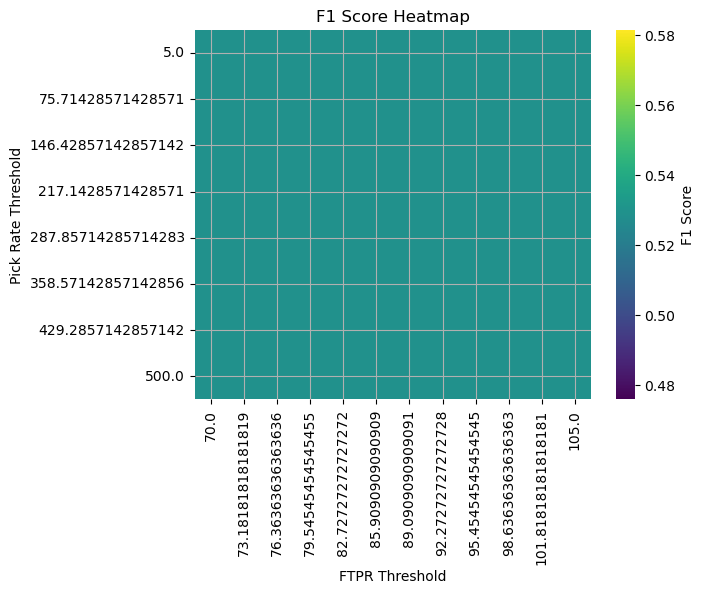

In [3918]:
if faster_run == False:
    # Ensure results_df is not empty
    if not results_df.empty:
        # Rename columns for compatibility with pivot (optional, just for consistency)
        results_df.rename(columns={
            'Pick Rate Threshold': 'pick_rate',
            'FTPR Threshold': 'ftpr',
            'F1 Score': 'f1'
        }, inplace=True)

        # Create pivot table
        pivot_table = results_df.pivot(index='pick_rate', columns='ftpr', values='f1')

        # Generate heatmap
        sns.heatmap(pivot_table, annot=False, fmt=".3f", cmap="viridis", cbar_kws={'label': 'F1 Score'})
        plt.title("F1 Score Heatmap")
        plt.xlabel("FTPR Threshold")
        plt.ylabel("Pick Rate Threshold")
        plt.grid()
        plt.show()
    else:
        print("No data to plot. Ensure valid results are generated before creating a heatmap.")

In [3919]:
print(df['Pick Rate'].describe())
print(df['FTPR'].describe())
print(df['Handled_Exceptions'].value_counts())
feature_importances = model.feature_importances_
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance}")


count   87958.00
mean       84.62
std        49.59
min         0.00
25%        56.20
50%        84.20
75%       108.50
max       947.40
Name: Pick Rate, dtype: float64
count   87967.00
mean       86.59
std        18.78
min         0.00
25%        86.56
50%        91.21
75%        94.48
max       157.14
Name: FTPR, dtype: float64
Handled_Exceptions
0    67952
1    20015
Name: count, dtype: int64
FTPR: 0.20823111646121842
Pick Rate: 0.24481015097460115
Pick Hours: 0.19850659310323082
Qty Req to Pick: 0.1703477953462804
Picked As Req Qty: 0.1781043441146693


<h2>Composite Scoring Starts Here</h2>
<h4>Composite Scoring Modifiers for standardized evaluation throughtout notebook</h4>
<ul>pickrate_modifier</ul>
<ul>ftpr_modifier</ul>
<ul>picked_as_req_modifier</ul>
<ul>pick_hours_modifier

<h1>Composite Score Modifiers</h1>

In [3920]:
pickrate_modifier = 0.3
ftpr_modifier = 0.4
picked_as_req_modifier = 0.2
pick_hours_modifier = 0.1
picked_as_req_composite_threshold = 50

<h1>Set Associate's OPD Start Date</h1>

In [3921]:
# Find the minimum date for each associate and compare to cutoff
today = pd.Timestamp.today()
cutoff_date = pd.to_datetime(today).date() - pd.Timedelta(days=90)

# Get minimum date for each associate
associate_min_dates = df.groupby('Associate')['Day of Pick Date'].min().reset_index()
associate_min_dates.columns = ['Associate', 'Min Date']
df['OPD Start Date'] = df['Associate'].map(
    associate_min_dates.set_index('Associate')['Min Date']
)
df.head()


Store #      Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date
24     3266  ANGELA BAIORI       2025-02-05  97.01        233.00      227.00      60.00       3.86             227.00                 4      0.00             3                          0                            0                        0.00                    0.00                    0                   0           233.00      a0b0ad9     178      2  2025              2   Wednesday        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07           2025         2026      FY2026            2                    1     February                   0     2024-12-22
25     3266  ANGELA BAIORI       2025-02-03   0.00          0.00        0.00       0.00       0.00               0.00                 0      0.00             0                          1                            0                        2.00                    0.00                    0                   0             0.00      a0b0ad9     178      2  2025              0      Monday        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07           2025         2026      FY2026            2                    1     February                   1     2024-12-22
26     3266  ANGELA BAIORI       2025-02-02  97.03        268.00      254.00      59.00       4.36             254.00                 2      0.00            10                          0                            0                        0.00                    0.00                    0                   0           268.00      a0b0ad9     178      2  2025              6      Sunday        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07           2025         2026      FY2026            1                    1     February                   0     2024-12-22
27     3266  ANGELA BAIORI       2024-12-29  92.92        214.00      199.00      42.00       4.88             199.00                 6      0.00             4                          0                            0                        0.00                    0.00                    0                   0           214.00      a0b0ad9     178     12  2024              6      Sunday        2024-12-28      2025-01-03  2024-12-28 to 2025-01-03           2024         2025      FY2025           48                   11     December                   0     2024-12-22
28     3266  ANGELA BAIORI       2024-12-27 100.00         47.00       47.00      79.00       0.60              47.00                 0      0.00             0                          0                            0                        0.00                    0.00                    0                   0            47.00      a0b0ad9     178     12  2024              4      Friday        2024-12-21      2024-12-27  2024-12-21 to 2024-12-27           2024         2025      FY2025           48                   11     December                   0     2024-12-22

<h1>Weekly Averages (WTD)</h1>

In [3922]:
import datetime as dt
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
week_of_interest = df["Week"].max() #defaults to most recent week

df['Pick Hours'] = df['Pick Hours'].astype(float)
# Filter the data for the specified week
#df_week = df[df['Week'] == week_of_interest]
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
df_selected_store = df[df['Store #'] == selected_store].copy()
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']).dt.date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End']).dt.date
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date']).dt.date

# Step 2: Filter for data in the current WTD week
# Assumes df contains 'Custom Week Start', 'Custom Week End', 'Day of Pick Date'
wtd_data = df_selected_store[
    (df_selected_store['Custom Week Start'].astype(str) <= today) &
    (df_selected_store['Custom Week End'].astype(str) >= today) &
    (df_selected_store['Day of Pick Date'].astype(str) <= today)  # ensure we only use data up to today
].copy()
df_week = wtd_data.loc[wtd_data['Store #'] == selected_store, :]

df_week = df_week.drop_duplicates()
if df_week.empty:
    print("No data available for the current week.")
else:
    this_week_df = df_week
    avdf = this_week_df.groupby(['Associate ID', 'Associate']).mean(numeric_only=True)
    avdf['Store #'] = avdf['Store #'].astype(int)
    avdf['Week'] = week_of_interest
    avdf['Custom Week Start'] = df_week['Custom Week Start'].max()
    avdf['Custom Week End'] = df_week['Custom Week End'].max()
    #print(f'avdf columns: {avdf.columns}')
    #print(f'df columns: {df.columns}')
    # Specify the week for analysis
    #week_of_interest = '2025-01-18 to 2025-01-24' #manual range
    #week_of_interest = df["Week"].max() #defaults to most recent week

    # Filter the data for the specified week
    #avdf_week = avdf[avdf['Week'] == week_of_interest]
    avdf['Market'] = avdf['Market'].astype(int)
    avdf['Year'] = avdf['Year'].astype(int)
    avdf['Month'] = avdf['Month'].astype(int)
    print(f'avdf rows: {avdf.shape[0]}')
    print(f'{avdf.head(avdf.shape[0])}')


avdf rows: 34
                                        Store #   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  Qty Req to Pick  Market  Month  Year  Day of Week #  FY Start Year  FY End Year  Fiscal Week  Fiscal Month Number  Handled_Exceptions                      Week Custom Week Start Custom Week End
Associate ID Associate                                                                                                                                                                                                                                                                                                                                                                                                                                                             
a0b0ad9      ANGELA BAIORI                 3266  9

<h1>Weekly Averages (WTD) for new OPD associates</h1>

In [3923]:
# Filter associates who started in the last 90 days
df_weekly_avg_new_to_opd_list = associate_min_dates.loc[
    associate_min_dates['Min Date'].dt.date >= cutoff_date, 'Associate'
].unique()

print(f"Cutoff Date: {cutoff_date}")
print(f"New to OPD Associates (started within last 90 days): {df_weekly_avg_new_to_opd_list}")
print(associate_min_dates)

df_weekly_avg_new_to_opd = avdf.loc[avdf.index.get_level_values('Associate').isin(df_weekly_avg_new_to_opd_list), :]
df_weekly_avg_new_to_opd

Cutoff Date: 2025-09-02
New to OPD Associates (started within last 90 days): ['A0G0IB5' 'A0M1D6I' 'A0W01VR' 'AARTI ROY' 'ABIGAIL MAYTA CANCHANYA'
 'ADAM FURLONG' 'ALAN HAHN' 'ALAN HALEY' 'ALAN ZARAKHOVICH'
 'ALIANA RUSSELL' 'AMAAN RAFI' 'AMANDA VANMETER' 'ANDREA CRUZ'
 'ANDREW GELPI' 'ANGENI NOLON' 'ANNETTE SANDQUIST' 'ANTHONY AURIEMMA'
 'ANTHONY GALLINARI' 'ANTHONY LORENZO' 'ARELIS CASTRO' 'ASHILAYE CURTIS'
 'ASHTON AUGUSTINO' 'AVA NICHOLSON' 'AZUCENA ZACARIAS' 'BERNEDETTE WILSON'
 'BETSEY OSORIO CUBAS' 'BRANDON CHALLENDER' 'BRANDON JURNOCK'
 'BRENDA SILVA LOPEZ' 'BRITTANY KELLER' 'BRYAN CARRILLO' 'C0A0JAZ'
 'CARLOS COLON' 'CATRICE ROCKMORE' 'CECILIA MANRIQUE MORI'
 'CHINTAN PARIKH' 'CHLOE AMBROSE' 'CHRIS ROMULUS' 'CHRISTOPHER FOGLIO'
 'CHRISTOPHER LAVECCHIA' 'CIARA HODGE' 'CODY LINE' 'DAISY VERDEJO'
 'DALIA FLORES-PEREZ' 'DAMOUR LORISME' 'DANIEL ROJAS' 'DANIELLE AHART'
 'DANIELLE BRINEY' 'DANNY URENA' 'DANNY YANG' 'DARYEN REED' 'DAVE PATEL'
 'DAVID PIERMAN' 'DAWN DESIATO' 'DEBRA KRZA

Store #   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  Qty Req to Pick  Market  Month  Year  Day of Week #  FY Start Year  FY End Year  Fiscal Week  Fiscal Month Number  Handled_Exceptions                      Week Custom Week Start Custom Week End
Associate ID Associate                                                                                                                                                                                                                                                                                                                                                                                                                                                           
a0r16c4      AMAAN RAFI                  3266  78.26         23.00       18.00      47.10        0.38              18.00              0.00      0.00          5.00                       0.00                         0.00                        0.00                    0.00            23.00     178     11  2025           5.00        2025.00      2026.00        44.00                11.00                0.00  2025-11-29 to 2025-12-05        2025-11-29      2025-12-05
d0m05m7      DIEGO MARQUEZ VENTO         3266  96.45        282.00      272.00      58.10        4.80             272.00              7.00      0.00          8.00                       0.00                         0.00                        0.00                    0.00           282.00     178     11  2025           6.00        2025.00      2026.00        44.00                11.00                0.00  2025-11-29 to 2025-12-05        2025-11-29      2025-12-05
d0q01bg      DYLAN QUITUISACA            3266  92.79        310.50      288.00      58.40        5.00             288.00              2.50      0.00         17.00                       0.00                         0.00                        0.00                    0.00           310.50     178     11  2025           5.50        2025.00      2026.00        44.00                11.00                0.00  2025-11-29 to 2025-12-05        2025-11-29      2025-12-05
e0c0lkv      EDWIN CHARLES               3266  92.29         58.00       54.50      54.90        1.43              54.50              2.50      0.00          3.50                       0.00                         0.00                        0.00                    0.00            58.00     178     11  2025           5.50        2025.00      2026.00        44.00                11.00                0.00  2025-11-29 to 2025-12-05        2025-11-29      2025-12-05
j0r1755      RED ROBERTS                 3266  87.16        172.50      152.50      41.75        3.73             154.00              3.50      0.00         16.00                       5.00                         0.00                        0.00                    5.00           172.50     178     11  2025           5.50        2025.00      2026.00        44.00                11.00                1.00  2025-11-29 to 2025-12-05        2025-11-29      2025-12-05
m0a0lwy      MARCENA AGUIRRE AREVALO     3266  85.79        123.00      104.50      51.65        2.14             104.50              4.00      0.00         16.00                       0.00                         0.00                        0.00                    0.00           123.00     178     11  2025           5.50        2025.00      2026.00        44.00                11.00                0.00  2025-11-29 to 2025-12-05        2025-11-29      2025-12-05
n0n00j6      NIKKI NELSON                3266  90.26        127.00      114.50      34.45        3.42             114.50              3.50      0.00         12.50                       0.00                         0.00                        0.00                    0.00           127.00     178     11  2025  

<h1>Weekly Averages (WTD) Selected Associate</h1>

In [3924]:
selected_associate = 'gabriel nydick'
selected_associate = selected_associate.upper()
print(f'selected associate: {selected_associate}')
print(avdf.loc[avdf.index.get_level_values('Associate') == selected_associate, :])

selected associate: GABRIEL NYDICK
                             Store #  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  Qty Req to Pick  Market  Month  Year  Day of Week #  FY Start Year  FY End Year  Fiscal Week  Fiscal Month Number  Handled_Exceptions                      Week Custom Week Start Custom Week End
Associate ID Associate                                                                                                                                                                                                                                                                                                                                                                                                                                                 
g0n018d      GABRIEL NYDICK     3266 94.73         52

<h1>Weekly Averages (LW)</h1>

In [3925]:
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
today = pd.to_datetime(today).date()

df_selected_store = df.loc[df['Store #'] == selected_store, :]
# Find the last full week's end date (before today)
last_full_week_end = df['Custom Week End'][df['Custom Week End'] < today].max()

# Get the corresponding start date for that week
last_full_week_start = df['Custom Week Start'][df['Custom Week End'] == last_full_week_end].max()

df_lw = df[(df['Custom Week End'] == last_full_week_end) | (df['Custom Week Start'] == last_full_week_start)] #All stores in market 178
df_lw = df_selected_store[(df_selected_store['Custom Week End'] == last_full_week_end) | (df_selected_store['Custom Week Start'] == last_full_week_start)]

avdf = df_lw.groupby(['Associate ID', 'Associate']).mean(numeric_only=True)
avdf['Store #'] = avdf['Store #'].astype(int)
avdf['Week'] = last_full_week_start.strftime('%Y-%m-%d') + " to " + last_full_week_end.strftime('%Y-%m-%d')
avdf['Custom Week Start'] = last_full_week_start
avdf['Custom Week End'] = last_full_week_end
print(f'avdf row count: {avdf.shape[0]}')
print(f'Week: {avdf["Week"].unique()}')
avdf.head(avdf.shape[0])


avdf row count: 38
Week: ['2025-11-22 to 2025-11-28']


Store #   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  Qty Req to Pick  Market  Month    Year  Day of Week #  FY Start Year  FY End Year  Fiscal Week  Fiscal Month Number  Handled_Exceptions                      Week Custom Week Start Custom Week End
Associate ID Associate                                                                                                                                                                                                                                                                                                                                                                                                                                                               
a0b0ad9      ANGELA BAIORI                 3266  92.37        103.90       95.90      77.31        2.29              97.70              5.60      0.00          3.30                       1.00                         0.20                        0.00                    0.80           103.90  178.00  11.00 2025.00           2.30        2025.00      2026.00        43.80                10.80                0.20  2025-11-22 to 2025-11-28        2025-11-22      2025-11-28
a0h160c      ALAN HALEY                    3266  83.36         90.00       77.00      59.44        1.57              77.90              7.80      0.00          6.90                       3.20                         1.00                        0.40                    1.80            90.00  178.00  11.00 2025.00           2.30        2025.00      2026.00        43.80                10.80                0.80  2025-11-22 to 2025-11-28        2025-11-22      2025-11-28
d0c0as3      DANIELLE CASIANO              3266  90.34         30.09       29.91     100.25        0.33              31.27              0.27      0.00          0.00                       0.82                         0.64                        0.00                    0.18            30.09  178.00  11.00 2025.00           2.00        2025.00      2026.00        43.91                10.91                0.36  2025-11-22 to 2025-11-28        2025-11-22      2025-11-28
d0m05m7      DIEGO MARQUEZ VENTO           3266  93.73        147.50      137.67      41.63        3.49             137.67              4.00      0.00         11.00                       0.00                         0.00                        0.00                    0.00           147.50  178.00  11.00 2025.00           1.83        2025.00      2026.00        44.00                11.00                0.00  2025-11-22 to 2025-11-28        2025-11-22      2025-11-28
d0q01bg      DYLAN QUITUISACA              3266  91.74        322.33      296.33      58.03        5.44             301.00             18.00      0.00          7.00                       0.00                         0.00                        0.00                    0.00           322.33  178.00  11.00 2025.00           5.33        2025.00      2026.00        43.33                10.33                0.00  2025-11-22 to 2025-11-28        2025-11-22      2025-11-28
d0r0khi      DANIEL RUSSO                  3266  94.10         50.00       45.83      38.78        0.95              45.83              1.67      0.00          3.17                       1.67                         0.67                        0.33                    0.33            50.00  178.00  11.00 2025.00           1.83        2025.00      2026.00        44.00                11.00                0.33  2025-11-22 to 2025-11-28        2025-11-22      2025-11-28
d0r0qlv      DEMARIO REED                  3266 100.00          8.00        8.00      85.00        0.09               8.00              0.00      0.00          0.00                       0.00                         0.00                        0.00                    0.00        

<h1>Weekly Averages (LW) for new OPD associates</h1>

In [3926]:
#weekly averages for new to OPD associates
df_weekly_avg_new_to_opd_lw = avdf.loc[avdf.index.get_level_values('Associate').isin(df_weekly_avg_new_to_opd_list), :]
df_weekly_avg_new_to_opd_lw

Store #   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  Qty Req to Pick  Market  Month    Year  Day of Week #  FY Start Year  FY End Year  Fiscal Week  Fiscal Month Number  Handled_Exceptions                      Week Custom Week Start Custom Week End
Associate ID Associate                                                                                                                                                                                                                                                                                                                                                                                                                                                             
a0h160c      ALAN HALEY                  3266  83.36         90.00       77.00      59.44        1.57              77.90              7.80      0.00          6.90                       3.20                         1.00                        0.40                    1.80            90.00  178.00  11.00 2025.00           2.30        2025.00      2026.00        43.80                10.80                0.80  2025-11-22 to 2025-11-28        2025-11-22      2025-11-28
d0m05m7      DIEGO MARQUEZ VENTO         3266  93.73        147.50      137.67      41.63        3.49             137.67              4.00      0.00         11.00                       0.00                         0.00                        0.00                    0.00           147.50  178.00  11.00 2025.00           1.83        2025.00      2026.00        44.00                11.00                0.00  2025-11-22 to 2025-11-28        2025-11-22      2025-11-28
d0q01bg      DYLAN QUITUISACA            3266  91.74        322.33      296.33      58.03        5.44             301.00             18.00      0.00          7.00                       0.00                         0.00                        0.00                    0.00           322.33  178.00  11.00 2025.00           5.33        2025.00      2026.00        43.33                10.33                0.00  2025-11-22 to 2025-11-28        2025-11-22      2025-11-28
d0r0qlv      DEMARIO REED                3266 100.00          8.00        8.00      85.00        0.09               8.00              0.00      0.00          0.00                       0.00                         0.00                        0.00                    0.00             8.00  178.00  11.00 2025.00           5.00        2025.00      2026.00        43.00                10.00                0.00  2025-11-22 to 2025-11-28        2025-11-22      2025-11-28
e0a0cxm      EVA ARGUELLO RODRIGUEZ      3266  96.97         13.33       13.00      40.23        0.32              13.33              0.00      0.00          0.00                       0.00                         0.00                        0.00                    0.00            13.33  178.00  11.00 2025.00           3.33        2025.00      2026.00        44.00                11.00                0.00  2025-11-22 to 2025-11-28        2025-11-22      2025-11-28
e0c0lkv      EDWIN CHARLES               3266  97.67         86.00       84.00      52.50        1.62              84.00              1.00      0.00          1.00                       1.00                         1.00                        0.00                    0.00            86.00  178.00  11.00 2025.00           4.00        2025.00      2026.00        44.00                11.00                1.00  2025-11-22 to 2025-11-28        2025-11-22      2025-11-28
j0r1755      RED ROBERTS                 3266  89.20        155.67      142.22      38.47        3.57             143.22              3.78      0.00         10.11                       5.78                         1.00                        1.00                    3.78           155.67  178.0

<h1> Weekly Averages (LW) for Selected Associate</h1>

In [3927]:
selected_associate = 'madhusudan patel'
selected_associate = selected_associate.upper()
print(f'selected associate: {selected_associate}')
print(avdf.loc[avdf.index.get_level_values('Associate') == selected_associate, :])

selected associate: MADHUSUDAN PATEL
                               Store #  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  Qty Req to Pick  Market  Month    Year  Day of Week #  FY Start Year  FY End Year  Fiscal Week  Fiscal Month Number  Handled_Exceptions                      Week Custom Week Start Custom Week End
Associate ID Associate                                                                                                                                                                                                                                                                                                                                                                                                                                                     
mmp00af      MADHUSUDAN PATEL     3266 91.4

In [3928]:
# Define a composite score for each row (or use one metric like 'Pick Rate' directly)
df['Composite Score'] = (
    picked_as_req_modifier * df['Picked As Req Qty'] +  # Weight for Items Picked
    pickrate_modifier * df['Pick Rate'] +       # Weight for Pick Rate
    ftpr_modifier * df['FTPR'] +              # Weight for FTPR
    pick_hours_modifier * df['Pick Hours'].astype(float)  # Weight for Pick Hours
)

# Find the best day for each associate
#best_days = df.loc[df.groupby('Associate Name')['Composite Score'].idxmax()] #all stores in market 178
df_selected_store = df.loc[df['Store #'] == selected_store, :]
best_days = df_selected_store.loc[df_selected_store.groupby('Associate')['Composite Score'].idxmax()]

# Sort associates by their best day's composite score unfiltered
top_associates = best_days.sort_values(by=['Composite Score', 'Day of Pick Date'], ascending=[False, False])
if selected_store == 3266:
    top_associates = top_associates[top_associates['Associate'].apply(lambda x: x in associate_list_3266)]


# Display the top associates and their best day
print(top_associates[['Associate', 'Day of Pick Date', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite Score']].head(10))

# Filter out associates with fewer than a certain number of items picked
best_days_filtered = best_days[best_days['Picked As Req Qty'] > picked_as_req_composite_threshold]

# Sort associates by their best day's composite score filtered
top_associates_filtered = best_days_filtered.sort_values(by=['Composite Score', 'Day of Pick Date'], ascending=[False, False])

# Display the top associates and their best day after pick qty filtered
print(f'\nAfter filtering out Associates with < 50 Picked As Req Qty')
print(top_associates_filtered[['Associate', 'Day of Pick Date', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite Score']].head(10))

                        Associate Day of Pick Date  Picked As Req Qty  Pick Rate   FTPR  Composite Score
140630          NATHANIEL VENTURA       2025-10-23               4.00     654.50 100.00           237.15
138880                 ALAN HALEY       2025-10-29               1.00     514.30 100.00           194.49
892                  TIERRA BROWN       2025-02-02             469.00     105.00  99.79           165.67
115220  NOELIA VENTURA DE SANTANA       2025-03-02             460.00      81.00  92.47           153.87
69297               ANGELA BAIORI       2025-08-08             408.00     100.30  99.27           151.81
117571              MARIA SANCHEZ       2025-11-07             413.00      87.40  93.69           146.77
75830             JULIA SIGUENCIA       2025-08-16             376.00     100.00  99.73           145.47
116107                JESICA PUGO       2025-02-08             407.00      88.00  92.43           145.25
72456             ESTHER MARTINEZ       2025-08-26     

In [3929]:
#df.loc[df["Associate ID"] == 'n0v0359']

<h2>Top Composite Score of the Week</h2>

In [3930]:
#Top Associate Per Week
# Aggregate metrics for each associate per week
df_picked_as_req_qty_filter = df_selected_store[df_selected_store['Picked As Req Qty'] > picked_as_req_composite_threshold].copy()
cols_to_convert = ['Picked As Req Qty', 'Pick Rate', 'FTPR', 'Pick Hours']
df_picked_as_req_qty_filter[cols_to_convert] = df_picked_as_req_qty_filter[cols_to_convert].apply(pd.to_numeric, errors='coerce').copy()
weekly_performance = df_picked_as_req_qty_filter.groupby(['Custom Week Start', 'Associate'], as_index=False).agg({
    'Picked As Req Qty': 'sum',  # Total items picked in the week
    'Pick Rate': 'mean',       # Average pick rate for the week
    'FTPR': 'mean',            # Average FTPR for the week
    'Pick Hours': 'sum',        # Total hours worked in the week (optional)
})

# Add a composite score to rank performance in each week
weekly_performance['Composite Score'] = (
    picked_as_req_modifier * weekly_performance['Picked As Req Qty'] +
    pickrate_modifier * weekly_performance['Pick Rate'] +
    ftpr_modifier * weekly_performance['FTPR'] +
    pick_hours_modifier * weekly_performance['Pick Hours']
)

# Sort associates within each week by Composite Score
weekly_performance = weekly_performance.sort_values(by=['Custom Week Start', 'Composite Score'], ascending=[True, False])

# Add a rank column within each week
weekly_performance['Rank'] = weekly_performance.groupby('Custom Week Start')['Composite Score'].rank(method='dense', ascending=False)

# Get the top associate for each week
top_associates_per_week = weekly_performance[weekly_performance['Rank'] == 1]

# Display the results
#print(top_associates_per_week[['Custom Week Start', 'Associate Name', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite Score']])
print(f'\nTop Associate Per Week (Composite Score)')
top_associates_per_week[['Custom Week Start', 'Associate', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Pick Hours', 'Composite Score']]



Top Associate Per Week (Composite Score)


Custom Week Start                Associate  Picked As Req Qty  Pick Rate  FTPR  Pick Hours  Composite Score
2           2024-12-14          JULIA SIGUENCIA             336.00      68.00 92.02        4.99           124.91
19          2024-12-21              JESICA PUGO             771.00      62.20 92.56       14.34           211.32
45          2024-12-28              JESICA PUGO             921.00      85.00 93.25       13.54           248.36
69          2025-01-04            MARIA SANCHEZ             896.00      62.50 95.31       14.58           237.53
91          2025-01-11            MARIA SANCHEZ             883.00      50.40 93.94       17.82           231.08
110         2025-01-18            MARIA SANCHEZ            1048.00      72.00 96.09       16.13           271.25
128         2025-01-25            MARIA SANCHEZ             916.00      65.25 97.06       14.19           243.02
144         2025-02-01              JESICA PUGO            1216.00      81.00 95.47       15.44           307.23
163         2025-02-08              JESICA PUGO             936.00      79.00 93.29       11.85           249.40
189         2025-02-15            MARIA SANCHEZ             990.00      66.60 95.29       16.23           257.72
204         2025-02-22          ESTHER MARTINEZ             837.00      78.50 96.66       11.45           230.76
233         2025-03-01            MARIA SANCHEZ            1121.00      70.23 93.63       17.76           284.50
258         2025-03-08            MARIA SANCHEZ             966.00      67.97 94.83       14.31           252.96
275         2025-03-15              HEENA PATEL            2053.00      82.19 96.02       24.75           476.14
297         2025-03-22            MARIA SANCHEZ            2413.00      58.50 92.67       41.11           541.33
317         2025-03-29          JULIA SIGUENCIA            3033.00      68.64 95.22       46.14           669.89
331         2025-04-05               CIANA RIPA            2893.00      91.87 93.57       31.83           646.77
362         2025-04-12              JESICA PUGO            1429.00      75.65 92.30       19.16           347.33
384         2025-04-19              HEENA PATEL            1129.00      72.28 93.02       17.87           286.48
411         2025-04-26            MARIA SANCHEZ            1297.00      63.53 95.64       23.05           319.02
427         2025-05-03              HEENA PATEL            1154.00      73.80 92.79       16.67           291.72
446         2025-05-10              HEENA PATEL            1282.00      72.02 92.22       18.10           316.70
467         2025-05-17              HEENA PATEL            1113.00      68.06 91.32       18.06           281.35
488         2025-05-24              HEENA PATEL             892.00      55.38 91.94       16.27           233.42
507         2025-05-31          ESTHER MARTINEZ             749.00      46.90 94.84       16.29           203.44
529         2025-06-07              HEENA PATEL             832.00      62.08 93.97       13.76           223.99
548         2025-06-14              HEENA PATEL             726.00      64.80 93.58       11.82           203.25
569         2025-06-21              HEENA PATEL             822.00      58.94 95.09       15.76           221.69
590         2025-06-28              HEENA PATEL             824.00      55.60 93.47       15.22           220.39
609         2025-07-05              HEENA PATEL             935.00      67.12 94.28       14.31           246.28
631         2025-07-12              HEENA PATEL            1059.00      76.30 94.10       16.29           273.96
655         2025-07-19          JULIA SIGUENCIA             892.00      51.48 92.77       18.38           232.79
675         2025-07-26              HEENA PATEL            1433.00      78.83 94.61       18.16           349.91
686         2025-08-02            ANGELA BAIORI            1037.00      56.08 94.78       19.57           264.09
714         2025-08-09              JESICA PUGO   

<h2>WTD Composite Score Rankings</h2>

In [3931]:
# Calculate Composite Score (can modify the weights here as needed)
df['Composite Score'] = (df['Pick Rate'] * pickrate_modifier) + (df['FTPR'] * ftpr_modifier) + (df['Picked As Req Qty'] * picked_as_req_modifier) + (df['Pick Hours'].astype(float) * pick_hours_modifier)

# Filter rows where Picked As Req Qty is less than num
df_selected_store = df.loc[df['Store #'] == selected_store, :]  # Updated to use selected_store
num = 1
df_filtered = df[df['Picked As Req Qty'] >= picked_as_req_composite_threshold] #all stores in market 178
df_filtered = df_selected_store[df_selected_store['Picked As Req Qty'] >= picked_as_req_composite_threshold]

# Specify the week for analysis
week_of_interest = '2025-01-18 to 2025-01-24' #manual range
#week_of_interest = df["Week"].max() #defaults to most recent week

# Filter the data for the specified week
#df_week = df_filtered[df_filtered['Week'] == week_of_interest]
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
df_selected_store = df[df['Store #'] == selected_store].copy()
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']).dt.date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End']).dt.date
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date']).dt.date

# Step 2: Filter for data in the current WTD week
# Assumes df contains 'Custom Week Start', 'Custom Week End', 'Day of Pick Date'
wtd_data = df_selected_store[
    (df_selected_store['Custom Week Start'].astype(str) <= today) &
    (df_selected_store['Custom Week End'].astype(str) >= today) &
    (df_selected_store['Day of Pick Date'].astype(str) <= today)  # ensure we only use data up to today
].copy()
if wtd_data.empty:
    print("No data available for the current week.")
else:
    # Get the best day per associate within the week based on Composite Score
    best_day_of_week = wtd_data.loc[wtd_data.groupby('Associate')['Composite Score'].idxmax()]
    best_day_of_week = best_day_of_week.loc[best_day_of_week['Picked As Req Qty'] >= picked_as_req_composite_threshold]
    if selected_store == 3266:
        best_day_of_week = best_day_of_week[best_day_of_week['Associate'].apply(lambda x: x in associate_list_3266)]

    # Rank the associates based on Composite Score within the week
    best_day_of_week['Rank'] = best_day_of_week['Composite Score'].rank(ascending=False, method='min')

    # Sort by rank (ascending gives top performer first)
    best_day_of_week_sorted = best_day_of_week.sort_values(by='Rank')

    # Display the results
    print('WTD Composite Scores')
    print(f'Week: {week_of_interest}')
    #print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']])
    best_day_of_week_printdf = best_day_of_week_sorted[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Pick Hours', 'Composite Score', 'Rank']]
    print(f'{best_day_of_week_printdf.head(30)}')

WTD Composite Scores
Week: 2025-01-18 to 2025-01-24
                        Associate Day of Pick Date  Pick Rate  FTPR  Picked As Req Qty  Pick Hours  Composite Score  Rank
119409           DYLAN QUITUISACA       2025-11-30      55.70 92.46             319.00        5.76           118.07  1.00
120058              MARIA SANCHEZ       2025-11-29      52.90 97.44             305.00        5.84           116.43  2.00
119408        DIEGO MARQUEZ VENTO       2025-11-30      58.10 96.45             272.00        4.80           110.89  3.00
119404              ANGELA BAIORI       2025-11-30      44.40 92.11             211.00        4.84            92.85  4.00
120064                RED ROBERTS       2025-11-29      45.30 95.00             190.00        4.24            90.01  5.00
119425            SHUBHADA MENGLE       2025-11-30      39.70 93.03             187.00        4.83            87.00  6.00
119417           MADHUSUDAN PATEL       2025-11-30      33.90 97.11             168.00        

<h2>Composite Score Rankings LW</h2>

In [3932]:
# Calculate Composite Score
df['Composite Score'] = (
    (df['Pick Rate'] * pickrate_modifier) + 
    (df['FTPR'] * ftpr_modifier) + 
    (df['Picked As Req Qty'] * picked_as_req_modifier) +
    (df['Pick Hours'] * pick_hours_modifier)
)

df_selected_store = df.loc[df['Store #'] == selected_store, :].copy()
# Set today’s date
today = datetime.now()
today = today.strftime("%Y-%m-%d")

'''# Find the last full week's end date (before today)
last_full_week_end = df_selected_store['Custom Week End'][df_selected_store['Custom Week End'] < today].max()

# Get the corresponding start date for that week
last_full_week_start = df_selected_store['Custom Week Start'][df_selected_store['Custom Week End'] == last_full_week_end].max()
'''
# Set today's date and get the current week start (assuming weeks start on Monday)
'''current_week_start = today - timedelta(days=today.weekday())

# Get unique week ranges (start and end), and sort by end date
weeks = df_selected_store[['Custom Week Start', 'Custom Week End']].drop_duplicates()
weeks = weeks.sort_values(by='Custom Week End')

# Filter to only weeks that ended before the current week
full_weeks = weeks[weeks['Custom Week End'] < current_week_start]

# Get the last full week
if not full_weeks.empty:
    last_full_week_end = full_weeks['Custom Week End'].max()
    last_full_week_start = full_weeks.loc[full_weeks['Custom Week End'] == last_full_week_end, 'Custom Week Start'].iloc[0]
else:
    raise ValueError("No full weeks found before current week.")

# Filter data for the last full week
df_week = df_selected_store[(df_selected_store['Custom Week Start'] == last_full_week_start) & (df_selected_store['Custom Week End'] == last_full_week_end)]
'''

df_selected_store['Custom Week Start'] = pd.to_datetime(df_selected_store['Custom Week Start'])
df_selected_store['Custom Week End'] = pd.to_datetime(df_selected_store['Custom Week End'])

# Filter out incomplete weeks: only use weeks where the end is before this week
valid_weeks = (
    df_selected_store[df_selected_store['Custom Week End'] < today]
    .groupby(['Custom Week Start', 'Custom Week End'])
    .filter(lambda x: not x.empty)  # can add additional logic here if needed (e.g., row count threshold)
)

# Get the last full week's start and end dates
if not valid_weeks.empty:
    last_week_range = (
        valid_weeks[['Custom Week Start', 'Custom Week End']]
        .drop_duplicates()
        .sort_values(by='Custom Week End')
        .iloc[-1]
    )
    last_full_week_start = last_week_range['Custom Week Start']
    last_full_week_end = last_week_range['Custom Week End']
else:
    raise ValueError("No valid full weeks found before this week.")

# Filter for that last full week of data
df_week = df_selected_store[
    (df_selected_store['Custom Week Start'] == last_full_week_start) &
    (df_selected_store['Custom Week End'] == last_full_week_end)
].copy()

#last_full_week_end = df['Custom Week End'][df['Custom Week End'] < today].max()
#df_week = df_selected_store[df_selected_store['Custom Week End'] == last_full_week_end]


# Get the best day per associate within the last full week based on Composite Score
best_day_of_week = df_week.loc[df_week.groupby('Associate')['Composite Score'].idxmax()].copy()

# Filter out associates with fewer than the composite threshold
best_day_of_week = best_day_of_week.loc[best_day_of_week['Picked As Req Qty'] >= picked_as_req_composite_threshold]
if selected_store == 3266:
    best_day_of_week = best_day_of_week[best_day_of_week['Associate'].apply(lambda x: x in associate_list_3266)]
# Rank associates by Composite Score (descending order)
best_day_of_week['Rank'] = best_day_of_week['Composite Score'].rank(ascending=False, method='min')

# Sort by rank
best_day_of_week_sorted = best_day_of_week.sort_values(by='Rank')

# Display results
print('LW Composite Scores')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(15))
best_day_of_week_sorted[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(30)

LW Composite Scores
Week: 2025-11-22 - 2025-11-28


Associate Day of Pick Date  Pick Rate   FTPR  Picked As Req Qty  Composite Score  Rank
123161            ESTHER MARTINEZ       2025-11-24      68.80  96.46             327.00           125.11  1.00
123925           DYLAN QUITUISACA       2025-11-23      61.80  92.41             343.00           124.70  2.00
124608            RASHEED WALLACE       2025-11-22      81.50  94.92             299.00           122.59  3.00
124604              MARIA SANCHEZ       2025-11-22      55.20  95.95             310.00           117.52  4.00
123929              NICOLE WEAVER       2025-11-23      69.00  91.29             284.00           114.44  5.00
123931  NOELIA VENTURA DE SANTANA       2025-11-23      65.70  92.62             276.00           112.40  6.00
123157              ANGELA BAIORI       2025-11-24     203.30 100.00              51.00           111.22  7.00
121068    MARCENA AGUIRRE AREVALO       2025-11-26      61.10  91.25             274.00           110.10  8.00
123934            SHUBHADA MENGLE       2025-11-23      49.10  93.31             279.00           108.46  9.00
120789               TIERRA BROWN       2025-11-27     167.10 100.00              87.00           107.58 10.00
123171                RED ROBERTS       2025-11-24      52.70  93.04             257.00           104.93 11.00
123928           MADHUSUDAN PATEL       2025-11-23      45.20  93.07             266.00           104.59 12.00
121894               NIKKI NELSON       2025-11-25      63.60  95.63             197.00            97.05 13.00
123164            JULIA SIGUENCIA       2025-11-24      44.40  91.86             211.00            92.74 14.00
124601                JESICA PUGO       2025-11-22      48.00  91.55             195.00            90.45 15.00
124598                ERICKA SUIN       2025-11-22      67.90  85.86             164.00            87.78 16.00
121066           KENNY BUSTAMANTE       2025-11-26      50.50  92.11             175.00            87.36 17.00
123156                 ALAN HALEY       2025-11-24      65.40  84.21             160.00            85.58 18.00
121883        DIEGO MARQUEZ VENTO       2025-11-25      42.40  91.67             165.00            82.79 19.00
121899            TATIANA CHARLES       2025-11-25      75.30  92.63              88.00            77.36 20.00
121056               DANIEL RUSSO       2025-11-26      54.80  91.13             113.00            75.71 21.00
121070          NATHANIEL VENTURA       2025-11-26      40.30  92.91             118.00            73.16 22.00
120459              EDWIN CHARLES       2025-11-28      52.50  97.67              84.00            71.78 23.00

<h2>Lowest Performing Associates by Day LW (Composite Score)</h2>

In [3933]:
# Get the best day per associate within the last full week based on Composite Score
worst_day_of_week = df_week.loc[df_week.groupby('Associate')['Composite Score'].idxmin()].copy()
if selected_store == 3266:
    worst_day_of_week = worst_day_of_week[worst_day_of_week['Associate'].apply(lambda x: x in associate_list_3266)]

# Rank associates by Composite Score (descending order)
worst_day_of_week['Rank'] = worst_day_of_week['Composite Score'].rank(ascending=True, method='min')

# Sort by rank
worst_day_of_week_sorted = worst_day_of_week.sort_values(by='Rank', ascending=True)

# Display results
print('Lowest Performing Associates by Day LW (Composite Score)')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(15))
worst_day_of_week_sorted[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Pick Hours', 'Composite Score', 'Rank']].head(15)

Lowest Performing Associates by Day LW (Composite Score)
Week: 2025-11-22 - 2025-11-28


Associate Day of Pick Date  Pick Rate   FTPR  Picked As Req Qty  Pick Hours  Composite Score  Rank
123163                JESICA PUGO       2025-11-24       0.00   0.00               0.00        0.00             0.00  1.00
120454               DANIEL RUSSO       2025-11-28      16.30 100.00               1.00        0.06            45.10  2.00
120469          NATHANIEL VENTURA       2025-11-28      26.60  87.50              21.00        0.79            47.26  3.00
121895  NOELIA VENTURA DE SANTANA       2025-11-25      27.50  93.75              15.00        0.55            48.80  4.00
121065            JULIA SIGUENCIA       2025-11-26      42.40  85.00              20.00        0.52            50.77  5.00
121054                 ALAN HALEY       2025-11-26      68.40  68.97              20.00        0.39            52.15  6.00
121897                RED ROBERTS       2025-11-25      25.60  81.82              73.00        2.89            55.30  7.00
121889           KENNY BUSTAMANTE       2025-11-25      49.60 100.00               7.00        0.14            56.29  8.00
121061              ERIK ENRIQUEZ       2025-11-26      54.50 100.00               1.00        0.02            56.55  9.00
121055              ANGELA BAIORI       2025-11-26      53.70  89.19              33.00        0.65            58.45 10.00
120457        DIEGO MARQUEZ VENTO       2025-11-28      23.60  93.81              91.00        3.94            63.20 11.00
121069              MARIA SANCHEZ       2025-11-26      62.00  96.23              51.00        0.84            67.38 12.00
123935               TIERRA BROWN       2025-11-23      56.30  89.32              92.00        1.65            71.18 13.00
120459              EDWIN CHARLES       2025-11-28      52.50  97.67              84.00        1.62            71.78 14.00
121891    MARCENA AGUIRRE AREVALO       2025-11-25      50.30  87.90             116.00        2.37            73.69 15.00

In [3934]:
print(df['Exception Qty Req to Pick'].loc[df['Handled_Exceptions'] == 1].unique())
# Sanity check: show where Exception Qty Req to Pick is 0 but Handled_Exceptions is 1
df[(df['Exception Qty Req to Pick'] == 0) & (df['Handled_Exceptions'] == 1)]

df.loc[(df['Associate'] == 'MAGDALENA GRIJALVA') & (df['Week'] == '2025-04-12 to 2025-04-18')]

[  1   2   8   3  10   4   7   6  14  23   5  13   9  18  12 107  11  58
  38  30 120  68 116  45 133  54  19  20  41  90  96  74  29  47  39  17
 103  52  32  27  55  40  97  72  51  35  70  87  43 139 163 151 117  67
 138  22  89  15 150  73  61  50 137  26  33  80  85 171 101  28  21 110
  75  71  82 136  62 122  76  25  57 203  42  88 146  36  79 172 161  86
 164  69 118  59 112  77 170 159  65  66  24  64 125  16 156 141  63 135
  34 114  94  84  31  49 184 242  37  56  48  83 206  60 169 104 132  44
  78 111  46 124  81 130 108 191  53 123 126 119 129 105  93 162 293 168
 155 157 142 154 128 121  91  99 113 140 145 102 109  92 165 153 149 115
 134 185  95  98 158 127 188 106 100 167 131 160 143 148 265 178 147 144
 175 202 201 207 193 272 166 177 152 183 182 186 187 176 271 268 179 229
 192 197 244 199 249 277 204 173 219 214 196 223 228]


Store #           Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score
109155     3266  MAGDALENA GRIJALVA       2025-04-18  94.44        198.00      187.00      62.80        3.15             187.00                11      0.00             0                          0                            0                        0.00                    0.00                    0                   0           198.00      m0g065v     178      4  2025              4      Friday        2025-04-12      2025-04-18  2025-04-12 to 2025-04-18           2025         2026      FY2026           12                    3        April                   0     2024-12-21            94.33
109450     3266  MAGDALENA GRIJALVA       2025-04-17  89.76        205.00      184.00      47.70        3.98             184.00                 6      0.00            11                          0                            0                        0.00                    0.00                    0                   0           205.00      m0g065v     178      4  2025              3    Thursday        2025-04-12      2025-04-18  2025-04-12 to 2025-04-18           2025         2026      FY2026           12                    3        April                   0     2024-12-21            87.41
109714     3266  MAGDALENA GRIJALVA       2025-04-16  92.89        197.00      183.00      59.40        3.13             183.00                 3      0.00            18                          0                            0                        0.00                    0.00                    0                   0           197.00      m0g065v     178      4  2025              2   Wednesday        2025-04-12      2025-04-18  2025-04-12 to 2025-04-18           2025         2026      FY2026           12                    3        April                   0     2024-12-21            91.89
109955     3266  MAGDALENA GRIJALVA       2025-04-15 100.00         17.00       17.00      53.80        0.32              17.00                 0      0.00             1                          1                            0                        0.00                    1.00                    0                   0            17.00      m0g065v     178      4  2025              1     Tuesday        2025-04-12      2025-04-18  2025-04-12 to 2025-04-18           2025         2026      FY2026           12                    3        April                   1     2024-12-21            59.57

<h2>Lowest FTPR Associates for LW</h2>

In [3935]:
lowest_ftpr = df_week.loc[df_week.groupby('Associate')['FTPR'].idxmin()].copy()
#lowest_ftpr = df_week.loc[df_week.groupby('Associate Name')['FTPR'] <= 90.0].copy()

lowest_ftpr = lowest_ftpr.loc[lowest_ftpr['FTPR'] <= 90.0]
lowest_ftpr = lowest_ftpr.drop_duplicates()
if selected_store == 3266:
    lowest_ftpr = lowest_ftpr[lowest_ftpr['Associate'].apply(lambda x: x in associate_list_3266)]
# Rank associates by Composite Score (descending order)
lowest_ftpr['Rank'] = lowest_ftpr['FTPR'].rank(ascending=True, method='min')
lowest_ftpr = lowest_ftpr.sort_values(by='FTPR', ascending=True)
# Display results
print('Lowest FTPR LW <= 90.0%')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(15))
lowest_ftpr[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'FTP Actual', 'Pick Hours', 'Composite Score', 'Rank']]


Lowest FTPR LW <= 90.0%
Week: 2025-11-22 - 2025-11-28


Associate Day of Pick Date  Pick Rate  FTPR  FTP Actual  Pick Hours  Composite Score  Rank
123163                JESICA PUGO       2025-11-24       0.00  0.00        0.00        0.00             0.00  1.00
121054                 ALAN HALEY       2025-11-26      68.40 68.97       20.00        0.39            52.15  2.00
121897                RED ROBERTS       2025-11-25      25.60 81.82       72.00        2.89            55.30  3.00
123160              ERIK ENRIQUEZ       2025-11-24      87.10 84.95       79.00        0.91            76.00  4.00
121065            JULIA SIGUENCIA       2025-11-26      42.40 85.00       17.00        0.52            50.77  5.00
121879              ANGELA BAIORI       2025-11-25      51.00 85.12      103.00        2.37            71.38  6.00
124598                ERICKA SUIN       2025-11-22      67.90 85.86      164.00        2.64            87.78  7.00
120476               TIERRA BROWN       2025-11-28      90.00 86.96       80.00        0.96            77.88  8.00
120469          NATHANIEL VENTURA       2025-11-28      26.60 87.50       21.00        0.79            47.26  9.00
121891    MARCENA AGUIRRE AREVALO       2025-11-25      50.30 87.90      109.00        2.37            73.69 10.00
121067           MADHUSUDAN PATEL       2025-11-26      47.10 87.91      240.00        5.37            97.83 11.00
121892              MARIA SANCHEZ       2025-11-25      60.20 88.81      127.00        2.19            79.80 12.00
123168  NOELIA VENTURA DE SANTANA       2025-11-24      58.50 89.72      227.00        4.17            99.66 13.00

<h1>All FTPR <= 90.0% LW</h1>

In [3936]:
# Filter rows where FTPR is <= 90
total_below_90 = df_week.loc[df_week['FTPR'] <= 90.0, :].copy()

# Add a 'Rank' column based on FTPR, lower FTPR gets higher rank
if selected_store == 3266:
    total_below_90 = total_below_90[total_below_90['Associate'].apply(lambda x: x in associate_list_3266)]
total_below_90['Rank'] = total_below_90['FTPR'].rank(ascending=True, method='min')
total_below_90 = total_below_90.sort_values(by='Rank', ascending=True)
total_below_90 = total_below_90.drop_duplicates()
print(f'All FTPR <= 90.0 % for LW')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
total_below_90[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'FTP Expected', 'FTP Actual', 'Pick Hours', 'Composite Score', 'Rank']]


All FTPR <= 90.0 % for LW
Week: 2025-11-22 - 2025-11-28


Associate Day of Pick Date  Pick Rate  FTPR  FTP Expected  FTP Actual  Pick Hours  Composite Score  Rank
123565                JESICA PUGO       2025-11-24       0.00  0.00          0.00        0.00        0.00             0.00  1.00
121054                 ALAN HALEY       2025-11-26      68.40 68.97         29.00       20.00        0.39            52.15  3.00
122317                JESICA PUGO       2025-11-25      42.50 72.68        194.00      141.00        3.86            72.41  5.00
121897                RED ROBERTS       2025-11-25      25.60 81.82         88.00       72.00        2.89            55.30  8.00
123156                 ALAN HALEY       2025-11-24      65.40 84.21        190.00      160.00        2.80            85.58 11.00
123562              ERIK ENRIQUEZ       2025-11-24      87.10 84.95         93.00       79.00        0.91            76.00 13.00
120452                 ALAN HALEY       2025-11-28      31.70 85.00         60.00       51.00        1.71            53.88 15.00
121472            JULIA SIGUENCIA       2025-11-26      42.40 85.00         20.00       17.00        0.52            50.77 15.00
122739              ANGELA BAIORI       2025-11-25      51.00 85.12        121.00      103.00        2.37            71.38 18.00
124598                ERICKA SUIN       2025-11-22      67.90 85.86        191.00      164.00        2.64            87.78 21.00
120473                RED ROBERTS       2025-11-28      32.60 85.94         64.00       55.00        1.78            55.33 22.00
124277                 ALAN HALEY       2025-11-23      76.60 86.11         36.00       31.00        0.40            63.66 23.00
120476               TIERRA BROWN       2025-11-28      90.00 86.96         92.00       80.00        0.96            77.88 25.00
120469          NATHANIEL VENTURA       2025-11-28      26.60 87.50         24.00       21.00        0.79            47.26 26.00
122321    MARCENA AGUIRRE AREVALO       2025-11-25      50.30 87.90        124.00      109.00        2.37            73.69 27.00
121067           MADHUSUDAN PATEL       2025-11-26      47.10 87.91        273.00      240.00        5.37            97.83 30.00
122752              MARIA SANCHEZ       2025-11-25      60.20 88.81        143.00      127.00        2.19            79.80 32.00
121462              ANGELA BAIORI       2025-11-26      53.70 89.19         37.00       33.00        0.65            58.45 35.00
123935               TIERRA BROWN       2025-11-23      56.30 89.32        103.00       92.00        1.65            71.18 37.00
123168  NOELIA VENTURA DE SANTANA       2025-11-24      58.50 89.72        253.00      227.00        4.17            99.66 39.00
122308                 ALAN HALEY       2025-11-25      47.30 90.00        110.00       99.00        2.26            70.82 41.00

<h1>All FTPR <= 90.0% WTD</h1>

In [3937]:
week_of_interest = df["Week"].max() #defaults to most recent week
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
df_selected_store = df[df['Store #'] == selected_store].copy()
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']).dt.date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End']).dt.date
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date']).dt.date

# Step 2: Filter for data in the current WTD week
# Assumes df contains 'Custom Week Start', 'Custom Week End', 'Day of Pick Date'
wtd_data = df_selected_store[
    (df_selected_store['Custom Week Start'].astype(str) <= today) &
    (df_selected_store['Custom Week End'].astype(str) >= today) &
    (df_selected_store['Day of Pick Date'].astype(str) <= today)  # ensure we only use data up to today
].copy()

df_wtd = wtd_data.copy()

if df_wtd.empty:
    print("No data available for the current week-to-date (WTD).")
else:
    #print("Columns before any filtering:", df_wtd.columns.tolist())

    df_wtd = df_wtd.loc[df_wtd['Store #'] == selected_store, :]

    if df_wtd.empty:
        print(f"No data available for store {selected_store}.")
    else:
        df_wtd = df_wtd[df_wtd['FTPR'] <= 90.0]

        if df_wtd.empty:
            print("No rows with FTPR <= 90.0.")
        else:
            df_wtd = df_wtd.drop_duplicates()

            if selected_store == 3266:
                df_wtd = df_wtd[df_wtd['Associate'].isin(associate_list_3266)]

            if df_wtd.empty:
                print("No associates left after filtering.")
            else:
                df_wtd['Rank'] = df_wtd['FTPR'].rank(ascending=True, method='min')
                df_wtd = df_wtd.sort_values(by='Rank', ascending=True)

                print(f'All FTPR <= 90.0 % for WTD')
                print(f'Week: {week_of_interest}')
                print(df_wtd[['Associate ID', 'Associate', 'Day of Pick Date', 
                              'Pick Rate', 'FTPR', 'FTP Actual', 
                              'Composite Score', 'Rank']])



All FTPR <= 90.0 % for WTD
Week: 2025-11-29 to 2025-12-05
       Associate ID                  Associate Day of Pick Date  Pick Rate  FTPR  FTP Actual  Composite Score  Rank
120063      rsw000v            RASHEED WALLACE       2025-11-29      37.90 79.25       42.00            51.59  1.00
119423      j0r1755                RED ROBERTS       2025-11-30      38.20 79.31      115.00            67.11  2.00
119418      m0a0lwy    MARCENA AGUIRRE AREVALO       2025-11-30      48.00 82.00      123.00            72.07  3.00
119416      k0b09gt           KENNY BUSTAMANTE       2025-11-30      51.20 84.62       22.00            53.86  4.00
120061      n0v03hh  NOELIA VENTURA DE SANTANA       2025-11-29      39.90 84.62       55.00            56.97  4.00
119420      n0w044f              NICOLE WEAVER       2025-11-30      57.30 86.90       73.00            66.68  6.00
120050      e0c0lkv              EDWIN CHARLES       2025-11-29      76.80 88.24       30.00            64.38  7.00
120060      n0

<h1>Lowest FTPR for most recent day (day < today)

In [3938]:
# Ensure 'today' is a datetime.date
today = datetime.now().date()

# Filter based on proper comparison
date_chosen = df_selected_store[df_selected_store['Day of Pick Date'] < today]['Day of Pick Date'].max()

df_low_ftpr = df_selected_store.loc[
    (df_selected_store['Store #'] == selected_store) &
    (df_selected_store['Day of Pick Date'] == date_chosen) &
    (df_selected_store['FTPR'] <= 90.0)
].copy()
df_yesterday = df_selected_store.loc[
    (df_selected_store['Store #'] == selected_store) &
    (df_selected_store['Day of Pick Date'] == date_chosen)
].copy()
df_yesterday = df_yesterday.drop_duplicates()
total_associate_count = df_yesterday.loc[:, 'Associate'].nunique()
total_associate_count_below_90 = df_low_ftpr.loc[df_low_ftpr['Store #'] == selected_store, 'Associate'].nunique()
print(f'Total Associates with FTPR <= 90.0%: {total_associate_count_below_90} out of {total_associate_count}')
'''
if selected_store == 3266:
    df_low_ftpr = df_low_ftpr[df_low_ftpr['Associate'].apply(lambda x: x in associate_list_3266)]
'''
df_low_ftpr = df_low_ftpr[df_low_ftpr['FTP Expected'] > 0]
df_low_ftpr['Rank'] = df_low_ftpr['FTPR'].rank(ascending=True, method='min')
df_low_ftpr = df_low_ftpr.sort_values(by='Rank', ascending=True)

print(f'Lowest FTPR for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_low_ftpr[['Store #', 'Associate ID', 'Associate', 'FTP Expected', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']]

Total Associates with FTPR <= 90.0%: 7 out of 24
Lowest FTPR for Sunday, 2025-11-30
Week: 2025-11-29 to 2025-12-05


Store # Associate ID                Associate  FTP Expected  FTP Actual  FTPR  Pick Rate  Pick Hours  Rank
119426     3266      w0d03du         WIJESIRI DESILVA          2.00        0.00  0.00       0.00        0.03  1.00
119405     3266      c0c116s        CHRISTINA CUCITRO         20.00       14.00 70.00      33.60        0.42  2.00
119423     3266      j0r1755              RED ROBERTS        145.00      115.00 79.31      38.20        3.22  3.00
119418     3266      m0a0lwy  MARCENA AGUIRRE AREVALO        150.00      123.00 82.00      48.00        2.65  4.00
119416     3266      k0b09gt         KENNY BUSTAMANTE         26.00       22.00 84.62      51.20        0.51  5.00
119420     3266      n0w044f            NICOLE WEAVER         84.00       73.00 86.90      57.30        1.31  6.00

<h1>Lowest Pick Rate for most recent day (day < today, Pick Rate <= 70)</h1>

In [3939]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_low_pickrate = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['Pick Rate'] <= 70.0), :].copy()
if selected_store == 3266:
    df_low_pickrate = df_low_pickrate[df_low_pickrate['Associate'].apply(lambda x: x in associate_list_3266)]
df_low_pickrate['Rank'] = df_low_pickrate['Pick Rate'].rank(ascending=True, method='min')
df_low_pickrate = df_low_pickrate.sort_values(by='Rank', ascending=True)
print(f'Pick Rate <= 70.0 for: {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_low_pickrate[['Store #', 'Associate ID', 'Associate', 'Pick Rate', 'Pick Hours', 'FTP Expected', 'FTP Actual', 'FTPR', 'Rank']]

Pick Rate <= 70.0 for: Sunday, 2025-11-30
Week: 2025-11-29 to 2025-12-05


Store # Associate ID                  Associate  Pick Rate  Pick Hours  FTP Expected  FTP Actual   FTPR  Rank
119422     3266      n0v03hh  NOELIA VENTURA DE SANTANA      14.00        0.28          4.00        4.00 100.00  1.00
119410     3266      e0c0lkv              EDWIN CHARLES      33.00        2.42         82.00       79.00  96.34  2.00
119417     3266      mmp00af           MADHUSUDAN PATEL      33.90        5.10        173.00      168.00  97.11  3.00
119421     3266      n0n00j6               NIKKI NELSON      34.50        3.04        114.00      104.00  91.23  4.00
119412     3266      e0m0abw            ESTHER MARTINEZ      35.00        3.26        115.00      111.00  96.52  5.00
119406     3266      d0r0khi               DANIEL RUSSO      35.90        0.81         23.00       29.00 126.09  6.00
119419     3266      mgs004k              MARIA SANCHEZ      36.90        3.47        135.00      125.00  92.59  7.00
119423     3266      j0r1755                RED ROBERTS      38.20        3.22        145.00      115.00  79.31  8.00
119425     3266      s0m11qg            SHUBHADA MENGLE      39.70        4.83        201.00      187.00  93.03  9.00
119415     3266      jrsigue            JULIA SIGUENCIA      40.30        3.28        135.00      130.00  96.30 10.00
119404     3266      a0b0ad9              ANGELA BAIORI      44.40        4.84        228.00      210.00  92.11 11.00
119418     3266      m0a0lwy    MARCENA AGUIRRE AREVALO      48.00        2.65        150.00      123.00  82.00 12.00
119416     3266      k0b09gt           KENNY BUSTAMANTE      51.20        0.51         26.00       22.00  84.62 13.00
119409     3266      d0q01bg           DYLAN QUITUISACA      55.70        5.76        345.00      319.00  92.46 14.00
119420     3266      n0w044f              NICOLE WEAVER      57.30        1.31         84.00       73.00  86.90 15.00
119408     3266      d0m05m7        DIEGO MARQUEZ VENTO      58.10        4.80        282.00      272.00  96.45 16.00

<h1>Lowest Pick Rate for most recent day (day < today, Pick Rate < 100)</h1>

In [3940]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_low_pickrate = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['Pick Rate'] < 100.0), :].copy()
if selected_store == 3266:
    df_low_pickrate = df_low_pickrate[df_low_pickrate['Associate'].apply(lambda x: x in associate_list_3266)]
df_low_pickrate['Rank'] = df_low_pickrate['Pick Rate'].rank(ascending=True, method='min')
df_low_pickrate = df_low_pickrate.sort_values(by='Rank', ascending=True)
print(f'Pick Rate < 100.0 for: {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_low_pickrate[['Store #', 'Associate ID', 'Associate', 'FTP Expected', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']]

Pick Rate < 100.0 for: Sunday, 2025-11-30
Week: 2025-11-29 to 2025-12-05


Store # Associate ID                  Associate  FTP Expected  FTP Actual   FTPR  Pick Rate  Pick Hours  Rank
119422     3266      n0v03hh  NOELIA VENTURA DE SANTANA          4.00        4.00 100.00      14.00        0.28  1.00
119410     3266      e0c0lkv              EDWIN CHARLES         82.00       79.00  96.34      33.00        2.42  2.00
119417     3266      mmp00af           MADHUSUDAN PATEL        173.00      168.00  97.11      33.90        5.10  3.00
119421     3266      n0n00j6               NIKKI NELSON        114.00      104.00  91.23      34.50        3.04  4.00
119412     3266      e0m0abw            ESTHER MARTINEZ        115.00      111.00  96.52      35.00        3.26  5.00
119406     3266      d0r0khi               DANIEL RUSSO         23.00       29.00 126.09      35.90        0.81  6.00
119419     3266      mgs004k              MARIA SANCHEZ        135.00      125.00  92.59      36.90        3.47  7.00
119423     3266      j0r1755                RED ROBERTS        145.00      115.00  79.31      38.20        3.22  8.00
119425     3266      s0m11qg            SHUBHADA MENGLE        201.00      187.00  93.03      39.70        4.83  9.00
119415     3266      jrsigue            JULIA SIGUENCIA        135.00      130.00  96.30      40.30        3.28 10.00
119404     3266      a0b0ad9              ANGELA BAIORI        228.00      210.00  92.11      44.40        4.84 11.00
119418     3266      m0a0lwy    MARCENA AGUIRRE AREVALO        150.00      123.00  82.00      48.00        2.65 12.00
119416     3266      k0b09gt           KENNY BUSTAMANTE         26.00       22.00  84.62      51.20        0.51 13.00
119409     3266      d0q01bg           DYLAN QUITUISACA        345.00      319.00  92.46      55.70        5.76 14.00
119420     3266      n0w044f              NICOLE WEAVER         84.00       73.00  86.90      57.30        1.31 15.00
119408     3266      d0m05m7        DIEGO MARQUEZ VENTO        282.00      272.00  96.45      58.10        4.80 16.00
119411     3266      e0e04sh              ERIK ENRIQUEZ         26.00       25.00  96.15      88.60        0.28 17.00

<h1>Detect Potential Skipping</h1>
<p>Based on the difference between FTP Actual / FTP Expected and Picked as Req Qty / FTP Expected</p>
<ul>FTPR is determined based off FTP Actual / FTP Expected</ul>
<ul>Older data sets that predate FTP Actaul/Expected Columns will not reflect properly (roughly starting March 2025)</ul>
<ul>May include instances where an items has multiple locations and is nilled on first appearance</ul>

In [3941]:
df['Potential Skipped Items'] = (
    (df['FTP Actual'] / df['FTP Expected']).round(6) < (df['Picked As Req Qty'] / df['FTP Expected']).round(6)
).astype(int)
#date_chosen = datetime.strptime("2025-07-24", "%Y-%m-%d").date()

In [3942]:
print(f'Total Associates Picking for {date_chosen}: {df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen), "Associate"].nunique()}')
print(f'Total Potential Associates Skipped Items for {date_chosen}: {df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen), "Potential Skipped Items"].sum()}')
df.loc[(df['Potential Skipped Items'] == 1) & (df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen), :]

Total Associates Picking for 2025-11-30: 24
Total Potential Associates Skipped Items for 2025-11-30: 6


Store #         Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items
119404     3266     ANGELA BAIORI       2025-11-30 92.11        228.00      210.00      44.40        4.84             211.00                 4      0.00            15                          1                            0                        0.00                    1.00                    0                   0           228.00      a0b0ad9     178     11  2025              6      Sunday        2025-11-29      2025-12-05  2025-11-29 to 2025-12-05           2025         2026      FY2026           44                   11     December                   1     2024-12-22            92.85                        1
119415     3266   JULIA SIGUENCIA       2025-11-30 96.30        135.00      130.00      40.30        3.28             132.00                 0      0.00             4                          0                            0                        0.00                    0.00                    0                   0           135.00      jrsigue     178     11  2025              6      Sunday        2025-11-29      2025-12-05  2025-11-29 to 2025-12-05           2025         2026      FY2026           44                   11     December                   0     2024-12-20            77.34                        1
119416     3266  KENNY BUSTAMANTE       2025-11-30 84.62         26.00       22.00      51.20        0.51              23.00                 3      0.00             2                          0                            0                        0.00                    0.00                    0                   0            26.00      k0b09gt     178     11  2025              6      Sunday        2025-11-29      2025-12-05  2025-11-29 to 2025-12-05           2025         2026      FY2026           44                   11     December                   0     2025-05-11            53.86                        1
119419     3266     MARIA SANCHEZ       2025-11-30 92.59        135.00      125.00      36.90        3.47             127.00                 1      0.00            29                          0                            0                        0.00                    0.00                    0                   0           135.00      mgs004k     178     11  2025              6      Sunday        2025-11-29      2025-12-05  2025-11-29 to 2025-12-05           2025         2026      FY2026           44                   11     December                   0     2024-12-20            73.85                        1
119423     3266       RED ROBERTS       2025-11-30 79.31        145.00      115.00      38.20        3.22             118.00                 5      0.00            20                          3                            0                        0.00                    3.00                    0                   0           145.00      j0r1755     178     11  2025              6      Sunday        2025-11-29      2025-12-05  2025-11-29 to 2025-12-05           2025         2026      FY2026           44                   11     December                   1     2025-11-15            67.11                        1
119424     3266      SCOTT SUAREZ       2025-11-30 95.83         24.00       23.00      29.50        0.81              24.00                 0      0.00             0                          0                            0                        0.00                    0.00                    0     

<h1>All Pick Rates >= 100 Most Recent Day (day < today)</h1>

In [3943]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_pickrate_100 = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['Pick Rate'] >= 100.0) & (df['FTP Actual'] >= picked_as_req_composite_threshold), :].copy()
if df_pickrate_100.empty:
    print(f'No associates with Pick Rate >= 100.0 and FTP Actual >= {picked_as_req_composite_threshold} for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
else:
    #if selected_store == 3266:
        #df_pickrate_100 = df_pickrate_100[df_pickrate_100['Associate'].apply(lambda x: x in associate_list_3266)]
    df_pickrate_100['Rank'] = df_pickrate_100['Pick Rate'].rank(ascending=True, method='min')
    df_pickrate_100 = df_pickrate_100.sort_values(by='Rank', ascending=True)
    print(f'Pick Rate >= 100.0 for: {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
    print(f'Week: {week_of_interest}')
    print(df_pickrate_100[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']])

No associates with Pick Rate >= 100.0 and FTP Actual >= 50 for Sunday, 2025-11-30


<h1>All Pick Rates >= 70 Most Recent Day (day < today)</h1>

In [3944]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_pickrate_100 = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['Pick Rate'] >= 70.0) & (df['FTP Actual'] >= picked_as_req_composite_threshold), :].copy()
if df_pickrate_100.empty:
    print(f'No associates with Pick Rate >= 70.0 and FTP Actual >= {picked_as_req_composite_threshold} for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
else:
    #if selected_store == 3266:
        ##df_pickrate_100 = df_pickrate_100[df_pickrate_100['Associate'].apply(lambda x: x in associate_list_3266)]
    df_pickrate_100['Rank'] = df_pickrate_100['Pick Rate'].rank(ascending=False, method='min')
    df_pickrate_100 = df_pickrate_100.sort_values(by='Rank', ascending=True)
    print(f'Pick Rate >= 70.0 for: {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
    print(f'Week: {week_of_interest}')
    print(df_pickrate_100[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']])

No associates with Pick Rate >= 70.0 and FTP Actual >= 50 for Sunday, 2025-11-30


<h1>Rank FTPR for most recent day (day  < today, FTP Actual >= picked_as_req_composite_threshold)</h1>

In [3945]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_top_ftpr = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['FTP Actual'] >= picked_as_req_composite_threshold), :].copy()
#if selected_store == 3266:
    #df_top_ftpr = df_top_ftpr[df_top_ftpr['Associate'].apply(lambda x: x in associate_list_3266)]
df_top_ftpr['Rank'] = df_top_ftpr['FTPR'].rank(ascending=False, method='min')
df_top_ftpr = df_top_ftpr.sort_values(by='Rank', ascending=True)
print(f'Top FTPR for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_top_ftpr[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']]

Top FTPR for Sunday, 2025-11-30
Week: 2025-11-29 to 2025-12-05


Store # Associate ID                Associate  FTP Actual  FTPR  Pick Rate  Pick Hours  Rank
119417     3266      mmp00af         MADHUSUDAN PATEL      168.00 97.11      33.90        5.10  1.00
119412     3266      e0m0abw          ESTHER MARTINEZ      111.00 96.52      35.00        3.26  2.00
119408     3266      d0m05m7      DIEGO MARQUEZ VENTO      272.00 96.45      58.10        4.80  3.00
119410     3266      e0c0lkv            EDWIN CHARLES       79.00 96.34      33.00        2.42  4.00
119415     3266      jrsigue          JULIA SIGUENCIA      130.00 96.30      40.30        3.28  5.00
119427     3266      y0p01zg         YNGRID PENA SOSA      135.00 93.10      23.80        5.68  6.00
119425     3266      s0m11qg          SHUBHADA MENGLE      187.00 93.03      39.70        4.83  7.00
119419     3266      mgs004k            MARIA SANCHEZ      125.00 92.59      36.90        3.47  8.00
119409     3266      d0q01bg         DYLAN QUITUISACA      319.00 92.46      55.70        5.76  9.00
119404     3266      a0b0ad9            ANGELA BAIORI      210.00 92.11      44.40        4.84 10.00
119421     3266      n0n00j6             NIKKI NELSON      104.00 91.23      34.50        3.04 11.00
119420     3266      n0w044f            NICOLE WEAVER       73.00 86.90      57.30        1.31 12.00
119418     3266      m0a0lwy  MARCENA AGUIRRE AREVALO      123.00 82.00      48.00        2.65 13.00
119423     3266      j0r1755              RED ROBERTS      115.00 79.31      38.20        3.22 14.00

<h1>Rank Pick Rate most recent day (day < today, FTP Actual >= picked_as_req_composite_threshold)</h1>

In [3946]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_top_pickrate = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['FTP Actual'] >= picked_as_req_composite_threshold), :].copy()
if selected_store == 3266:  
    df_top_pickrate = df_top_pickrate[df_top_pickrate['Associate'].apply(lambda x: x in associate_list_3266)]
df_top_pickrate['Rank'] = df_top_pickrate['Pick Rate'].rank(ascending=False, method='min')
df_top_pickrate = df_top_pickrate.sort_values(by='Rank', ascending=True)
print(f'Top Pick Rate for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_top_pickrate[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Rate', 'Pick Hours','Rank']]

Top Pick Rate for Sunday, 2025-11-30
Week: 2025-11-29 to 2025-12-05


Store # Associate ID                Associate  FTP Actual  FTPR  Pick Rate  Pick Rate  Pick Hours  Rank
119408     3266      d0m05m7      DIEGO MARQUEZ VENTO      272.00 96.45      58.10      58.10        4.80  1.00
119420     3266      n0w044f            NICOLE WEAVER       73.00 86.90      57.30      57.30        1.31  2.00
119409     3266      d0q01bg         DYLAN QUITUISACA      319.00 92.46      55.70      55.70        5.76  3.00
119418     3266      m0a0lwy  MARCENA AGUIRRE AREVALO      123.00 82.00      48.00      48.00        2.65  4.00
119404     3266      a0b0ad9            ANGELA BAIORI      210.00 92.11      44.40      44.40        4.84  5.00
119415     3266      jrsigue          JULIA SIGUENCIA      130.00 96.30      40.30      40.30        3.28  6.00
119425     3266      s0m11qg          SHUBHADA MENGLE      187.00 93.03      39.70      39.70        4.83  7.00
119423     3266      j0r1755              RED ROBERTS      115.00 79.31      38.20      38.20        3.22  8.00
119419     3266      mgs004k            MARIA SANCHEZ      125.00 92.59      36.90      36.90        3.47  9.00
119412     3266      e0m0abw          ESTHER MARTINEZ      111.00 96.52      35.00      35.00        3.26 10.00
119421     3266      n0n00j6             NIKKI NELSON      104.00 91.23      34.50      34.50        3.04 11.00
119417     3266      mmp00af         MADHUSUDAN PATEL      168.00 97.11      33.90      33.90        5.10 12.00
119410     3266      e0c0lkv            EDWIN CHARLES       79.00 96.34      33.00      33.00        2.42 13.00

<h1>Rank Picked As Req Qty/ FTP Actual most recent day (day < today)</h1>

In [3947]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_top_picks = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen), :].copy()
#if selected_store == 3266:
#    df_top_picks = df_top_picks[df_top_picks['Associate'].apply(lambda x: x in associate_list_3266)]
df_top_picks['Rank'] = df_top_picks['FTP Actual'].rank(ascending=False, method='min')
df_top_picks = df_top_picks.sort_values(by='Rank', ascending=True)
print(f'Top Picks for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_top_picks[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']]

Top Picks for Sunday, 2025-11-30
Week: 2025-11-29 to 2025-12-05


Store # Associate ID                  Associate  FTP Actual   FTPR  Pick Rate  Pick Hours  Rank
119409     3266      d0q01bg           DYLAN QUITUISACA      319.00  92.46      55.70        5.76  1.00
119408     3266      d0m05m7        DIEGO MARQUEZ VENTO      272.00  96.45      58.10        4.80  2.00
119404     3266      a0b0ad9              ANGELA BAIORI      210.00  92.11      44.40        4.84  3.00
119425     3266      s0m11qg            SHUBHADA MENGLE      187.00  93.03      39.70        4.83  4.00
119417     3266      mmp00af           MADHUSUDAN PATEL      168.00  97.11      33.90        5.10  5.00
119427     3266      y0p01zg           YNGRID PENA SOSA      135.00  93.10      23.80        5.68  6.00
119415     3266      jrsigue            JULIA SIGUENCIA      130.00  96.30      40.30        3.28  7.00
119419     3266      mgs004k              MARIA SANCHEZ      125.00  92.59      36.90        3.47  8.00
119418     3266      m0a0lwy    MARCENA AGUIRRE AREVALO      123.00  82.00      48.00        2.65  9.00
119423     3266      j0r1755                RED ROBERTS      115.00  79.31      38.20        3.22 10.00
119412     3266      e0m0abw            ESTHER MARTINEZ      111.00  96.52      35.00        3.26 11.00
119421     3266      n0n00j6               NIKKI NELSON      104.00  91.23      34.50        3.04 12.00
119410     3266      e0c0lkv              EDWIN CHARLES       79.00  96.34      33.00        2.42 13.00
119420     3266      n0w044f              NICOLE WEAVER       73.00  86.90      57.30        1.31 14.00
119406     3266      d0r0khi               DANIEL RUSSO       29.00 126.09      35.90        0.81 15.00
119411     3266      e0e04sh              ERIK ENRIQUEZ       25.00  96.15      88.60        0.28 16.00
119414     3266      h0w03bd                    HLA WIN       24.00  92.31      21.70        1.11 17.00
119424     3266      sps0025               SCOTT SUAREZ       23.00  95.83      29.50        0.81 18.00
119416     3266      k0b09gt           KENNY BUSTAMANTE       22.00  84.62      51.20        0.51 19.00
119405     3266      c0c116s          CHRISTINA CUCITRO       14.00  70.00      33.60        0.42 20.00
119413     3266      g0n018d             GABRIEL NYDICK        9.00 100.00      82.20        0.11 21.00
119422     3266      n0v03hh  NOELIA VENTURA DE SANTANA        4.00 100.00      14.00        0.28 22.00
119426     3266      w0d03du           WIJESIRI DESILVA        0.00   0.00       0.00        0.03 23.00
119407     3266      d0c0as3           DANIELLE CASIANO        0.00   0.00       0.00        0.00 23.00

<h1>Rank Most Pick Hours for most recent day (day < today, FTP Actual >= picked_as_req_composite_threshold)

In [3948]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_most_pick_hours = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['FTP Actual'] >= picked_as_req_composite_threshold), :].copy()
if selected_store == 3266:
    df_most_pick_hours = df_most_pick_hours[df_most_pick_hours['Associate'].apply(lambda x: x in associate_list_3266)]
df_most_pick_hours['Rank'] = df_most_pick_hours['Pick Hours'].rank(ascending=False, method='min')
df_most_pick_hours = df_most_pick_hours.sort_values(by='Rank', ascending=True)
print(f'Most Pick Hours for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_most_pick_hours[['Store #', 'Associate ID', 'Associate', 'Pick Hours', 'Pick Rate', 'FTP Actual', 'FTPR', 'Rank']]

Most Pick Hours for Sunday, 2025-11-30
Week: 2025-11-29 to 2025-12-05


Store # Associate ID                Associate  Pick Hours  Pick Rate  FTP Actual  FTPR  Rank
119409     3266      d0q01bg         DYLAN QUITUISACA        5.76      55.70      319.00 92.46  1.00
119417     3266      mmp00af         MADHUSUDAN PATEL        5.10      33.90      168.00 97.11  2.00
119404     3266      a0b0ad9            ANGELA BAIORI        4.84      44.40      210.00 92.11  3.00
119425     3266      s0m11qg          SHUBHADA MENGLE        4.83      39.70      187.00 93.03  4.00
119408     3266      d0m05m7      DIEGO MARQUEZ VENTO        4.80      58.10      272.00 96.45  5.00
119419     3266      mgs004k            MARIA SANCHEZ        3.47      36.90      125.00 92.59  6.00
119415     3266      jrsigue          JULIA SIGUENCIA        3.28      40.30      130.00 96.30  7.00
119412     3266      e0m0abw          ESTHER MARTINEZ        3.26      35.00      111.00 96.52  8.00
119423     3266      j0r1755              RED ROBERTS        3.22      38.20      115.00 79.31  9.00
119421     3266      n0n00j6             NIKKI NELSON        3.04      34.50      104.00 91.23 10.00
119418     3266      m0a0lwy  MARCENA AGUIRRE AREVALO        2.65      48.00      123.00 82.00 11.00
119410     3266      e0c0lkv            EDWIN CHARLES        2.42      33.00       79.00 96.34 12.00
119420     3266      n0w044f            NICOLE WEAVER        1.31      57.30       73.00 86.90 13.00

<h1>Rank Least Pick Hours for most recent day (day < today)</h1>

In [3949]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_most_pick_hours = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen), :].copy()
if selected_store == 3266:
    df_most_pick_hours = df_most_pick_hours[df_most_pick_hours['Associate'].apply(lambda x: x in associate_list_3266)]
df_most_pick_hours['Rank'] = df_most_pick_hours['Pick Hours'].rank(ascending=True, method='min')
df_most_pick_hours = df_most_pick_hours.sort_values(by='Rank', ascending=True)
print(f'Most Pick Hours for {convert_weekday_number_to_day(date_chosen)}, {date_chosen}')
print(f'Week: {week_of_interest}')
df_most_pick_hours[['Store #', 'Associate ID', 'Associate', 'Pick Hours', 'Pick Rate', 'FTP Actual', 'FTPR', 'Rank']]

Most Pick Hours for Sunday, 2025-11-30
Week: 2025-11-29 to 2025-12-05


Store # Associate ID                  Associate  Pick Hours  Pick Rate  FTP Actual   FTPR  Rank
119422     3266      n0v03hh  NOELIA VENTURA DE SANTANA        0.28      14.00        4.00 100.00  1.00
119411     3266      e0e04sh              ERIK ENRIQUEZ        0.28      88.60       25.00  96.15  1.00
119416     3266      k0b09gt           KENNY BUSTAMANTE        0.51      51.20       22.00  84.62  3.00
119406     3266      d0r0khi               DANIEL RUSSO        0.81      35.90       29.00 126.09  4.00
119420     3266      n0w044f              NICOLE WEAVER        1.31      57.30       73.00  86.90  5.00
119410     3266      e0c0lkv              EDWIN CHARLES        2.42      33.00       79.00  96.34  6.00
119418     3266      m0a0lwy    MARCENA AGUIRRE AREVALO        2.65      48.00      123.00  82.00  7.00
119421     3266      n0n00j6               NIKKI NELSON        3.04      34.50      104.00  91.23  8.00
119423     3266      j0r1755                RED ROBERTS        3.22      38.20      115.00  79.31  9.00
119412     3266      e0m0abw            ESTHER MARTINEZ        3.26      35.00      111.00  96.52 10.00
119415     3266      jrsigue            JULIA SIGUENCIA        3.28      40.30      130.00  96.30 11.00
119419     3266      mgs004k              MARIA SANCHEZ        3.47      36.90      125.00  92.59 12.00
119408     3266      d0m05m7        DIEGO MARQUEZ VENTO        4.80      58.10      272.00  96.45 13.00
119425     3266      s0m11qg            SHUBHADA MENGLE        4.83      39.70      187.00  93.03 14.00
119404     3266      a0b0ad9              ANGELA BAIORI        4.84      44.40      210.00  92.11 15.00
119417     3266      mmp00af           MADHUSUDAN PATEL        5.10      33.90      168.00  97.11 16.00
119409     3266      d0q01bg           DYLAN QUITUISACA        5.76      55.70      319.00  92.46 17.00

<h1>Find Associate for Given Day</h1>

In [3950]:
date_chosen = datetime.strptime("2025-11-07", "%Y-%m-%d").date()
chosen_associate = "SHARON TUFANO".upper()
df_chosen_associate = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['Associate'] == chosen_associate), :].copy()
print(f'Performance for {chosen_associate} on {date_chosen}')
df_chosen_associate

Performance for SHARON TUFANO on 2025-11-07


Empty DataFrame
Columns: [Store #, Associate, Day of Pick Date, FTPR, FTP Expected, FTP Actual, Pick Rate, Pick Hours, Picked As Req Qty, Substitution Qty, Ovrd Qty, Nil Pick Qty, Exception Qty Req to Pick, Exception Picked As Req Qty, Exception Substitution Qty, Exception Nil Pick Qty, First Pick Assgn Qty, First Disp Pick Qty, Qty Req to Pick, Associate ID, Market, Month, Year, Day of Week #, Day of Week, Custom Week Start, Custom Week End, Week, FY Start Year, FY End Year, Fiscal Year, Fiscal Week, Fiscal Month Number, Fiscal Month, Handled_Exceptions, OPD Start Date, Composite Score, Potential Skipped Items]
Index: []

<h1>Find Associate for Most Recent Day</h1>

In [3951]:
max_date = df.loc[df['Associate'] == 'GABE NYDICK', 'Day of Pick Date'].max()
df = df.drop_duplicates(subset=['Associate', 'Day of Pick Date'])
df[(df['Associate'] == 'GABE NYDICK') & (df['Day of Pick Date'] == max_date)]

Empty DataFrame
Columns: [Store #, Associate, Day of Pick Date, FTPR, FTP Expected, FTP Actual, Pick Rate, Pick Hours, Picked As Req Qty, Substitution Qty, Ovrd Qty, Nil Pick Qty, Exception Qty Req to Pick, Exception Picked As Req Qty, Exception Substitution Qty, Exception Nil Pick Qty, First Pick Assgn Qty, First Disp Pick Qty, Qty Req to Pick, Associate ID, Market, Month, Year, Day of Week #, Day of Week, Custom Week Start, Custom Week End, Week, FY Start Year, FY End Year, Fiscal Year, Fiscal Week, Fiscal Month Number, Fiscal Month, Handled_Exceptions, OPD Start Date, Composite Score, Potential Skipped Items]
Index: []

<h1>Find Associate for LW</h1>

In [3952]:
selected_associate = 'dylan quituisaca'
selected_associate = selected_associate.upper()
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
sampled_data = df[(df['Associate'] == selected_associate) & (df['Day of Pick Date'] >= last_full_week_start.date()) & (df['Day of Pick Date'] <= last_full_week_end.date())]
if sampled_data.empty:
    print(f'No data for {selected_associate} during {last_full_week_start.date()} - {last_full_week_end.date()}')
else:
    print(sampled_data)

Week: 2025-11-22 - 2025-11-28
        Store #         Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items
120458     3266  DYLAN QUITUISACA       2025-11-28 90.39        229.00      207.00      50.50        4.45             217.00                 8      0.00             7                          0                            0                        0.00                    0.00                    0                   0           229.00      d0q01bg     17

<h1>Find Associate WTD</h1>

In [3953]:
current_week_start = df_selected_store['Custom Week Start'].max()
current_week_end = df_selected_store['Custom Week End'].max()
print(f'Week: {current_week_start} - {current_week_end}')
sampled_data = df[(df['Associate'] == selected_associate) & (df['Custom Week Start'] == current_week_start) & (df['Custom Week End'] == current_week_end)]
if sampled_data.empty:
    print(f'No data for {selected_associate} during {current_week_start} - {current_week_end}')
else:
    print(sampled_data)

Week: 2025-11-29 - 2025-12-05
        Store #         Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items
119409     3266  DYLAN QUITUISACA       2025-11-30 92.46        345.00      319.00      55.70        5.76             319.00                 2      0.00            20                          0                            0                        0.00                    0.00                    0                   0           345.00      d0q01bg     17

<h1>Fasion Hours (AVG)</h1>

In [3954]:
import pandas as pd

# Ensure datetime format
df_selected_store['Custom Week Start'] = pd.to_datetime(df_selected_store['Custom Week Start'])
df_selected_store['Custom Week End'] = pd.to_datetime(df_selected_store['Custom Week End'])
df_selected_store['Day of Pick Date'] = pd.to_datetime(df_selected_store['Day of Pick Date'])

# Filter to fashion associates only
df_selected_store_fashion = df_selected_store[df_selected_store['Associate'].isin(fashion_associates)].copy()

# Drop duplicates that could double-count pick hours
df_selected_store = df_selected_store.drop_duplicates()
df_selected_store_fashion = df_selected_store_fashion.drop_duplicates()

# Set today as the latest pick date
today = df_selected_store_fashion['Day of Pick Date'].max()

# Get current week range based on latest pick date
current_week_row = df_selected_store_fashion[df_selected_store_fashion['Day of Pick Date'] == today]

if not current_week_row.empty:
    # Get the most recent week's start and end
    current_week_start = current_week_row['Custom Week Start'].max()
    current_week_end = current_week_row['Custom Week End'].max()

    # Week-to-date mask
    wtd_mask = (df_selected_store_fashion['Day of Pick Date'] >= current_week_start) & \
               (df_selected_store_fashion['Day of Pick Date'] <= current_week_end)

    # Get last completed week
    previous_weeks = df_selected_store_fashion[
        df_selected_store_fashion['Custom Week End'] < current_week_start
    ].sort_values('Custom Week End')

    previous_week_row = previous_weeks.drop_duplicates(subset='Week', keep='last')

    if not previous_week_row.empty:
        last_week_start = previous_week_row['Custom Week Start'].max()
        last_week_end = previous_week_row['Custom Week End'].max()

        last_week_mask = (df_selected_store_fashion['Day of Pick Date'] >= last_week_start) & \
                         (df_selected_store_fashion['Day of Pick Date'] <= last_week_end)
    else:
        last_week_mask = pd.Series(False, index=df_selected_store_fashion.index)
else:
    wtd_mask = pd.Series(False, index=df_selected_store_fashion.index)
    last_week_mask = pd.Series(False, index=df_selected_store_fashion.index)

# Month ranges
start_of_month = today.replace(day=1)
prev_month = (start_of_month - pd.Timedelta(days=1)).replace(day=1)
end_of_last_month = start_of_month - pd.Timedelta(days=1)

# Month masks
this_month_mask = df_selected_store_fashion['Day of Pick Date'] >= start_of_month
last_month_mask = (df_selected_store_fashion['Day of Pick Date'] >= prev_month) & \
                  (df_selected_store_fashion['Day of Pick Date'] <= end_of_last_month)


def total_and_daily_avg(mask):
    """Return total pick hours, average per day, and average per associate."""
    df_period = df_selected_store_fashion[mask & (df_selected_store_fashion['Pick Hours'] > 0)]
    if df_period.empty:
        return {
            'Total Pick Hours': float('nan'),
            'Avg Pick Hours per Day': float('nan'),
            'Avg Pick Hours per Associate': float('nan')
        }
    
    total_hours = df_period['Pick Hours'].sum()
    active_days = df_period['Day of Pick Date'].nunique()
    avg_per_day = total_hours / active_days if active_days > 0 else float('nan')
    
    associates = df_period['Associate'].nunique()
    avg_per_associate = total_hours / associates if associates > 0 else float('nan')
    
    return {
        'Total Pick Hours': total_hours,
        'Avg Pick Hours per Day': avg_per_day,
        'Avg Pick Hours per Associate': avg_per_associate
    }

#Get results

results = {
    'WTD': total_and_daily_avg(wtd_mask),
    'Last Week': total_and_daily_avg(last_week_mask),
    'MTD': total_and_daily_avg(this_month_mask),
    'Last Month': total_and_daily_avg(last_month_mask),
    'Historical': total_and_daily_avg(pd.Series(True, index=df_selected_store_fashion.index))
}

#Convert to DataFrame
summary_df = pd.DataFrame(results).T

fashion_associates = df_selected_store_fashion['Associate'].unique()
print(f"\nFashion Associates in Data Set: {fashion_associates}")

print("\nTotal, Daily, and Associate Average Pick Hours Summary:")
print(summary_df)



Fashion Associates in Data Set: ['MARIA IXCOPAL' 'PARAMJIT KAUR' 'SILVIA ROCANO' 'YNGRID PENA SOSA'
 'PARUL PATEL' 'SCOTT SUAREZ' 'SOHRAB ZARGHANISHIRAZ' 'CARMEN OLIVERA'
 'GURDIP KAUR' 'HLA WIN' 'AARTI ROY']

Total, Daily, and Associate Average Pick Hours Summary:
            Total Pick Hours  Avg Pick Hours per Day  Avg Pick Hours per Associate
WTD                    16.32                    8.16                          2.72
Last Week              27.57                    3.94                          4.59
MTD                   124.80                    4.16                         12.48
Last Month            117.22                    3.78                         14.65
Historical            385.51                    3.06                         35.05


In [3955]:
df_selected_store_fashion.head(10)

Store #              Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score
57021     3266          MARIA IXCOPAL       2025-09-09  84.85         33.00       28.00      14.90        1.88              28.00                 0      0.00             3                          2                            1                        0.00                    1.00                    0                   0            33.00      m0i01db     178      9  2025              1     Tuesday        2025-09-06      2025-09-12  2025-09-06 to 2025-09-12           2025         2026      FY2026           33                    8    September                   1     2025-09-03            44.20
57023     3266          PARAMJIT KAUR       2025-09-09  83.33         12.00       10.00      12.10        0.99              12.00                 0      0.00             0                          0                            0                        0.00                    0.00                    0                   0            12.00      p0k010w     178      9  2025              1     Tuesday        2025-09-06      2025-09-12  2025-09-06 to 2025-09-12           2025         2026      FY2026           33                    8    September                   0     2025-08-05            39.46
57026     3266          SILVIA ROCANO       2025-09-09  66.67          3.00        2.00       9.20        0.22               2.00                 0      0.00             1                          1                            1                        0.00                    0.00                    0                   0             3.00      sarocan     178      9  2025              1     Tuesday        2025-09-06      2025-09-12  2025-09-06 to 2025-09-12           2025         2026      FY2026           33                    8    September                   1     2025-03-30            29.85
57028     3266       YNGRID PENA SOSA       2025-09-09 100.00          4.00        4.00      30.90        0.13               4.00                 0      0.00             0                          0                            0                        0.00                    0.00                    0                   0             4.00      y0p01zg     178      9  2025              1     Tuesday        2025-09-06      2025-09-12  2025-09-06 to 2025-09-12           2025         2026      FY2026           33                    8    September                   0     2025-04-20            50.08
57303     3266            PARUL PATEL       2025-09-08 100.00         35.00       35.00      21.00        1.67              35.00                 0      0.00             0                          0                            0                        0.00                    0.00                    0                   0            35.00      p0p0136     178      9  2025              0      Monday        2025-09-06      2025-09-12  2025-09-06 to 2025-09-12           2025         2026      FY2026           33                    8    September                   0     2025-07-28            53.47
57305     3266           SCOTT SUAREZ       2025-09-08  33.33          3.00        1.00      62.10        0.02               1.00                 0      0.00             0                          0                            0                        0.00                    0.00                    0                   0             3.00      sps0025     178      9  2025              0      Monday        2025-09-06   

<h2>Model to Predict FTPR and Pick Rate</h2>

<h2>Predicts Team Average values based on all Historical Data</h2>

In [3956]:
#df.head()

In [3957]:
df.columns

Index(['Store #', 'Associate', 'Day of Pick Date', 'FTPR', 'FTP Expected', 'FTP Actual', 'Pick Rate', 'Pick Hours', 'Picked As Req Qty', 'Substitution Qty', 'Ovrd Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'First Pick Assgn Qty', 'First Disp Pick Qty', 'Qty Req to Pick', 'Associate ID', 'Market', 'Month', 'Year', 'Day of Week #', 'Day of Week', 'Custom Week Start', 'Custom Week End', 'Week', 'FY Start Year', 'FY End Year', 'Fiscal Year', 'Fiscal Week', 'Fiscal Month Number', 'Fiscal Month', 'Handled_Exceptions', 'OPD Start Date', 'Composite Score', 'Potential Skipped Items'], dtype='object')

In [3958]:
df = df.drop_duplicates()
df_selected_store = df_selected_store.drop_duplicates()

<h1>Xgboost Accurate Models</h1>

In [3959]:
df = df.drop_duplicates()
df['Exception Rate'] = (
        df['Exception Qty Req to Pick'] + 
        df['Exception Picked As Req Qty'] + 
        df['Exception Substitution Qty'] + 
        df['Exception Nil Pick Qty']
    ) / (df['Qty Req to Pick'] + 1e-6)
df['IsWeekend'] = df['Day of Week #'].isin([5, 6]).astype(int)
    # Optional log transforms
df['Log Pick Rate'] = np.log1p(df['Pick Rate'])
df['Log FTPR'] = np.log1p(df['FTPR'])
df['Log FTP Actual'] = np.log1p(df['FTP Actual'])
df['Log FTP Expected'] = np.log1p(df['FTP Expected'])
feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'Exception Rate',
        'Day of Week #', 'Store #', 'Composite Score', 'Potential Skipped Items',
        'FTP Expected', 'FTP Actual'
    ]
feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'Exception Rate',
        'Day of Week #', 'Store #', 'Potential Skipped Items',
        'FTP Expected', 'FTP Actual', 'Log FTP Actual', 'Log FTP Expected',
        'Year', 'Month'
    ]
print(f'Feature Columns: {len(feature_cols)}')

Feature Columns: 24


<h1>Somewhat Accurate PyTorch models using MPS</h1>

In [3960]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import os, time, joblib, warnings

warnings.filterwarnings("ignore")

use_cpu_models = True
if use_cpu_models == False:
    start_time = time.time()

    # Set device to MPS if available, fallback to CPU
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    # Preprocessed data (assumes df and feature_cols are already defined)
    X = df[feature_cols].values.astype(np.float32)
    y_ftpr = df['FTPR'].values.astype(np.float32)
    y_pick_rate = df['Pick Rate'].values.astype(np.float32)
    y_picked_as_req_qty = df['Picked As Req Qty'].values.astype(np.float32)

    # Train/test split
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_all_scaled = scaler.transform(X)

    # Define improved model training function
    def train_model(X_train, y_train, X_test, y_test, label, epochs=200, lr=0.001, batch_size=64):
        # Validation split
        X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        def get_loader(X, y):
            dataset = TensorDataset(torch.tensor(X), torch.tensor(y).unsqueeze(1))
            return DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        train_loader = get_loader(X_train_split, y_train_split)

        class Regressor(nn.Module):
            def __init__(self, input_size):
                super().__init__()
                self.net = nn.Sequential(
                    nn.Linear(input_size, 64),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(64, 32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32, 1)
                )
            def forward(self, x):
                return self.net(x)

        model = Regressor(X_train.shape[1]).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
        criterion = nn.MSELoss()

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Validation loss check
            model.eval()
            with torch.no_grad():
                val_preds = model(torch.tensor(X_val).to(device)).cpu()
                val_loss = criterion(val_preds, torch.tensor(y_val).unsqueeze(1))
            scheduler.step()

            if (epoch + 1) % 10 == 0:
                print(f"{label} | Epoch {epoch+1} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Test performance
        model.eval()
        with torch.no_grad():
            test_preds = model(torch.tensor(X_test).to(device)).cpu().squeeze().numpy()
            print(f"{label} FINAL TEST MSE: {mean_squared_error(y_test, test_preds):.4f}")
            print(f"{label} FINAL TEST R2: {r2_score(y_test, test_preds):.4f}")
        return model


    # Train models
    best_model_ftpr = train_model(X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr, "FTPR")
    best_model_pick_rate = train_model(X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate, "Pick Rate")
    best_model_picked_as_req_qty = train_model(X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty, "Picked As Req Qty")

    # Predictions
    def predict(model, X):
        model.eval()
        with torch.no_grad():
            return model(torch.tensor(X).to(device)).cpu().squeeze().numpy()

    df['Predicted FTPR'] = predict(best_model_ftpr, X_all_scaled)
    df['Predicted Pick Rate'] = predict(best_model_pick_rate, X_all_scaled)
    df['Predicted FTP Actual'] = predict(best_model_picked_as_req_qty, X_all_scaled)

    # Merge predictions
    df_selected_store = df_selected_store.merge(
        df[['Associate', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']],
        on='Associate',
        how='left'
    )

    # Print results
    for name in df_selected_store['Associate'].unique():
        adf = df_selected_store[df_selected_store['Associate'] == name]
        aid = adf['Associate ID'].iloc[0] if not adf['Associate ID'].isna().all() else "Unknown"
        print(f"Associate ID: {aid} | Associate Name: {name}")
        print(adf[['FTPR', 'Pick Rate', 'Picked As Req Qty', 
                'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']])
        print()

    # Save models and scaler
    try:
        os.makedirs("Models", exist_ok=True)
        torch.save(best_model_ftpr.state_dict(), f'Models/best_model_ftpr.pt')
        torch.save(best_model_pick_rate.state_dict(), f'Models/best_model_pick_rate.pt')
        torch.save(best_model_picked_as_req_qty.state_dict(), f'Models/best_model_picked_as_req_qty.pt')
        joblib.dump(scaler, 'Models/scaler.pkl')
    except Exception as e:
        print(f"Error saving models: {e}")

    print(f'Total time: {time.time() - start_time:.2f} seconds')


In [3961]:
predict_market = False

In [3962]:
#if use_cpu_models == False:
#seems to be accuate
warnings.filterwarnings("ignore", message=".*XGBoost is not compiled with CUDA support.*")
warnings.filterwarnings("ignore", category=UserWarning)
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib, time, os
import warnings

if use_cpu_models == True:
    start_time = time.time()

    df = df.dropna(subset=feature_cols + ['Pick Rate', 'FTPR', 'FTP Actual'])
    print("Unique Pick Rate:", df['Pick Rate'].nunique())
    df_selected_store = df[df['Store #'] == selected_store].copy()
    df_selected_store = df_selected_store.drop_duplicates(subset=["Associate", "Store #", "Day of Pick Date"])

    categorical_cols = ['Store #']
    numerical_cols = [col for col in feature_cols if col not in categorical_cols]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ]
    )
    y_ftpr = None
    y_pick_rate = None
    y_picked_as_req_qty = None
    
    if predict_market:
        X = df[feature_cols]
        y_ftpr = df['FTPR']
        y_pick_rate = df['Pick Rate']
        y_picked_as_req_qty = df['FTP Actual']
    else:
        X = df_selected_store[feature_cols]
        y_ftpr = df_selected_store['FTPR']
        y_pick_rate = df_selected_store['Pick Rate']
        y_picked_as_req_qty = df_selected_store['FTP Actual']

    # Split and scale
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)

    # Hyperparams
    param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
    }
    param_grid = {
        'n_estimators': [10, 50, 100, 500],
        'max_depth': [4, 6, 10, 15],
        'learning_rate': [0.05, 0.02],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0]
    }   

    # Base params
    base_params = {
        'tree_method': 'hist',
        'device': 'cpu',
        'objective': 'reg:squarederror',
        'random_state': 42,
        'verbosity': 1
    }

    
    def train_model(X_train, y_train, X_test, y_test, label):
        model = XGBRegressor(**base_params)
        grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        preds = best_model.predict(X_test)
        print(f"{label} MSE: {mean_squared_error(y_test, preds):.4f}")
        print(f"{label} R2: {r2_score(y_test, preds):.4f}")
        return best_model

    best_model_ftpr = train_model(X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr, "FTPR")
    best_model_pick_rate = train_model(X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate, "Pick Rate")
    best_model_picked_as_req_qty = train_model(X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty, "FTP Actual")


    if predict_market:
        X_all_scaled = preprocessor.transform(df[feature_cols])
        df['Predicted FTPR'] = best_model_ftpr.predict(X_all_scaled)
        df['Predicted Pick Rate'] = best_model_pick_rate.predict(X_all_scaled)
        df['Predicted FTP Actual'] = best_model_picked_as_req_qty.predict(X_all_scaled)

    else:
        X_store_scaled = preprocessor.transform(df_selected_store[feature_cols])
        df_selected_store['Predicted FTPR'] = best_model_ftpr.predict(X_store_scaled)
        df_selected_store['Predicted Pick Rate'] = best_model_pick_rate.predict(X_store_scaled)
        df_selected_store['Predicted FTP Actual'] = best_model_picked_as_req_qty.predict(X_store_scaled)

    for name in df_selected_store['Associate'].unique():
        adf = df_selected_store[df_selected_store['Associate'] == name]
        aid = adf['Associate ID'].iloc[0] if not adf['Associate ID'].isna().all() else "Unknown"
        print(f"Associate ID: {aid} | Associate Name: {name}")
        available_cols = [c for c in [
            'FTPR', 'Pick Rate', 'Picked As Req Qty',
            'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual'
        ] if c in adf.columns]
        print(adf[available_cols])
        print()


    try:
        directory_name = "Models/"
        os.mkdir(directory_name)
        print(f"Directory '{directory_name}' created successfully.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

    print(f'Total time: {time.time() - start_time:.2f} seconds')


Unique Pick Rate: 2511
FTPR MSE: 0.3352
FTPR R2: 0.9993
Pick Rate MSE: 16.4283
Pick Rate R2: 0.9885
FTP Actual MSE: 4.1240
FTP Actual R2: 0.9995
Associate ID: a0b0ad9 | Associate Name: ANGELA BAIORI
         FTPR  Pick Rate  Picked As Req Qty  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
24      97.01      60.00             227.00           97.03                60.09                227.00
25       0.00       0.00               0.00            0.00                -0.00                  0.00
26      97.03      59.00             254.00           97.03                59.04                254.00
27      92.92      42.00             199.00           92.88                42.02                199.00
28     100.00      79.00              47.00          100.00                78.93                 47.00
...       ...        ...                ...             ...                  ...                   ...
143828  95.73      47.90             222.00           95.71                47.92

<h2>Use these models to predict Metrics</h2>

In [3963]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import time
import joblib

#use_cpu_models = False
if use_cpu_models and test == True:
    start_time = time.time()
    
    added_features = ['First Disp Pick Qty', 'First Pick Assgn Qty']
    # Define features (X) and target variables (y)
    '''X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
            'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
            'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
            'First Disp Pick Qty', 'First Pick Assgn Qty']]
            '''
    #df['Day of Week'] = pd.to_datetime(df['Day of Pick Date']).dt.dayofweek
    df['IsWeekend'] = df['Day of Week #'].isin([5, 6]).astype(int)
    # Optional log transforms
    df['Log Pick Rate'] = np.log1p(df['Pick Rate'])
    df['Log FTPR'] = np.log1p(df['FTPR'])
    df['ExceptionRate'] = (
        df['Exception Qty Req to Pick'] + 
        df['Exception Picked As Req Qty'] + 
        df['Exception Substitution Qty'] + 
        df['Exception Nil Pick Qty']
    ) / (df['Qty Req to Pick'] + 1e-6)

    # -----------------------
    # Feature and Target Setup
    # -----------------------
    '''feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'Day of Week', 'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'ExceptionRate'
    ]'''
    features_list = feature_cols

    X = df[feature_cols].values.astype(np.float32)
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['FTP Actual']  # New target variable

    #use model from above instead of training
    # Split data into training and testing sets
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scale features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define hyperparameter tuning space for GridSearchCV
    param_grid = {
        'n_estimators': [10, 50, 100, 500], #The number of decision trees in the forest. More trees = potentially better accuracy, but slower training.
        'max_depth': [None, 5, 10, 15], #means trees grow until all leaves are pure or contain fewer than min_samples_split. Smaller values prevent overfitting.
        'min_samples_split': [2, 5, 10, 15], # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4, 20, 50] #Minimum number of samples required in a leaf node (i.e., final nodes). Larger values create smoother, more generalized models
    }

    # Train a Random Forest Regressor model for FTPR prediction
    model_ftpr = RandomForestRegressor(random_state=42)
    grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

    best_model_ftpr = grid_search_ftpr.best_estimator_
    y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
    ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
    ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

    print("FTPR Prediction Metrics:")
    print(f"MSE: {ftpr_mse}")
    print(f"R2 Score: {ftpr_r2}")

    # Train a Random Forest Regressor model for Pick Rate prediction
    model_pick_rate = RandomForestRegressor(random_state=42)
    grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

    best_model_pick_rate = grid_search_pick_rate.best_estimator_
    y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
    pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
    pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

    print("Pick Rate Prediction Metrics:")
    print(f"MSE: {pick_rate_mse}")
    print(f"R2 Score: {pick_rate_r2}")

    # Train a Random Forest Regressor model for Picked As Req Qty prediction
    model_picked_as_req_qty = RandomForestRegressor(random_state=42)
    grid_search_picked_as_req_qty = GridSearchCV(model_picked_as_req_qty, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_picked_as_req_qty.fit(X_train_scaled, y_train_picked_as_req_qty)

    best_model_picked_as_req_qty = grid_search_picked_as_req_qty.best_estimator_
    y_pred_picked_as_req_qty = best_model_picked_as_req_qty.predict(X_test_scaled)
    picked_as_req_qty_mse = mean_squared_error(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)
    picked_as_req_qty_r2 = r2_score(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)

    print("Picked As Req Qty Prediction Metrics:")
    print(f"MSE: {picked_as_req_qty_mse}")
    print(f"R2 Score: {picked_as_req_qty_r2}")

    # Use the trained models to predict performance for each associate in df
    df['Predicted FTPR'] = best_model_ftpr.predict(scaler.transform(X))
    df['Predicted Pick Rate'] = best_model_pick_rate.predict(scaler.transform(X))
    df['Predicted FTP Actual'] = best_model_picked_as_req_qty.predict(scaler.transform(X))

    # Ensure df_selected_store includes the predicted columns by merging from df
    '''df_selected_store = df_selected_store.merge(
        df[['Associate ID', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']],
        on='Associate ID',
        how='left'
    )'''
    df_selected_store = df.loc[df['Store #'] == selected_store, :]
    df_selected_store = df_selected_store.drop_duplicates(subset=["Associate", "Store #", "Day of Pick Date"])

    # Print predicted metrics for each associate
    for associate_name in df_selected_store['Associate'].unique():
        associate_df = df_selected_store[df_selected_store['Associate'] == associate_name]
        associate_id = associate_df['Associate ID'].iloc[0] if not associate_df['Associate ID'].isna().all() else "Unknown"
        
        print(f"Associate ID: {associate_id} | Associate Name: {associate_name}")
        print("Predicted Metrics:")
        print(associate_df[['FTPR', 'Pick Rate', 'FTP Actual',
                            'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']])
        print()

    # Create the directory
    try:
        directory_name = "Models/"
        os.mkdir(directory_name)
        print(f"Directory '{"Models/"}' created successfully.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except FileExistsError:
        print(f"Directory '{"Models/"}' already exists.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

    end_time = time.time()
    print(f'Total time: {end_time - start_time}\n')

    ''''
    # Print predicted metrics for each associate
    for associate_name in df_selected_store['Associate Name'].unique():
        associate_df = df_selected_store[df_selected_store['Associate Name'] == associate_name]
        # Retrieve the Associate ID (assuming it's consistent across rows)
        associate_id = associate_df['Associate ID'].iloc[0] if not associate_df['Associate ID'].isna().all() else "Unknown"
        print(f"Associate ID: {associate_id} | Associate Name: {associate_name}")
        print("Predicted Metrics:")
        print(associate_df[['FTPR', 'Pick Rate', 'Picked As Req Qty', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
        print()
    '''

    #df.head(10)
else:
    print("Using GPU or CPU (with XGboost) models")


Using GPU or CPU (with XGboost) models


In [3964]:
#df.loc[df['Store #'] != 3266, :].head(10)

In [3965]:
'''if use_cpu_models == False:
    import pandas as pd
    import numpy as np
    import time
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    from xgboost import XGBRegressor

    start_time = time.time()

    # Step 1: Convert Date Column
    df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])
    df = df.sort_values('Day of Pick Date')

    # Step 2: Add Temporal Features
    #df['Day of Week'] = df['Day of Pick Date'].dt.dayofweek
    df['Week of Year'] = df['Day of Pick Date'].dt.isocalendar().week
    df['Is Weekend'] = (df['Day of Week #'] >= 5).astype(int)
    numeric_features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Is Weekend']

    for col in numeric_features:
        df[col] = pd.to_numeric(df[col], errors='coerce')


    # Step 3: Time-Based Split (Train on Past, Predict Future)
    split_date = df['Day of Pick Date'].quantile(0.8)
    train_df = df[df['Day of Pick Date'] < split_date]
    test_df = df[df['Day of Pick Date'] >= split_date]

    # Step 4: Define Features
    X_train = train_df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Day of Week', 'Is Weekend']]
    y_train_ftpr = train_df['FTPR']
    X_test = test_df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Day of Week', 'Is Weekend']]
    y_test_ftpr = test_df['FTPR']

    # Step 5: Train XGBoost Model
    model_xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
    model_xgb.fit(X_train, y_train_ftpr)
    y_pred_xgb = model_xgb.predict(X_test)

    # Step 6: Evaluate Performance
    print(f"XGBoost R2 Score: {r2_score(y_test_ftpr, y_pred_xgb)}")

    end_time = time.time()
    print(f'Total time: {end_time - start_time:.2f} seconds')
'''

'if use_cpu_models == False:\n    import pandas as pd\n    import numpy as np\n    import time\n    from sklearn.model_selection import train_test_split, GridSearchCV\n    from sklearn.ensemble import RandomForestRegressor\n    from sklearn.preprocessing import StandardScaler\n    from sklearn.metrics import mean_squared_error, r2_score\n    from xgboost import XGBRegressor\n\n    start_time = time.time()\n\n    # Step 1: Convert Date Column\n    df[\'Day of Pick Date\'] = pd.to_datetime(df[\'Day of Pick Date\'])\n    df = df.sort_values(\'Day of Pick Date\')\n\n    # Step 2: Add Temporal Features\n    #df[\'Day of Week\'] = df[\'Day of Pick Date\'].dt.dayofweek\n    df[\'Week of Year\'] = df[\'Day of Pick Date\'].dt.isocalendar().week\n    df[\'Is Weekend\'] = (df[\'Day of Week #\'] >= 5).astype(int)\n    numeric_features = [\'Pick Hours\', \'Qty Req to Pick\', \'Picked As Req Qty\', \'Is Weekend\']\n\n    for col in numeric_features:\n        df[col] = pd.to_numeric(df[col], errors=\

In [3966]:
print(best_model_ftpr.feature_importances_)
print(best_model_pick_rate.feature_importances_)
print(best_model_picked_as_req_qty.feature_importances_)

[8.59964115e-04 4.32953890e-03 5.79001270e-02 1.52078283e-03
 6.47227571e-04 2.75850383e-04 6.72578753e-04 1.00647965e-04
 6.69904635e-04 5.68265270e-04 2.59400053e-06 1.86035817e-04
 3.96144297e-03 9.23434794e-01 5.04040567e-04 9.16815945e-04
 4.06992243e-04 0.00000000e+00 2.42378446e-03 0.00000000e+00
 0.00000000e+00 2.18603946e-05 5.96708676e-04 0.00000000e+00]
[1.5126626e-02 3.6191005e-02 1.2541635e-02 0.0000000e+00 1.3428326e-03
 3.9713453e-03 2.3641031e-05 9.7508641e-04 7.6472526e-04 0.0000000e+00
 1.9441582e-05 1.7362923e-03 8.6331415e-01 1.1262110e-03 1.0627294e-03
 3.4303587e-02 0.0000000e+00 0.0000000e+00 2.1027468e-05 0.0000000e+00
 0.0000000e+00 7.3417542e-03 2.0137912e-02 0.0000000e+00]
[8.1785533e-05 8.5753218e-06 3.9209197e-03 2.7399956e-05 6.7208389e-06
 5.1720722e-06 9.1389293e-06 3.3104398e-06 1.6533171e-05 6.9517187e-06
 1.0757906e-06 2.0899365e-06 3.8755481e-04 4.9494533e-06 2.3611644e-06
 1.9452025e-05 1.2192983e-05 0.0000000e+00 9.9547631e-01 0.0000000e+00
 0.0000

<h2>Predict Team's Entire Performance Based on Historical Averages</h2>

In [3967]:
if use_cpu_models:
        # Calculate historical averages for feature inputs
        '''average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty']].apply(pd.to_numeric, errors='coerce').mean()
        '''
        '''average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']].apply(pd.to_numeric, errors='coerce').mean()

        # Create a DataFrame with historical averages for a "typical" day
        example_data = {
        'Pick Hours': [average_features['Pick Hours']],
        'Qty Req to Pick': [average_features['Qty Req to Pick']],
        'Picked As Req Qty': [average_features['Picked As Req Qty']],
        'Substitution Qty': [average_features['Substitution Qty']],
        'Nil Pick Qty': [average_features['Nil Pick Qty']],
        'Exception Qty Req to Pick': [average_features['Exception Qty Req to Pick']],
        'Exception Picked As Req Qty': [average_features['Exception Picked As Req Qty']],
        'Exception Substitution Qty': [average_features['Exception Substitution Qty']],
        'Exception Nil Pick Qty': [average_features['Exception Nil Pick Qty']],
        'First Disp Pick Qty': [average_features['First Disp Pick Qty']],
        'First Pick Assgn Qty': [average_features['First Pick Assgn Qty']]
        }

        # Convert to DataFrame
        example_df = pd.DataFrame(example_data)

        # Scale the features using the previously fitted scaler
        example_scaled = scaler.transform(example_df)

        # Use the trained models to predict performance
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Display the results
        print("Predicted Performance for a Typical Day (Based on Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")
        '''
        #feature_columns = feature_cols
        features_list = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']
        feature_columns = feature_cols

        # Calculate historical averages for feature inputs
        '''average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']].apply(pd.to_numeric, errors='coerce').mean()'''
        df_selected_store = df[df['Store #'] == selected_store]
        average_features = df_selected_store[feature_cols].apply(pd.to_numeric, errors='coerce').mean() 

        # Define the feature list in the exact order used during training
        '''feature_columns = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']'''

        # Get the feature names from the scaler (ensures perfect match)
        '''feature_columns = scaler.feature_names_in_

        # Calculate historical averages for feature inputs
        average_features = df[feature_columns].apply(pd.to_numeric, errors='coerce').mean() #all stores in market 178
        average_features = df_selected_store[feature_columns].apply(pd.to_numeric, errors='coerce').mean()

        # Create a DataFrame with the correct feature names and order
        example_data = {col: [average_features[col]] for col in feature_columns}
        example_df = pd.DataFrame(example_data)

        # Scale the features using the previously fitted scaler
        example_scaled = scaler.transform(example_df)

        # Use the trained models to predict performance
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Display the results
        print("Predicted Performance for a Typical Day (Based on Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")'''
        # Historical averages — all stores or single store
        #average_features = df_selected_store[feature_columns].apply(pd.to_numeric, errors='coerce').mean()

        # Create DataFrame for prediction
        example_df = pd.DataFrame({col: [average_features[col]] for col in feature_columns})

        # Scale and predict
        #example_scaled = scaler.transform(example_df)
        example_scaled = preprocessor.transform(example_df)
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Show results
        print("Predicted Performance for a Typical Day (Based on Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted FTP Actual: {predicted_picked_as_req_qty:.2f}")

else:
        '''df_selected_store = df[df['Store #'] == 3266]
        # Get historical averages (entire dataset or a specific market like 3266)
        average_features = df_selected_store[feature_cols].apply(pd.to_numeric, errors='coerce').mean()

        # Build a single-row DataFrame with averages
        example_data = {col: [average_features[col]] for col in feature_cols}
        example_df = pd.DataFrame(example_data)

        # Scale using the same scaler used during training
        example_scaled = scaler.transform(example_df)

        # Make predictions
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Output results
        print("\nPredicted Performance for a Typical Day (Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")
        '''

        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

        df_selected_store = df[df['Store #'] == selected_store]
        df_selected_store = df_selected_store.drop_duplicates(subset=["Associate", "Store #", "Day of Pick Date"])

        # Get average feature values
        average_features = df_selected_store[feature_cols].apply(pd.to_numeric, errors='coerce').mean()
        example_data = {col: [average_features[col]] for col in feature_cols}
        example_df = pd.DataFrame(example_data)

        # Scale
        example_scaled = scaler.transform(example_df)

        # Convert to PyTorch tensor and move to device
        example_tensor = torch.tensor(example_scaled, dtype=torch.float32).to(device)

        # Set models to eval mode
        best_model_ftpr.eval()
        best_model_pick_rate.eval()
        best_model_picked_as_req_qty.eval()
        if predict_market == True:
            print(f"Predicting based on historical averages for all stores in market 178")

        # Predict
        with torch.no_grad():
                predicted_ftpr = best_model_ftpr(example_tensor).cpu().item()
                predicted_pick_rate = best_model_pick_rate(example_tensor).cpu().item()
                predicted_picked_as_req_qty = best_model_picked_as_req_qty(example_tensor).cpu().item()

                # Output
                print(f"\nPredicted Performance for a Typical Day (Historical Averages) Store #: {selected_store}:")
                print(f"Predicted FTPR: {predicted_ftpr:.2f}")
                print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
                print(f"Predicted FTP Actual: {predicted_picked_as_req_qty:.2f}")


Predicted Performance for a Typical Day (Based on Historical Averages):
Predicted FTPR: 74.03
Predicted Pick Rate: 37.96
Predicted FTP Actual: 99.00


In [3968]:
df_selected_store = df_selected_store.drop_duplicates(subset=["Associate", "Store #", "Day of Pick Date"])
df_selected_store.head()

Store #      Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
24     3266  ANGELA BAIORI       2025-02-05  97.01        233.00      227.00      60.00        3.86             227.00                 4      0.00             3                          0                            0                        0.00                    0.00                    0                   0           233.00      a0b0ad9     178      2  2025              2   Wednesday        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07           2025         2026      FY2026            2                    1     February                   0     2024-12-22           102.59                        0            0.00          0           4.11      4.59            5.43              5.46
25     3266  ANGELA BAIORI       2025-02-03   0.00          0.00        0.00       0.00        0.00               0.00                 0      0.00             0                          1                            0                        2.00                    0.00                    0                   0             0.00      a0b0ad9     178      2  2025              0      Monday        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07           2025         2026      FY2026            2                    1     February                   1     2024-12-22             0.00                        0      3000000.00          0           0.00      0.00            0.00              0.00
26     3266  ANGELA BAIORI       2025-02-02  97.03        268.00      254.00      59.00        4.36             254.00                 2      0.00            10                          0                            0                        0.00                    0.00                    0                   0           268.00      a0b0ad9     178      2  2025              6      Sunday        2025-02-01      2025-02-07  2025-02-01 to 2025-02-07           2025         2026      FY2026            1                    1     February                   0     2024-12-22           107.75                        0            0.00          1           4.09      4.59            5.54              5.59
27     3266  ANGELA BAIORI       2024-12-29  92.92        214.00      199.00      42.00        4.88             199.00                 6      0.00             4                          0                            0                        0.00                    0.00                    0                   0           214.00      a0b0ad9     178     12  2024              6      Sunday        2024-12-28      2025-01-03  2024-12-28 to 2025-01-03           2024         2025      FY2025           48                   11     December                   0     2024-12-22            90.06                        0            0.00          1           3.76      4.54            5.30              5.37
28     3266  ANGELA BAIORI       2024-12-27 100.00         47.00       47.00      79.00        0.60              47.00                 0      0.00             0                          0                            0                        0.00                    0.00                    0                   0            47.00      a0b0ad9     178     12  2024              4      Friday        2024-12-21      2024-12-27  2024-12-21 to 2024-12-27           2024         2025      FY2025           48              

<h2>Predict Team's Entire Performance Based on Last Week's Averages</h2>

In [3969]:
#df.dtypes

<h2>Predict Associate Performance for Total Team for Future Based on Last Full Week</h2>

In [3970]:
import pandas as pd
import numpy as np
from datetime import datetime

# Step 1: Sort the DataFrame by date (Day of Pick Date) to ensure chronological order
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Ensure correct datetime format
df = df.sort_values('Day of Pick Date')
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Convert to date for easier comparison
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']) # Ensure Custom Week Start is in date format
df['Custom Week End'] = pd.to_datetime(df['Custom Week End'])  # Ensure Custom Week End is in date format

# Step 2: Define the is_full_week function
'''def is_full_week(week_group):
    """
    Check if all dates in the group fall within the specified custom week range
    and ensure the last day of the week is earlier than today.
    """
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    today = datetime.now().date()
    today = pd.to_datetime(datetime.now())
    #today = pd.to_datetime(datetime.now()).date()
    # Convert week_end to a date object for comparison
    return all((week_group['Day of Pick Date'] >= week_start) & 
               (week_group['Day of Pick Date'] <= week_end)) and (week_end < today)'''
def is_full_week(week_group):
    """
    Check if all dates in the group fall within the specified custom week range
    and ensure the last day of the week is earlier than today.
    """
    week_start = week_group['Custom Week Start'].iloc[0].date()
    week_end = week_group['Custom Week End'].iloc[0].date()
    today = datetime.now().date()

    return all((week_group['Day of Pick Date'].dt.date >= week_start) & 
               (week_group['Day of Pick Date'].dt.date <= week_end)) and (week_end < today)


# Step 3: Filter for full weeks
df_selected_store = df[df['Store #'] == selected_store].copy()
full_weeks = df_selected_store.groupby('Week').filter(is_full_week)  # Filter for store selected_store

# Step 4: Identify the last full week
if full_weeks.empty:
    print("No full weeks found. Cannot proceed with analysis.")
else:
    last_full_week = full_weeks['Week'].max()  # Get the most recent week where data is complete
    last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

    # Step 5: Recalculate new features for the last full week
    last_week_data['Day of Week'] = last_week_data['Day of Pick Date'].dt.dayofweek  # Monday=0, Sunday=6
    last_week_data['IsWeekend'] = last_week_data['Day of Week'].apply(lambda x: 1 if x >= 5 else 0)
    last_week_data['Log Pick Rate'] = np.log1p(last_week_data['Pick Rate'])
    last_week_data['Log FTPR'] = np.log1p(last_week_data['FTPR'])
    last_week_data['ExceptionRate'] = (
        last_week_data['Exception Qty Req to Pick'] + 
        last_week_data['Exception Picked As Req Qty'] + 
        last_week_data['Exception Substitution Qty'] + 
        last_week_data['Exception Nil Pick Qty']
    ) / (last_week_data['Qty Req to Pick'] + 1e-6)

    # Step 6: Calculate average feature values for the last full week
    '''feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'Day of Week', 'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'ExceptionRate'
    ]'''
    
    # Check for missing columns in feature_cols
    missing_cols = [col for col in feature_cols if col not in last_week_data.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        feature_cols = [col for col in feature_cols if col in last_week_data.columns]

    average_features_last_week = last_week_data[feature_cols].apply(pd.to_numeric, errors='coerce').mean()

    # Step 7: Create input data for prediction based on these averages
    input_data_last_week = {col: [average_features_last_week[col]] for col in feature_cols}

    # Convert to DataFrame
    input_df_last_week = pd.DataFrame(input_data_last_week)
    input_df_last_week = input_df_last_week.drop_duplicates()

    # Step 8: Scale the features using the previously fitted scaler
    #input_scaled_last_week = scaler.transform(input_df_last_week)
    input_scaled_last_week = preprocessor.transform(input_df_last_week)

    # Step 9: Use the trained models to predict performance
    predicted_ftpr = best_model_ftpr.predict(input_scaled_last_week)[0]
    predicted_pick_rate = best_model_pick_rate.predict(input_scaled_last_week)[0]
    predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_last_week)[0]
    
    if predict_market == True:
        print(f"Predicting performance for {selected_store} based on the last full week in market 178")

    # Step 10: Display the results
    print(f"Predicted Performance Based on the Last Full Week: {last_full_week} Store #: {selected_store}")
    print(f"Predicted FTPR: {predicted_ftpr:.2f}")
    print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
    print(f"Predicted FTP Actual: {predicted_picked_as_req_qty:.2f}")

Predicted Performance Based on the Last Full Week: 2025-11-22 to 2025-11-28 Store #: 3266
Predicted FTPR: 74.08
Predicted Pick Rate: 42.23
Predicted FTP Actual: 98.00


<h2>Predict Team's Performance based on WTD Data</h2>

In [3971]:
def is_this_week(week_group):
    """
    Check if all dates in the group fall within the specified custom week range
    and ensure the last day of the week is earlier than today.
    """
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    today = datetime.now().date()
    #today = today.strftime("%Y-%m-%d")
    
    # Convert week_end to a date object for comparison
    return all((week_group['Day of Pick Date'] >= week_start) & 
               (week_group['Day of Pick Date'] <= week_end))

In [3972]:
# Step 1: Get today's date
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
df_selected_store = df[df['Store #'] == selected_store].copy()
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']).dt.date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End']).dt.date
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date']).dt.date
df_selected_store = df_selected_store.drop_duplicates()

# Step 2: Filter for data in the current WTD week
# Assumes df contains 'Custom Week Start', 'Custom Week End', 'Day of Pick Date'
wtd_data = df_selected_store[
    (df_selected_store['Custom Week Start'].astype(str) <= today) &
    (df_selected_store['Custom Week End'].astype(str) >= today) &
    (df_selected_store['Day of Pick Date'].astype(str) <= today)  # ensure we only use data up to today
].copy()

# Optional: if filtering by store
#wtd_data = wtd_data[wtd_data['Store'] == 3266]  # if needed

# Fill missing Composite Score if required
'''# Convert date columns first
for col in ['Custom Week Start', 'Custom Week End', 'Day of Pick Date']:
    df_selected_store[col] = pd.to_datetime(df_selected_store[col]).dt.date

# Use the latest week available
latest_week_end = df_selected_store['Custom Week End'].max()
latest_week_data = df_selected_store[
    df_selected_store['Custom Week End'] == latest_week_end
].copy()
wtd_data = latest_week_data
'''
if wtd_data.empty:
    print("No data available for the current week-to-date (WTD). Cannot proceed with analysis.")
else:
    wtd_data['Composite Score'] = wtd_data['Composite Score'].fillna(0)

    # Step 3: Calculate average feature values for the WTD data
    average_features_wtd = wtd_data[feature_cols].apply(pd.to_numeric, errors='coerce').mean()

    # Step 4: Prepare input data for prediction
    input_data_wtd = {col: [average_features_wtd[col]] for col in feature_cols}
    input_df_wtd = pd.DataFrame(input_data_wtd)

    # Step 5: Scale features using the previously fitted scaler
    #input_scaled_wtd = scaler.transform(input_df_wtd)
    input_scaled_wtd = preprocessor.transform(input_df_wtd)

    # Step 6: Predict performance using trained models
    predicted_ftpr = best_model_ftpr.predict(input_scaled_wtd)[0]
    predicted_pick_rate = best_model_pick_rate.predict(input_scaled_wtd)[0]
    predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_wtd)[0]

    if predict_market == True:
        print(f"Predicting performance for {selected_store} based on week-to-date (WTD) data in market 178")

    # Step 7: Display the results
    print(f"Predicted Performance Based on Week-To-Date (WTD) Data {wtd_data['Custom Week Start'].max().strftime('%Y-%m-%d')} - {wtd_data['Custom Week End'].max().strftime('%Y-%m-%d')} Store #: {selected_store}:")
    print(f"Predicted FTPR: {predicted_ftpr:.2f}")
    print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
    print(f"Predicted FTP Actual: {predicted_picked_as_req_qty:.2f}")


Predicted Performance Based on Week-To-Date (WTD) Data 2025-11-29 - 2025-12-05 Store #: 3266:
Predicted FTPR: 70.42
Predicted Pick Rate: 31.57
Predicted FTP Actual: 89.93


In [3973]:
'''full_weeks = df.groupby('Week').filter(is_this_week) #all stores in market 178
full_weeks = df_selected_store.groupby('Week').filter(is_this_week) #store 3266

# Step 3: Identify the last full week
last_full_week = full_weeks['Week'].max()  # Get the most recent week where data is complete

# Step 4: Extract data for the last full week
last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

# Fill NaN values in 'Composite Score' for the last week data
last_week_data['Composite Score'] = last_week_data['Composite Score'].fillna(0)

# Step 5: Continue with analysis and visualization

# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_this_week) #all stores in market 178
full_weeks = df_selected_store.groupby('Week').filter(is_this_week) #store 3266

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Current Week (WTD): {last_full_week}")

# Step 3: Calculate average feature values for the last full week

average_features_last_week = last_week_data[feature_cols].apply(pd.to_numeric, errors='coerce').mean()
# Step 4: Create input data for prediction based on these averages

input_data_last_week = {col: [average_features_last_week[col]] for col in feature_cols}

# Convert to DataFrame
input_df_last_week = pd.DataFrame(input_data_last_week)

# Step 5: Scale the features using the previously fitted scaler
input_scaled_last_week = scaler.transform(input_df_last_week)

# Step 6: Use the trained models to predict performance
predicted_ftpr = best_model_ftpr.predict(input_scaled_last_week)[0]
predicted_pick_rate = best_model_pick_rate.predict(input_scaled_last_week)[0]
predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_last_week)[0]

# Step 7: Display the results
print("Predicted Performance Based on the Current Week (WTD):")
print(f"Predicted FTPR: {predicted_ftpr:.2f}")
print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")
'''

'full_weeks = df.groupby(\'Week\').filter(is_this_week) #all stores in market 178\nfull_weeks = df_selected_store.groupby(\'Week\').filter(is_this_week) #store 3266\n\n# Step 3: Identify the last full week\nlast_full_week = full_weeks[\'Week\'].max()  # Get the most recent week where data is complete\n\n# Step 4: Extract data for the last full week\nlast_week_data = full_weeks[full_weeks[\'Week\'] == last_full_week].copy()\n\n# Fill NaN values in \'Composite Score\' for the last week data\nlast_week_data[\'Composite Score\'] = last_week_data[\'Composite Score\'].fillna(0)\n\n# Step 5: Continue with analysis and visualization\n\n# Group by Week and filter for full weeks\nfull_weeks = df.groupby(\'Week\').filter(is_this_week) #all stores in market 178\nfull_weeks = df_selected_store.groupby(\'Week\').filter(is_this_week) #store 3266\n\n# Get the last full week\nlast_full_week = full_weeks[\'Week\'].iloc[-1]\nlast_week_data = full_weeks[full_weeks[\'Week\'] == last_full_week]\nprint(f"Cur

<h2>cell</h2>

In [3974]:
df.loc[(df['Associate ID'] == 'mgs004k') & (df['Day of Pick Date'].astype('datetime64[ns]') == '2025-01-18')]


Store #      Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty First Pick Assgn Qty First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
657     3266  MARIA SANCHEZ       2025-01-18 94.65        356.00      336.00      66.00        5.27             336.00                11      0.00            12                          0                            0                        0.00                    0.00                    0                   0           356.00      mgs004k     178      1  2025              5    Saturday        2025-01-18      2025-01-24  2025-01-18 to 2025-01-24           2024         2025      FY2025           51                   12      January                   0     2024-12-20           125.39                        0            0.00          1           4.20      4.56            5.82              5.88

<h2>Predict Each Associate's Performance Based on All Historical Data</h2>

In [3975]:
# Step 1: Compute historical averages for each associate
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
associate_averages = df.groupby(['Associate ID', 'Associate'])[feature_cols].mean().reset_index()
df_selected_store = df[df['Store #'] == selected_store].copy()
df_selected_store = df_selected_store.drop_duplicates()

df_selected_store[feature_cols] = df_selected_store[feature_cols].apply(pd.to_numeric, errors='coerce')
associate_averages = df_selected_store.groupby(['Associate ID', 'Associate'])[feature_cols].mean().reset_index()

# Step 2: Create input data for each associate
# Add a future date column for clarity (optional)
future_date = "2025-11-01"  # Example future date
associate_averages['Future Date'] = future_date

# Step 3: Scale the features using the previously fitted scaler
#scaled_features = scaler.transform(associate_averages.drop(columns=['Associate ID', 'Associate', 'Future Date']))
scaled_features = preprocessor.transform(associate_averages.drop(columns=['Associate ID', 'Associate', 'Future Date']))

# Step 4: Predict performance for each associate
associate_averages['Predicted FTPR'] = best_model_ftpr.predict(scaled_features)
associate_averages['Predicted Pick Rate'] = best_model_pick_rate.predict(scaled_features)
associate_averages['Predicted FTP Actual'] = best_model_picked_as_req_qty.predict(scaled_features)
#if selected_store == 3266:
    #associate_averages = associate_averages[associate_averages['Associate'].apply(lambda x: x in associate_list_3266)]

# Step 5: Display the results
print(f"Predicted Performance for Each Associate for a Future Date: {future_date} Store #: {selected_store}")
#print(associate_averages[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']])
for index, row in associate_averages.iterrows():
    print(f"Associate ID: {row['Associate ID']} | Associate Name: {row['Associate']}")
    print(f"Future Date: {row['Future Date']}")
    print(f"Predicted FTPR: {row['Predicted FTPR']:.2f}")
    print(f"Predicted Pick Rate: {row['Predicted Pick Rate']:.2f}")
    print(f"Predicted FTP Actual: {row['Predicted FTP Actual']:.2f}")
    print()
#print(f'{associate_averages[['Associate ID', 'Associate', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']]}')

Predicted Performance for Each Associate for a Future Date: 2025-11-01 Store #: 3266
Associate ID: 0 | Associate Name: JONATHAN CRUZ
Future Date: 2025-11-01
Predicted FTPR: 100.00
Predicted Pick Rate: 53.36
Predicted FTP Actual: 6.00

Associate ID: 0 | Associate Name: RAMANDEEP KAUR
Future Date: 2025-11-01
Predicted FTPR: 94.04
Predicted Pick Rate: 49.04
Predicted FTP Actual: 23.00

Associate ID: 0 | Associate Name: SERA HOJNACKI
Future Date: 2025-11-01
Predicted FTPR: 94.87
Predicted Pick Rate: 78.95
Predicted FTP Actual: 37.00

Associate ID: a0b0ad9 | Associate Name: ANGELA BAIORI
Future Date: 2025-11-01
Predicted FTPR: 81.49
Predicted Pick Rate: 41.49
Predicted FTP Actual: 176.48

Associate ID: a0c02mv | Associate Name: AURORA COMPRES
Future Date: 2025-11-01
Predicted FTPR: 63.79
Predicted Pick Rate: 25.64
Predicted FTP Actual: 65.02

Associate ID: a0f0grp | Associate Name: ANDREA FIGUEROA
Future Date: 2025-11-01
Predicted FTPR: 96.08
Predicted Pick Rate: 50.13
Predicted FTP Actual:

<h2>Predict Associate Performance for Each Associate for Future Based on Last Full Week</h2>

In [3976]:
'''# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_full_week)
full_weeks = df_selected_store.groupby('Week').filter(is_full_week)

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Last Full Week: {last_full_week}")

# Calculate averages for the features from the last full week
associate_averages_lw = last_week_data.groupby(['Associate ID', 'Associate'])[feature_cols].mean().reset_index()

# Add a future date column for clarity (optional)
future_date = "2025-06-24"  # Example future date
associate_averages_lw['Future Date'] = future_date

# Scale the features using only the original feature columns
'''
'''feature_columns = [
    'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
    'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
    'Exception Picked As Req Qty', 'Exception Substitution Qty', 
    'Exception Nil Pick Qty'
]
'''
'''
scaled_features = scaler.transform(associate_averages_lw[feature_cols])

# Predict performance for each associate based on the last full week
associate_averages_lw['Predicted FTPR'] = best_model_ftpr.predict(scaled_features)
associate_averages_lw['Predicted Pick Rate'] = best_model_pick_rate.predict(scaled_features)
associate_averages_lw['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaled_features)
if selected_store == 3266:
    associate_averages_lw = associate_averages_lw[associate_averages_lw['Associate'].apply(lambda x: x in associate_list_3266)]

# Display the results
print(f"Predicted Performance Based on the Last Full Week ({last_full_week}):")
#print(associate_averages_lw[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
associate_averages_lw[['Associate ID', 'Associate', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']]
'''

'\nscaled_features = scaler.transform(associate_averages_lw[feature_cols])\n\n# Predict performance for each associate based on the last full week\nassociate_averages_lw[\'Predicted FTPR\'] = best_model_ftpr.predict(scaled_features)\nassociate_averages_lw[\'Predicted Pick Rate\'] = best_model_pick_rate.predict(scaled_features)\nassociate_averages_lw[\'Predicted Picked As Req Qty\'] = best_model_picked_as_req_qty.predict(scaled_features)\nif selected_store == 3266:\n    associate_averages_lw = associate_averages_lw[associate_averages_lw[\'Associate\'].apply(lambda x: x in associate_list_3266)]\n\n# Display the results\nprint(f"Predicted Performance Based on the Last Full Week ({last_full_week}):")\n#print(associate_averages_lw[[\'Associate ID\', \'Associate Name\', \'Future Date\', \'Predicted FTPR\', \'Predicted Pick Rate\', \'Predicted Picked As Req Qty\']])\nassociate_averages_lw[[\'Associate ID\', \'Associate\', \'Future Date\', \'Predicted FTPR\', \'Predicted Pick Rate\', \'Predict

<h2>Rank Associate Performance Based on Computed Composite Score for Historical Average</h2>

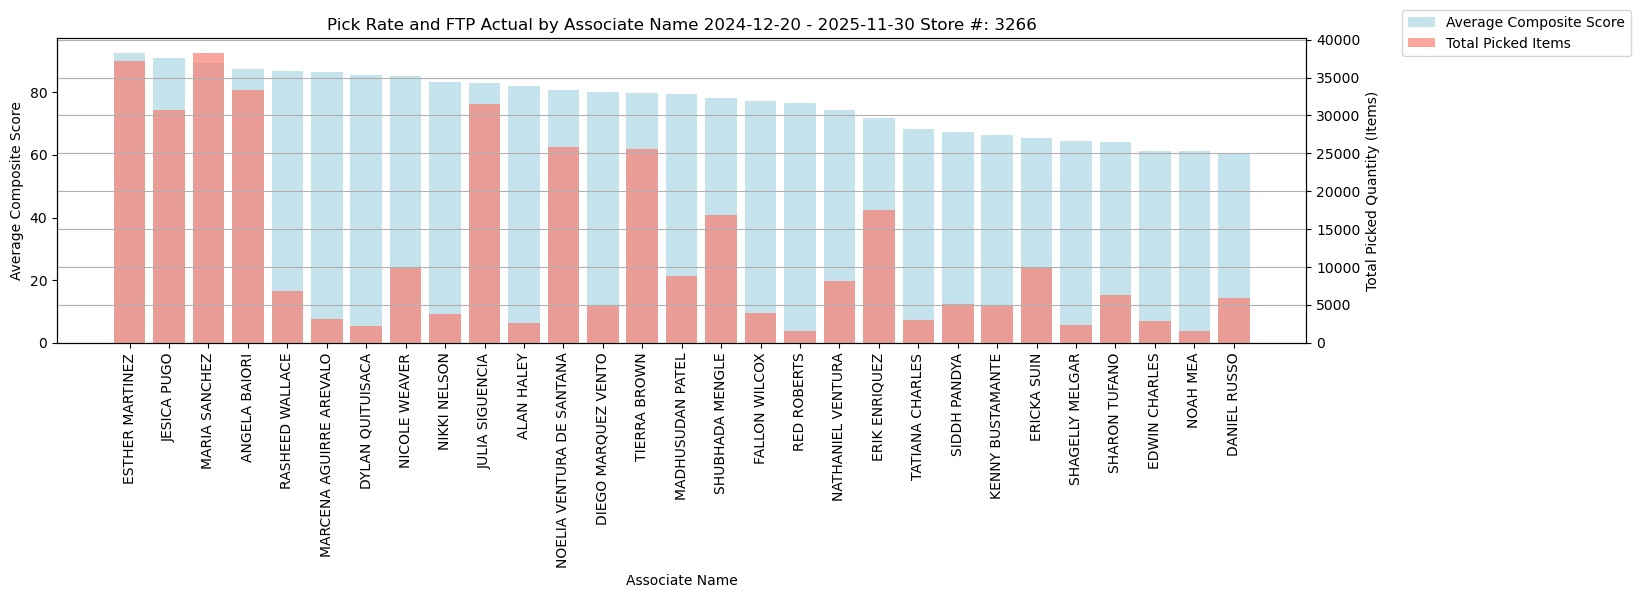

In [3977]:

# Plotting side-by-side bar plot for average Composite Score and total Picked As Req Qty
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['FTP Actual'] = pd.to_numeric(df['FTP Actual'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Composite Score'] = pd.to_numeric(df['Composite Score'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['FTP Actual'] = pd.to_numeric(df_selected_store['FTP Actual'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['Composite Score'] = pd.to_numeric(df_selected_store['Composite Score'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
#df_clean = df.dropna(subset=['Picked As Req Qty', 'Composite Score'])
df_clean = df_selected_store.dropna(subset=['FTP Actual', 'Composite Score']).copy()
if selected_store == 3266:
    df_clean = df_clean[df_clean['Associate'].apply(lambda x: x in associate_list_3266)]

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_composite_score = df_clean.groupby('Associate')['Composite Score'].mean().sort_values(ascending=False)
total_picked_qty = df_clean.groupby('Associate')['FTP Actual'].sum()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(14, 6))

# Convert Associate ID index to string for plotting
avg_composite_score.index = avg_composite_score.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_composite_score.index, avg_composite_score, color='lightblue', alpha=0.7, label='Average Composite Score')
ax1.set_xlabel('Associate Name')
ax1.set_ylabel('Average Composite Score')
ax1.set_title(f'Pick Rate and FTP Actual by Associate Name {oldest_pick_date} - {last_pick_date} Store #: {selected_store}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()


<h2>Compare Associate Composite Score LW to Average</h2>

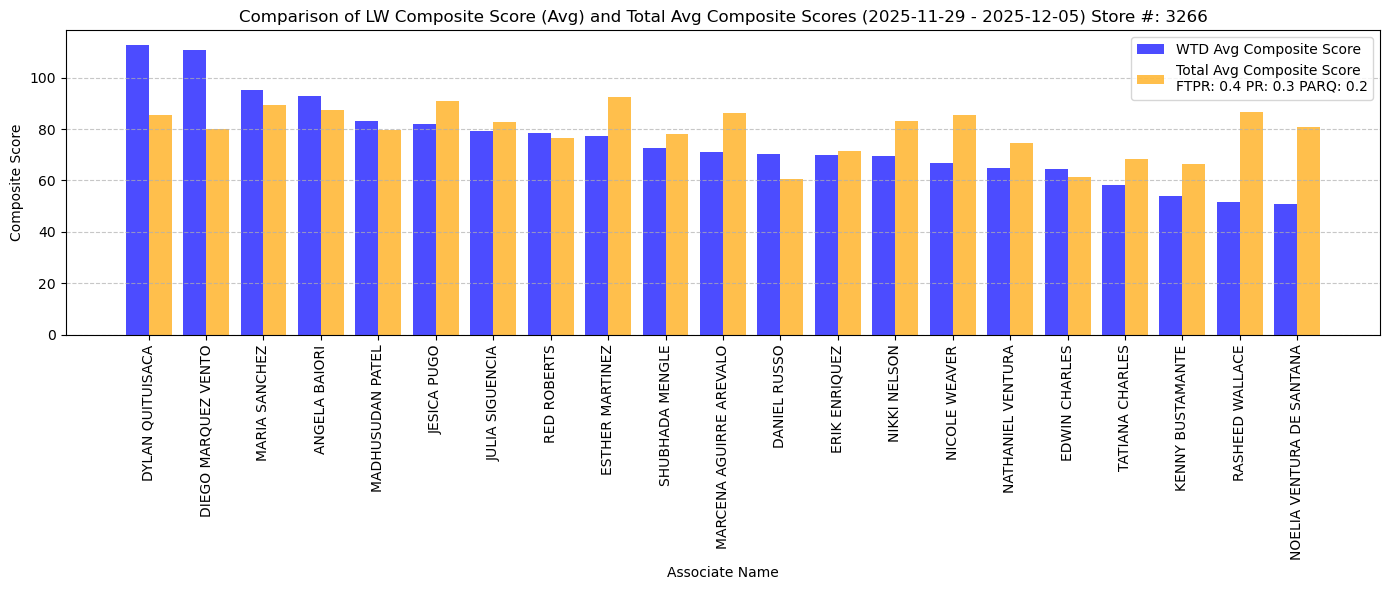

In [3978]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Define function to find the most recent full week
def get_last_full_week(df):
    """Returns the dataframe filtered for the most recent full week along with the week range."""
    last_full_week_start = df['Custom Week Start'].max()  # Start of the most recent full week
    last_full_week_end = df['Custom Week End'].max()  # End of the most recent full week

    # Filter for the most recent full week
    filtered_df = df[
        (df['Day of Pick Date'] >= last_full_week_start) &
        (df['Day of Pick Date'] <= last_full_week_end)
    ].copy()

    return filtered_df, last_full_week_start, last_full_week_end

# Step 2: Filter data for the most recent full week and get the week range
most_recent_week_data, last_full_week_start, last_full_week_end = get_last_full_week(df_clean)

# Fill NaN values in Composite Score and filter out associates with a score of 0
most_recent_week_data.loc[:, 'Composite Score'] = most_recent_week_data['Composite Score'].fillna(0)
most_recent_week_data = most_recent_week_data[most_recent_week_data['Composite Score'] > 0]

# Step 3: Calculate last week's and total average Composite Score (only for associates present last week)
last_week_avg_composite_score = (
    most_recent_week_data.groupby(['Associate'])['Composite Score']
    .mean()
)

# Filter df_clean to include only associates who had a score last week
df_clean_filtered = df_clean[df_clean['Associate'].isin(last_week_avg_composite_score.index)]

# Compute total average Composite Score (only for associates in last_week_avg_composite_score)
total_avg_composite_score = (
    df_clean_filtered.groupby(['Associate'])['Composite Score']
    .mean()
)

# Step 4: Merge both metrics into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'Last Week Avg Composite Score': last_week_avg_composite_score,
    'Total Avg Composite Score': total_avg_composite_score
})
comparison_df = comparison_df.sort_values(by="Last Week Avg Composite Score", ascending=False)

# Step 5: Plot comparison of last week's and total average Composite Scores
fig, ax = plt.subplots(figsize=(14, 6))

# Create side-by-side bar plot
width = 0.4  # Bar width
x = range(len(comparison_df.index))  # X-axis positions

ax.bar(
    [pos - width / 2 for pos in x],
    comparison_df['Last Week Avg Composite Score'],
    width=width,
    label='WTD Avg Composite Score',
    color='blue',
    alpha=0.7
)
ax.bar(
    [pos + width / 2 for pos in x],
    comparison_df['Total Avg Composite Score'],
    width=width,
    label=f'Total Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}',
    color='orange',
    alpha=0.7
)

# Add labels and title
ax.set_xlabel('Associate Name')
ax.set_ylabel('Composite Score')
ax.set_title(f'Comparison of LW Composite Score (Avg) and Total Avg Composite Scores ({last_full_week_start} - {last_full_week_end}) Store #: {selected_store}')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=90)

# Add a legend
ax.legend()

# Display grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<h2></h2>

<h2>Composite Score Comparison WTD (full week) to Average</h2>

associate_ids_this_week: ['AMAAN RAFI' 'DANIEL RUSSO' 'DANILO PANALES' 'DYLAN QUITUISACA'
 'WIJESIRI DESILVA' 'TATIANA CHARLES' 'SOHRAB ZARGHANISHIRAZ'
 'SILVIA ROCANO' 'SHUBHADA MENGLE' 'SCOTT SUAREZ' 'RED ROBERTS'
 'RASHEED WALLACE' 'PARUL PATEL' 'NATHANIEL VENTURA' 'MARIA SANCHEZ'
 'MARCENA AGUIRRE AREVALO' 'MAGDALENA GRIJALVA' 'JULIA SIGUENCIA'
 'JESICA PUGO' 'GABRIEL NYDICK' 'ESTHER MARTINEZ' 'ERIK ENRIQUEZ'
 'EDWIN CHARLES' 'NIKKI NELSON' 'NOELIA VENTURA DE SANTANA'
 'ANGELA BAIORI' 'CHRISTINA CUCITRO' 'DIEGO MARQUEZ VENTO' 'HLA WIN'
 'KENNY BUSTAMANTE' 'MADHUSUDAN PATEL' 'NICOLE WEAVER' 'YNGRID PENA SOSA']


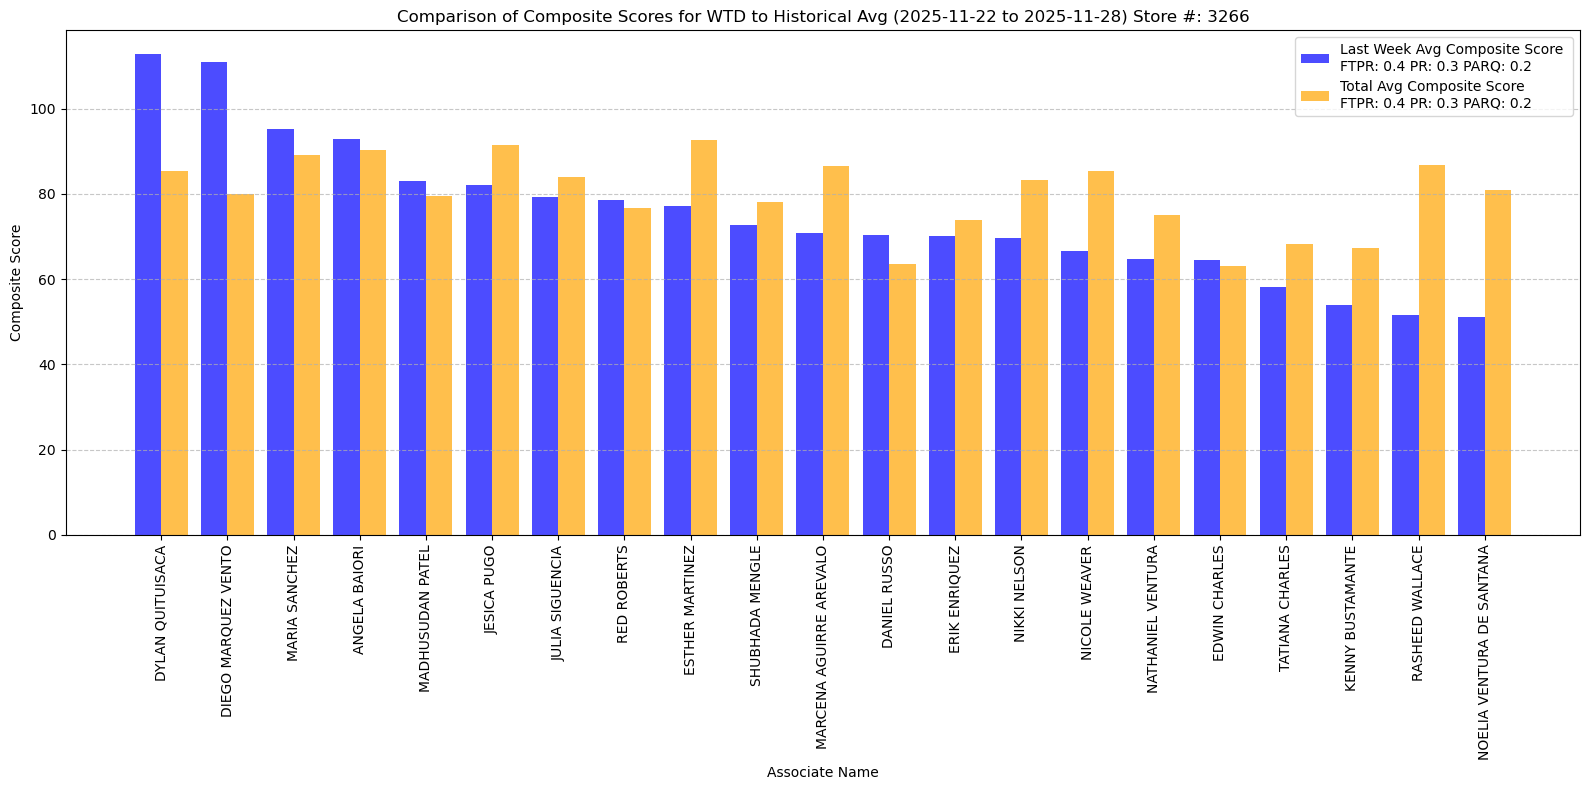

In [3979]:
import pandas as pd
import matplotlib.pyplot as plt

today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
df_selected_store = df[df['Store #'] == selected_store].copy()
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']).dt.date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End']).dt.date
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date']).dt.date

# Step 2: Filter for data in the current WTD week
# Assumes df contains 'Custom Week Start', 'Custom Week End', 'Day of Pick Date'
wtd_data = df_selected_store[
    (df_selected_store['Custom Week Start'].astype(str) <= today) &
    (df_selected_store['Custom Week End'].astype(str) >= today) &
    (df_selected_store['Day of Pick Date'].astype(str) <= today)  # ensure we only use data up to today
].copy()

if wtd_data.empty:
    print("No data available for the current week-to-date (WTD). Cannot proceed with analysis.")
else:    
    # Fill NaN values in 'Composite Score' (if any)
    wtd_data['Composite Score'] = wtd_data['Composite Score'].fillna(0)
    wtd_data = wtd_data[wtd_data['Composite Score'] > 0]  # Filter for Composite Score > 0

    # Step 6: Group by Associate ID and calculate average Composite Score for the last week
    avg_composite_score_last_week = (
        wtd_data.groupby('Associate')['Composite Score']
        .mean()
        .sort_values(ascending=False)
    )

    # Step 7: Filter total average Composite Score to include only Names in last_week_data
    associate_ids_this_week = wtd_data['Associate'].unique()  # Get unique Associate Names from last_week_data
    total_avg_composite_score = (
        df_selected_store[df_selected_store['Composite Score'] > 0]
        .groupby('Associate')['Composite Score']
        .mean()
        .loc[associate_ids_this_week]  # Filter to include only Associate Names from last_week_data
    )
    print(f'associate_ids_this_week: {associate_ids_this_week}')
    if selected_store == 3266:
        total_avg_composite_score = total_avg_composite_score[total_avg_composite_score.index.isin(associate_list_3266)]

    # Step 8: Merge both scores into a single DataFrame for proper alignment
    comparison_df = pd.DataFrame({
        'Last Week Avg Composite Score': avg_composite_score_last_week,
        'Total Avg Composite Score': total_avg_composite_score
    }).fillna(0)
    if selected_store == 3266:
        comparison_df = comparison_df[comparison_df.index.isin(associate_list_3266)]

    comparison_df = comparison_df.sort_values(by="Last Week Avg Composite Score", ascending=False)

    # Step 9: Visualization - Side-by-side bar chart
    fig, ax = plt.subplots(figsize=(16, 8))

    width = 0.4  # Bar width
    x = range(len(comparison_df.index))  # X-axis positions

    ax.bar(
        [pos - width / 2 for pos in x], 
        comparison_df['Last Week Avg Composite Score'], 
        width=width, 
        label=f'Last Week Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}', 
        color='blue', 
        alpha=0.7
    )

    ax.bar(
        [pos + width / 2 for pos in x], 
        comparison_df['Total Avg Composite Score'], 
        width=width, 
        label=f'Total Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}', 
        color='orange', 
        alpha=0.7
    )

    # Set labels and title
    ax.set_xlabel('Associate Name')
    ax.set_ylabel(f'Composite Score')
    ax.set_title(f'Comparison of Composite Scores for WTD to Historical Avg ({last_full_week}) Store #: {selected_store}')

    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df.index, rotation=90)

    # Add a legend
    ax.legend()

    # Display grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()


<h2>Comparison of Composite Score MTD compared to Last Month</h2>

In [3980]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get the current date and define month-to-date (MTD) and last full month
#today = pd.to_datetime("2025-01-31")
today = pd.to_datetime("today")
current_month = today.month
current_year = today.year

# Define last full month
if current_month == 1:
    last_month = 12
    last_month_year = current_year - 1
else:
    last_month = current_month - 1
    last_month_year = current_year

# Step 2: Filter data for MTD and last full month
df_selected_store['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Ensure Date column is in datetime format

# Month-to-Date (MTD) data
mtd_data = df_selected_store[
    (df_selected_store['Day of Pick Date'].dt.year == current_year) & 
    (df_selected_store['Day of Pick Date'].dt.month == current_month) & 
    (df_selected_store['Composite Score'] > 0)
]

# Last full month data
last_month_data = df_selected_store[
    (df_selected_store['Day of Pick Date'].dt.year == last_month_year) & 
    (df_selected_store['Day of Pick Date'].dt.month == last_month) & 
    (df_selected_store['Composite Score'] > 0)
]

# Step 3: Compute average composite scores for each Associate
avg_composite_score_mtd = mtd_data.groupby('Associate')['Composite Score'].mean()
if selected_store == 3266:
    avg_composite_score_mtd = avg_composite_score_mtd[avg_composite_score_mtd.index.isin(associate_list_3266)]
avg_composite_score_last_month = last_month_data.groupby('Associate')['Composite Score'].mean()
if selected_store == 3266:
    avg_composite_score_last_month = avg_composite_score_last_month[avg_composite_score_last_month.index.isin(associate_list_3266)]
is_empty = mtd_data['Composite Score'].count() == 0
# Step 4: Merge both scores into a single DataFrame for alignment
comparison_df = pd.DataFrame({
    'MTD Avg Composite Score': avg_composite_score_mtd,
    'Last Month Avg Composite Score': avg_composite_score_last_month
}).fillna(0)

if is_empty == True:
    print(f'No data for {current_month}/{current_year}')
else:
    # Step 5: Visualization - Side-by-side bar chart
    fig, ax = plt.subplots(figsize=(16, 8))
    
    width = 0.4  # Bar width
    x = range(len(comparison_df.index))  # X-axis positions
    
    ax.bar(
        [pos - width / 2 for pos in x], 
        comparison_df['MTD Avg Composite Score'], 
        width=width, 
        label=(f'MTD Avg Composite Score {current_month}/{current_year}'), 
        color='blue', 
        alpha=0.7
    )
    
    ax.bar(
        [pos + width / 2 for pos in x], 
        comparison_df['Last Month Avg Composite Score'], 
        width=width, 
        label=(f'Last Month Avg Composite Score {last_month}/{last_month_year}'), 
        color='orange', 
        alpha=0.7
    )
    
    # Set labels and title
    ax.set_xlabel('Associate Name')
    ax.set_ylabel('Composite Score')
    ax.set_title(f'Comparison of Composite Scores: MTD vs Last Full Month ({last_month}/{last_month_year}) Store #: {selected_store}')
    
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df.index, rotation=90)
    
    # Add a legend
    ax.legend()
    
    # Display grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


No data for 12/2025


<h2>Total Performance By Selected Month by Associate</h2>

In [3981]:
'''
# Extract Year, Month
df['Year'] = df['Day of Pick Date'].dt.year
df['Month'] = df['Day of Pick Date'].dt.month

# Compute the first day of the month for each row
df['First Day of Month'] = df['Day of Pick Date'].apply(lambda x: x.replace(day=1))

# Compute the week number of the first day of the month
df['First Week of Month'] = df['First Day of Month'].dt.isocalendar().week

# Compute the actual week of the month
df['Week of Month'] = df['Day of Pick Date'].dt.isocalendar().week - df['First Week of Month'] + 1

# Define the metrics and their aggregation type
metrics_agg = {
    'FTPR': 'mean',  # Average
    'Pick Rate': 'mean',  
    'Pick Hours': 'mean',  
    'Qty Req to Pick': 'sum',  # Sum
    'Picked As Req Qty': 'sum',
    'Substitution Qty': 'sum',
    'Nil Pick Qty': 'sum',
    'Exception Qty Req to Pick': 'sum'
}

df_selected_store = df[df['Store #'] == selected_store].copy()
# Group by Associate, Year, Month, and Week of Month, applying aggregation functions
weekly_aggregated = df_selected_store.groupby(['Associate', 'Year', 'Month', 'Week of Month'], as_index=False).agg(metrics_agg)

# Filter to ensure no previous month’s data spills over
weekly_aggregated = weekly_aggregated[weekly_aggregated['Week of Month'] > 0]

# Sort for proper plotting
weekly_aggregated = weekly_aggregated.sort_values(by=['Associate', 'Year', 'Month', 'Week of Month'])

# Debugging Step: Check if the grouping is correct
print(weekly_aggregated.head(10))  # Print first 10 rows to verify correctness

# Generate individual plots for each Associate
for associate in weekly_aggregated['Associate'].unique():
    associate_data = weekly_aggregated[weekly_aggregated['Associate'] == associate]

    plt.figure(figsize=(12, 6))

    # Plot each metric as a separate line
    for metric in metrics_agg.keys():
        plt.plot(associate_data['Week of Month'], associate_data[metric], marker='o', linestyle='-', label=metric)

    plt.xlabel('Week of Month')
    plt.ylabel('Value')
    plt.title(f'Weekly Metrics for Associate {associate}')
    plt.legend(loc='best', fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(associate_data['Week of Month'].unique())  # Ensure proper x-axis labels
    plt.tight_layout()
    
    plt.show()
    '''


"\n# Extract Year, Month\ndf['Year'] = df['Day of Pick Date'].dt.year\ndf['Month'] = df['Day of Pick Date'].dt.month\n\n# Compute the first day of the month for each row\ndf['First Day of Month'] = df['Day of Pick Date'].apply(lambda x: x.replace(day=1))\n\n# Compute the week number of the first day of the month\ndf['First Week of Month'] = df['First Day of Month'].dt.isocalendar().week\n\n# Compute the actual week of the month\ndf['Week of Month'] = df['Day of Pick Date'].dt.isocalendar().week - df['First Week of Month'] + 1\n\n# Define the metrics and their aggregation type\nmetrics_agg = {\n    'FTPR': 'mean',  # Average\n    'Pick Rate': 'mean',  \n    'Pick Hours': 'mean',  \n    'Qty Req to Pick': 'sum',  # Sum\n    'Picked As Req Qty': 'sum',\n    'Substitution Qty': 'sum',\n    'Nil Pick Qty': 'sum',\n    'Exception Qty Req to Pick': 'sum'\n}\n\ndf_selected_store = df[df['Store #'] == selected_store].copy()\n# Group by Associate, Year, Month, and Week of Month, applying aggrega

In [3982]:
max_date = df.loc[df['Associate'] == 'GABRIEL NYDICK', 'Day of Pick Date'].max()
df = df.drop_duplicates(subset=['Associate', 'Day of Pick Date'])
df[(df['Associate'] == 'GABRIEL NYDICK') & (df['Day of Pick Date'] == max_date)]

Store #       Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
119413     3266  GABRIEL NYDICK       2025-11-30 100.00          9.00        9.00      82.20        0.11               9.00                 0      0.00             0                         16                            1                        0.00                   15.00                     0                    0             9.00      g0n018d     178     11  2025              6      Sunday        2025-11-29      2025-12-05  2025-11-29 to 2025-12-05           2025         2026      FY2026           44                   11     December                   1     2024-12-20            66.47                        0            3.56          1           4.42      4.62            2.30              2.30

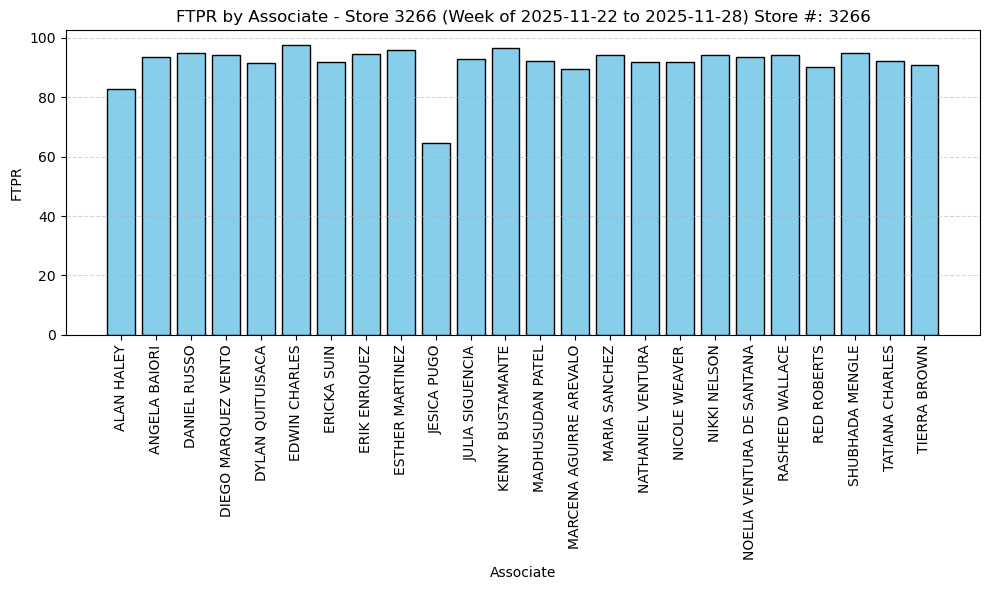

In [3983]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime format
#df['Custom Week End'] = pd.to_datetime(df['Custom Week End'])
#df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start'])

# Today reference
today = pd.Timestamp.today()
today = pd.to_datetime(datetime.now())
#today = dt.datetime.today()

# Get last full week end date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End'], errors='coerce')
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start'], errors='coerce')

last_full_week_end = df['Custom Week End'][df['Custom Week End'] < today].max()
last_full_week_start = df['Custom Week Start'][df['Custom Week End'] == last_full_week_end].max()

# Filter for selected store and last full week
df_selected_store = df.loc[df['Store #'] == selected_store].copy()
if selected_store == 3266:
    df_selected_store = df_selected_store[df_selected_store['Associate'].apply(lambda x: x in associate_list_3266)]

df_lw = df_selected_store[
    (df_selected_store['Custom Week End'] == last_full_week_end) |
    (df_selected_store['Custom Week Start'] == last_full_week_start)
]

# Group by Associate and calculate mean FTPR
ftp_summary = df_lw.groupby('Associate')['FTPR'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(ftp_summary['Associate'], ftp_summary['FTPR'], color='skyblue', edgecolor='black')

plt.title(f'FTPR by Associate - Store {selected_store} (Week of {last_full_week_start.date()} to {last_full_week_end.date()}) Store #: {selected_store}')
plt.xlabel('Associate')
plt.ylabel('FTPR')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<h1><b>Store/Market(combined avg) Fiscal Year Review</b></h1>

In [3984]:
show_market = False
selected_fiscal_year = 'FY2026'
selected_fiscal_year = df['Fiscal Year'].max()
print(f'Selected Fiscal Year: {selected_fiscal_year}')

Selected Fiscal Year: FY2026


In [3985]:
def export_to_pdf():
    print('does nothing yet')

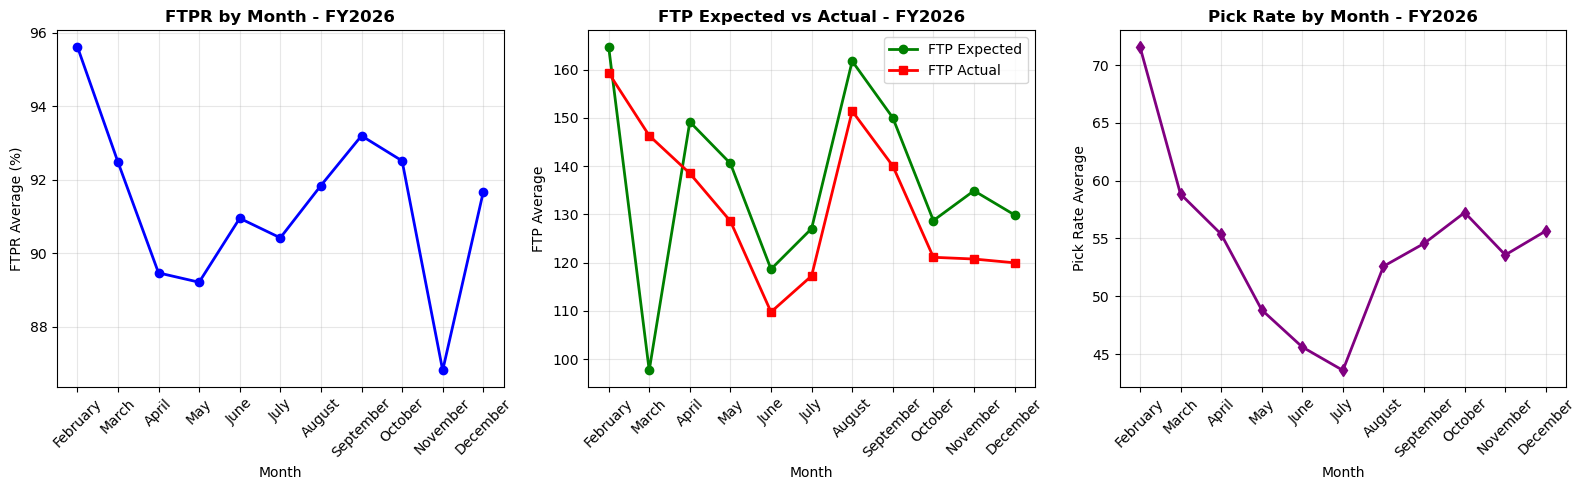

Monthly Averages for FY2026:
        Month  FTPR  FTP Expected  FTP Actual  Pick Rate
0    February 95.62        164.76      159.32      71.60
1       March 92.48         97.68      146.30      58.84
2       April 89.47        149.15      138.49      55.38
3         May 89.21        140.55      128.59      48.83
4        June 90.95        118.65      109.77      45.61
5        July 90.42        127.05      117.25      43.59
6      August 91.84        161.73      151.39      52.59
7   September 93.20        150.02      140.03      54.57
8     October 92.51        128.72      121.11      57.24
9    November 86.81        134.89      120.75      53.58
10   December 91.67        129.88      119.96      55.65


In [3986]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------- Filter for selected fiscal year/store ----------------
if show_market:
    df_fy = df[df['Fiscal Year'] == selected_fiscal_year].copy()
else:
    df_fy = df[df['Store #'] == selected_store].copy()
    if selected_store == 3266:
        df_fy = df_fy[df_fy['Associate'].isin(associate_list_3266)]
    df_fy = df_fy[df_fy['Fiscal Year'] == selected_fiscal_year].copy()

# Optional: remove duplicates by associate/day to avoid skew
df_fy = df_fy.drop_duplicates(subset=['Associate', 'Day of Pick Date'])

# ---------------- Compute weekly averages ----------------
weekly_avg = df_fy.groupby('Fiscal Week').agg({
    'FTPR': 'mean',
    'FTP Expected': 'mean',
    'FTP Actual': 'mean',
    'Pick Rate': 'mean'
}).reset_index()

# ---------------- 4-5-4 calendar mapping ----------------
weeks_per_month = [4,5,4]*4  # 12 months in 4-5-4 pattern
month_end_week = np.cumsum(weeks_per_month)

def fiscal_month_from_week(week):
    # Cap week 53 to last month (January)
    if week > month_end_week[-1]:
        return 12
    else:
        return np.searchsorted(month_end_week, week) + 1

weekly_avg['Fiscal Month Number'] = weekly_avg['Fiscal Week'].apply(fiscal_month_from_week)

# Map fiscal month number to names
month_names = {
    1:'February', 2:'March', 3:'April',
    4:'May', 5:'June', 6:'July',
    7:'August', 8:'September', 9:'October',
    10:'November', 11:'December', 12:'January'
}
weekly_avg['Month'] = weekly_avg['Fiscal Month Number'].map(month_names)

# ---------------- Aggregate weekly averages to monthly ----------------
monthly_avg = weekly_avg.groupby('Fiscal Month Number').agg({
    'FTPR':'mean',
    'FTP Expected':'mean',
    'FTP Actual':'mean',
    'Pick Rate':'mean'
}).reset_index()
monthly_avg['Month'] = monthly_avg['Fiscal Month Number'].map(month_names)

# ---------------- Plots ----------------
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: FTPR
axes[0].plot(monthly_avg['Month'], monthly_avg['FTPR'], marker='o', color='blue', linewidth=2)
axes[0].set_title(f'FTPR by Month - {selected_fiscal_year}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('FTPR Average (%)')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: FTP Expected vs FTP Actual
axes[1].plot(monthly_avg['Month'], monthly_avg['FTP Expected'], marker='o', label='FTP Expected', color='green', linewidth=2)
axes[1].plot(monthly_avg['Month'], monthly_avg['FTP Actual'], marker='s', label='FTP Actual', color='red', linewidth=2)
axes[1].set_title(f'FTP Expected vs Actual - {selected_fiscal_year}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('FTP Average')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Pick Rate
axes[2].plot(monthly_avg['Month'], monthly_avg['Pick Rate'], marker='d', color='purple', linewidth=2)
axes[2].set_title(f'Pick Rate by Month - {selected_fiscal_year}', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Pick Rate Average')
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ---------------- Print monthly averages ----------------
print(f"Monthly Averages for {selected_fiscal_year}:")
print(monthly_avg[['Month', 'FTPR', 'FTP Expected', 'FTP Actual', 'Pick Rate']])


In [3987]:
df_fy[df_fy['Fiscal Month Number']==2].groupby('Fiscal Week').agg({
    'FTP Expected': ['mean', 'count'],
    'FTPR': 'mean',
    'Pick Rate': 'mean'
})
df_fy[df_fy['Fiscal Week'] == 7]


Store #                  Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
116053     3266  NOELIA VENTURA DE SANTANA       2025-03-10  83.74          0.00      118.00      61.00        1.95             118.00                 1      0.00             6                          0                            0                        0.00                    0.00                   123                  103             0.00      n0v03hh     178      3  2025              0      Monday        2025-03-08      2025-03-14  2025-03-08 to 2025-03-14           2025         2026      FY2026            7                    2        March                   0     2024-12-20            75.59                        0            0.00          0           4.13      4.44            4.78              0.00
116045     3266              ANGELA BAIORI       2025-03-10 100.00          0.00       20.00     107.90        0.19              20.00                 0      0.00             0                          0                            0                        0.00                    0.00                    20                   20             0.00      a0b0ad9     178      3  2025              0      Monday        2025-03-08      2025-03-14  2025-03-08 to 2025-03-14           2025         2026      FY2026            7                    2        March                   0     2024-12-22            76.39                        0            0.00          0           4.69      4.62            3.04              0.00
116052     3266                JESICA PUGO       2025-03-10  86.02          0.00      346.00      68.10        5.11             346.00                 2      0.00            19                          8                            0                        8.00                    0.00                   372                  320             0.00      j0p0vpl     178      3  2025              0      Monday        2025-03-08      2025-03-14  2025-03-08 to 2025-03-14           2025         2026      FY2026            7                    2        March                   1     2024-12-20           124.55                        0     16000000.00          0           4.24      4.47            5.85              0.00
116056     3266              SHARON TUFANO       2025-03-10  97.37          0.00       74.00      25.20        2.98              74.00                 1      0.00             2                          0                            0                        0.00                    0.00                    76                   74             0.00      stufano     178      3  2025              0      Monday        2025-03-08      2025-03-14  2025-03-08 to 2025-03-14           2025         2026      FY2026            7                    2        March                   0     2024-12-20            61.61                        0            0.00          0           3.27      4.59            4.32              0.00
116057     3266               TIERRA BROWN       2025-03-10  89.83          0.00       53.00      47.30        1.12              53.00                 0      0.00            16                          1                            0                        0.00                    1.00                    59                   53             0.00      t0b0hm5     178      3  2025              0      Monday        2025-03-08     

<h1><b>Associate Fiscal Year Review</b></h1>

Associates found: ['JULIA SIGUENCIA' 'SIDDH PANDYA' 'MARIA SANCHEZ' 'SHARON TUFANO'
 'NATHANIEL VENTURA' 'DANIEL RUSSO' 'NOELIA VENTURA DE SANTANA'
 'ESTHER MARTINEZ' 'JESICA PUGO' 'TIERRA BROWN' 'ANGELA BAIORI'
 'SHUBHADA MENGLE' 'ERIK ENRIQUEZ' 'ERICKA SUIN' 'RASHEED WALLACE'
 'NICOLE WEAVER' 'KENNY BUSTAMANTE' 'FALLON WILCOX' 'NOAH MEA'
 'SHAGELLY MELGAR' 'MADHUSUDAN PATEL' 'TATIANA CHARLES'
 'DIEGO MARQUEZ VENTO' 'EDWIN CHARLES' 'NIKKI NELSON' 'ALAN HALEY'
 'MARCENA AGUIRRE AREVALO' 'DYLAN QUITUISACA' 'RED ROBERTS'], total: 29
associate: JULIA SIGUENCIA | ID: jrsigue


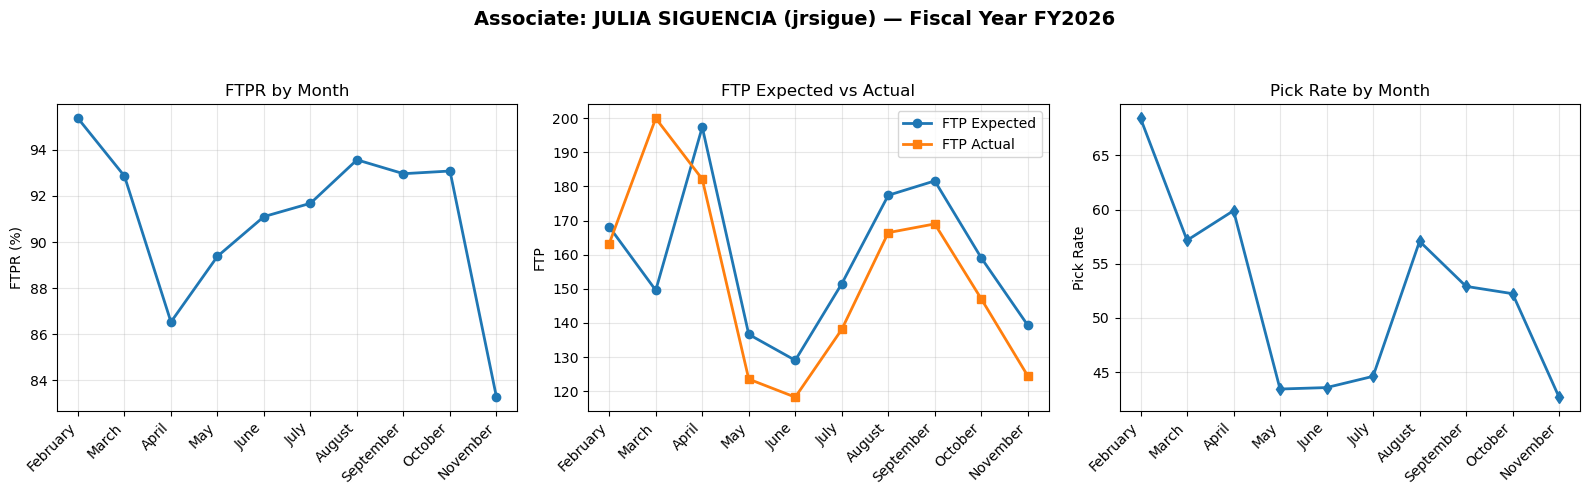


Monthly Averages for Associate JULIA SIGUENCIA (jrsigue) — FY FY2026
       Month  FTPR  FTP Expected  FTP Actual  Pick Rate
0   February 95.37        168.16      163.26      68.42
1      March 92.86        149.56      199.94      57.16
2      April 86.53        197.35      182.12      59.90
3        May 89.38        136.65      123.55      43.45
4       June 91.10        129.05      118.26      43.58
5       July 91.68        151.47      138.11      44.62
6     August 93.57        177.39      166.44      57.07
7  September 92.97        181.60      169.00      52.91
8    October 93.08        159.05      147.05      52.24
9   November 83.26        139.32      124.47      42.69

Predicted FTPR, Pick Rate, FTP Actual for JULIA SIGUENCIA (jrsigue):

Predicted Performance by Month:
      Month  Predicted FTPR  Predicted Pick Rate  Predicted FTP Actual
0  February           94.94                79.58                174.49

--------------------------------------------------------------------

In [3988]:
#average out each month the associate worked, graph each month for FTPR, Pick Rate and FTP Actual
#display averages/sum under each graph
#export averages/sum and graph(s) to pdf
#export FY average/sum to pdf
#optional: include predicted performance based on fiscal year
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

test = True

if show_market:
    df_fy = df[df['Fiscal Year'] == selected_fiscal_year].copy()
else:
    df_selected_store = df[df['Store #'] == selected_store].copy().drop_duplicates()
    if selected_store == 3266:
        df_selected_store = df_selected_store[df_selected_store['Associate'].apply(lambda x: x in associate_list_3266)]
    df_fy = df_selected_store[df_selected_store['Fiscal Year'] == selected_fiscal_year].copy()


df_fy['Day of Pick Date'] = pd.to_datetime(df_fy['Day of Pick Date'], errors='coerce')
month_of_year = df_fy['Day of Pick Date'].dt.month

df_fy['Fiscal Month'] = np.where(
    month_of_year >= 2,
    month_of_year - 1,      # Feb=1, Mar=2, … Dec=11
    month_of_year + 11      # Jan=12
)

# Month names for display
month_names = {
    1: 'February', 2: 'March', 3: 'April', 4: 'May', 5: 'June', 6: 'July',
    7: 'August', 8: 'September', 9: 'October', 10: 'November', 11: 'December',
    12: 'January'
}

df_fy['Month'] = df_fy['Fiscal Month'].map(month_names)

associates = df_fy['Associate'].dropna().unique()

print(f"Associates found: {associates}, total: {len(associates)}")




count = 0
for associate in associates:
    monthly_avg = (
        df_a.groupby('Fiscal Month')
        .agg({
            'FTPR': 'mean',
            'FTP Expected': 'mean',
            'FTP Actual': 'mean',
            'Pick Rate': 'mean'
        })
        .reset_index()
        .sort_values('Fiscal Month')
    )

    monthly_avg['Month'] = monthly_avg['Fiscal Month'].map(month_names)
    if use_cpu_models:

        # Choose correct dataset based on market/store mode
        if predict_market:
            df_source = df[df['Associate'] == associate].copy()
        else:
            df_source = df_selected_store[df_selected_store['Associate'] == associate].copy()

        # Predict
        X_associate = df_source[feature_cols]
        X_associate_scaled = preprocessor.transform(X_associate)

        df_source['Predicted FTPR'] = best_model_ftpr.predict(X_associate_scaled)
        df_source['Predicted Pick Rate'] = best_model_pick_rate.predict(X_associate_scaled)
        df_source['Predicted FTP Actual'] = best_model_picked_as_req_qty.predict(X_associate_scaled)
        df_source['Day of Pick Date'] = pd.to_datetime(df_a['Day of Pick Date'], errors='coerce')

        # Compute monthly predicted averages
        predicted_monthly = (
            df_source
            .assign(Fiscal_Month=df_source['Day of Pick Date'].dt.month.pipe(
                lambda m: np.where(m>=2, m-1, m+11)
            ))
            .groupby('Fiscal_Month')
            .agg({
                'Predicted FTPR': 'mean',
                'Predicted Pick Rate': 'mean',
                'Predicted FTP Actual': 'mean'
            })
        ).reset_index()

        predicted_monthly['Month'] = predicted_monthly['Fiscal_Month'].map(month_names)
    if test:
        count += 1
    if count == 2:
        break
    df_a = df_fy[df_fy['Associate'] == associate].copy()
    associate_id = df_fy[df_fy['Associate'] == associate]['Associate ID'].iloc[0]
    print(f'associate: {associate} | ID: {associate_id}')

    # Group by fiscal month for that associate
    monthly_avg = (
        df_a.groupby('Fiscal Month')
        .agg({
            'FTPR': 'mean',
            'FTP Expected': 'mean',
            'FTP Actual': 'mean',
            'Pick Rate': 'mean'
        })
        .reset_index()
        .sort_values('Fiscal Month')
    )

    monthly_avg['Month'] = monthly_avg['Fiscal Month'].map(month_names)


    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(f"Associate: {associate} ({associate_id}) — Fiscal Year {selected_fiscal_year}", fontsize=14, fontweight='bold')

    # Plot 1 — FTPR
    axes[0].plot(monthly_avg['Fiscal Month'], monthly_avg['FTPR'],
                 marker='o', linewidth=2)
    axes[0].set_title('FTPR by Month')
    axes[0].set_xticks(monthly_avg['Fiscal Month'])
    axes[0].set_xticklabels(monthly_avg['Month'], rotation=45, ha='right')
    axes[0].set_ylabel('FTPR (%)')
    axes[0].grid(True, alpha=0.3)

    # Plot 2 — FTP Expected vs Actual
    axes[1].plot(monthly_avg['Fiscal Month'], monthly_avg['FTP Expected'],
                 marker='o', label='FTP Expected', linewidth=2)
    axes[1].plot(monthly_avg['Fiscal Month'], monthly_avg['FTP Actual'],
                 marker='s', label='FTP Actual', linewidth=2)
    axes[1].set_title('FTP Expected vs Actual')
    axes[1].set_xticks(monthly_avg['Fiscal Month'])
    axes[1].set_xticklabels(monthly_avg['Month'], rotation=45, ha='right')
    axes[1].set_ylabel('FTP')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Plot 3 — Pick Rate
    axes[2].plot(monthly_avg['Fiscal Month'], monthly_avg['Pick Rate'],
                 marker='d', linewidth=2)
    axes[2].set_title('Pick Rate by Month')
    axes[2].set_xticks(monthly_avg['Fiscal Month'])
    axes[2].set_xticklabels(monthly_avg['Month'], rotation=45, ha='right')
    axes[2].set_ylabel('Pick Rate')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

    # ---- Optional: Print the underlying monthly averages ----
    print(f"\nMonthly Averages for Associate {associate} ({associate_id}) — FY {selected_fiscal_year}")
    print(monthly_avg[['Month', 'FTPR', 'FTP Expected', 'FTP Actual', 'Pick Rate']])
    print(f'\nPredicted FTPR, Pick Rate, FTP Actual for {associate} ({associate_id}):')
    if use_cpu_models:
        print("\nPredicted Performance by Month:")
        predicted_monthly[['Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']] = predicted_monthly[['Predicted FTPR', 'Predicted Pick Rate', 'Predicted FTP Actual']].round(2)
        print(predicted_monthly[['Month', 'Predicted FTPR',
                                 'Predicted Pick Rate',
                                 'Predicted FTP Actual']])

    
    print("\n" + "-" * 80 + "\n")


<h1>Graph LW FTPR by Associate for each day worked</h1>

Last full week end date: 2025-11-28
Last full week start date: 2025-11-22


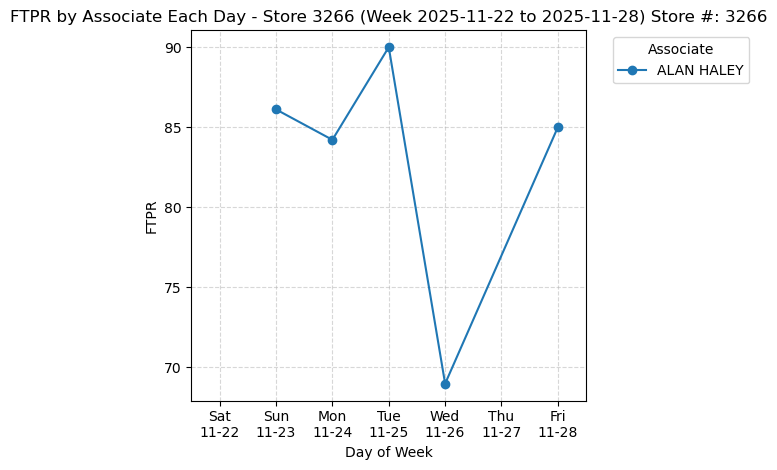

        Store #   Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
123923     3266  ALAN HALEY       2025-11-23 86.11         36.00       31.00      76.60        0.40              31.00                 0      0.00             4                          0                            0                        0.00                    0.00                     0          

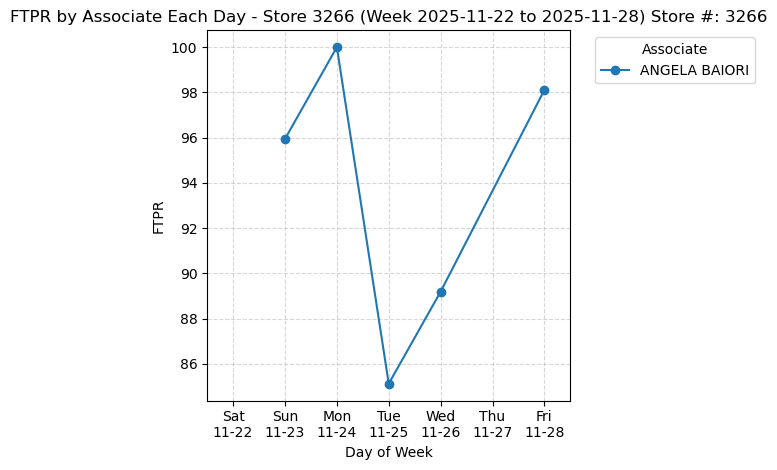

        Store #      Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
123924     3266  ANGELA BAIORI       2025-11-23  95.94        197.00      189.00      36.10        5.46             189.00                 8      0.00             4                          5                            1                        0.00                    4.00                     0  

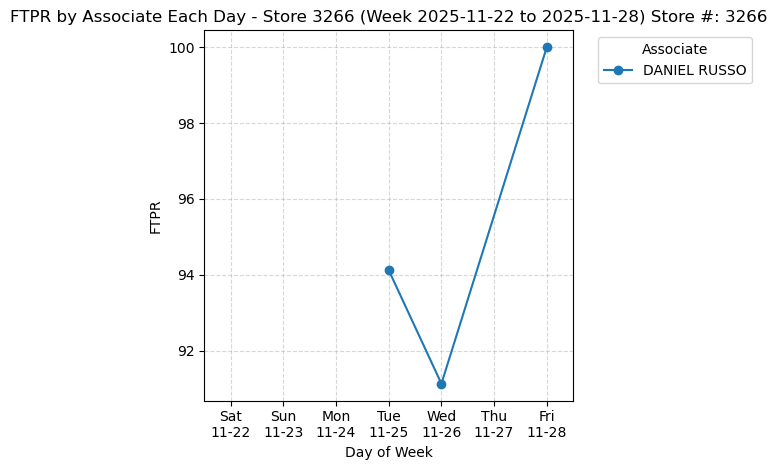

        Store #     Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
121880     3266  DANIEL RUSSO       2025-11-25  94.12         17.00       16.00      35.60        0.45              16.00                 0      0.00             1                          0                            0                        0.00                    0.00                     0    

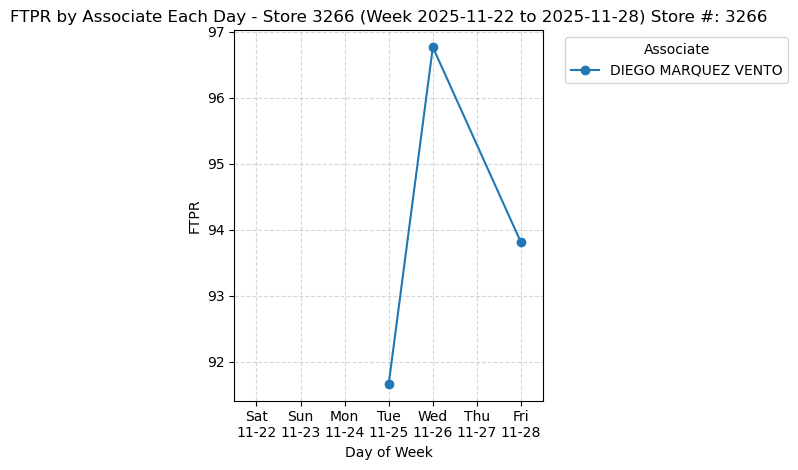

        Store #            Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
121883     3266  DIEGO MARQUEZ VENTO       2025-11-25 91.67        180.00      165.00      42.40        4.03             165.00                 6      0.00            19                          0                            0                        0.00                    0.00              

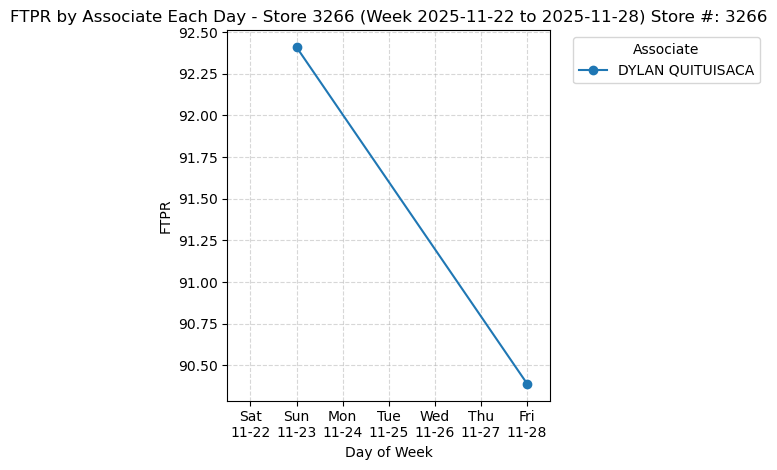

        Store #         Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
123925     3266  DYLAN QUITUISACA       2025-11-23 92.41        369.00      341.00      61.80        5.93             343.00                23      0.00             7                          0                            0                        0.00                    0.00                    

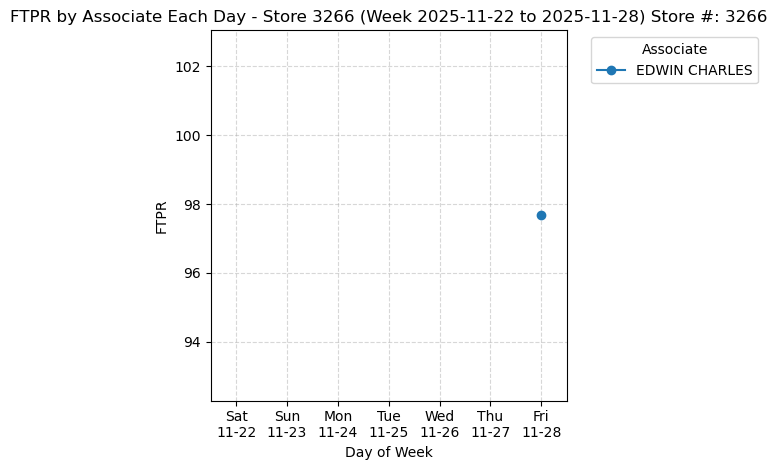

        Store #      Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120459     3266  EDWIN CHARLES       2025-11-28 97.67         86.00       84.00      52.50        1.62              84.00                 1      0.00             1                          1                            1                        0.00                    0.00                     0    

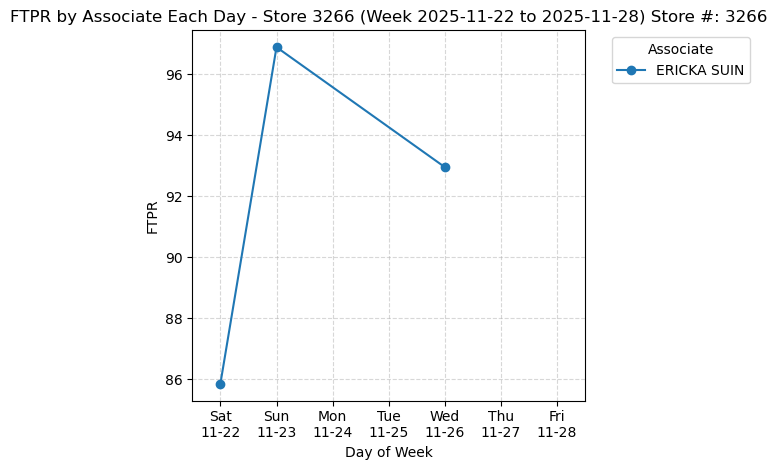

        Store #    Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
124598     3266  ERICKA SUIN       2025-11-22 85.86        191.00      164.00      67.90        2.64             164.00                15      0.00             9                          0                            0                        0.00                    0.00                     0        

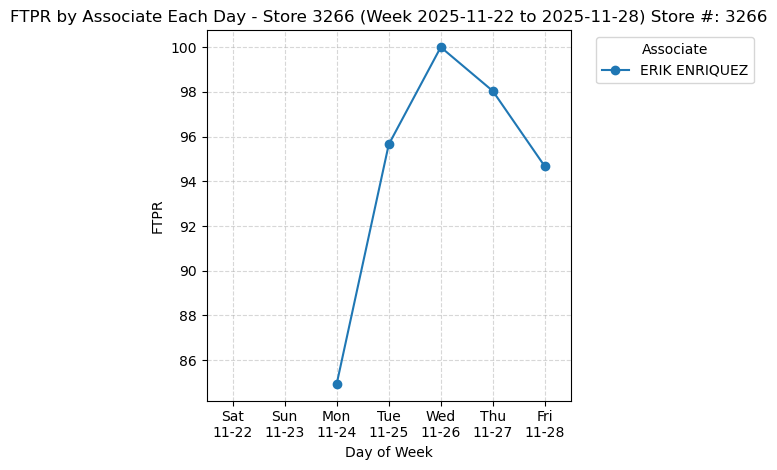

        Store #      Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
123160     3266  ERIK ENRIQUEZ       2025-11-24  84.95         93.00       79.00      87.10        0.91              79.00                 0      0.00            11                          3                            1                        0.00                    2.00                     0  

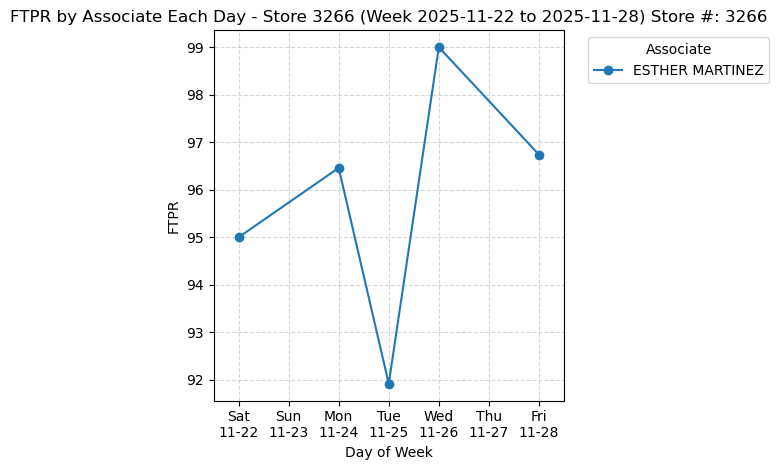

        Store #        Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
124599     3266  ESTHER MARTINEZ       2025-11-22 95.00        200.00      190.00      47.30        4.19             194.00                 4      0.00            14                          0                            0                        0.00                    0.00                     0

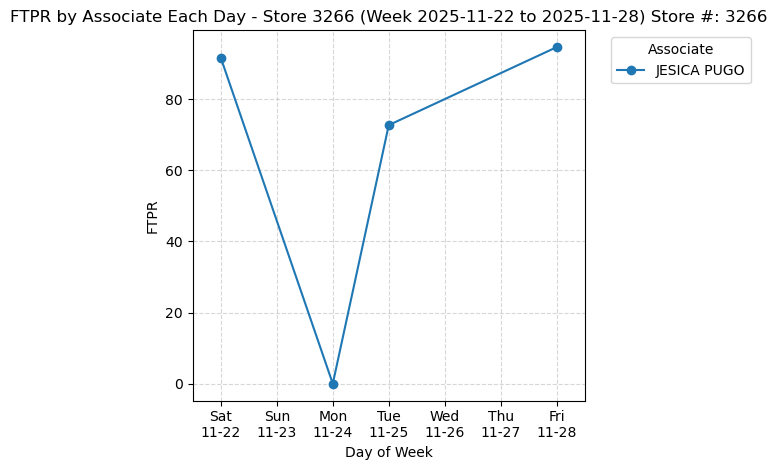

        Store #    Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
124601     3266  JESICA PUGO       2025-11-22 91.55        213.00      195.00      48.00        4.27             195.00                10      0.00             9                          0                            0                        0.00                    0.00                     0        

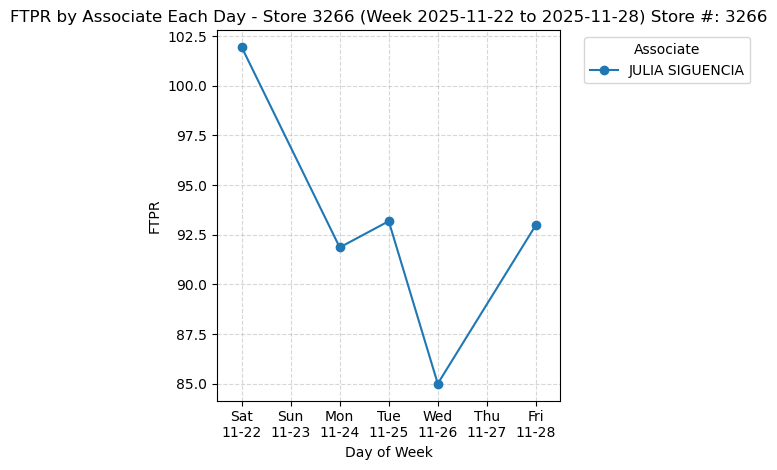

        Store #        Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
124602     3266  JULIA SIGUENCIA       2025-11-22 101.94        155.00      158.00      46.80        3.50             159.00                 5      0.00             4                         19                            0                       19.00                    0.00                    

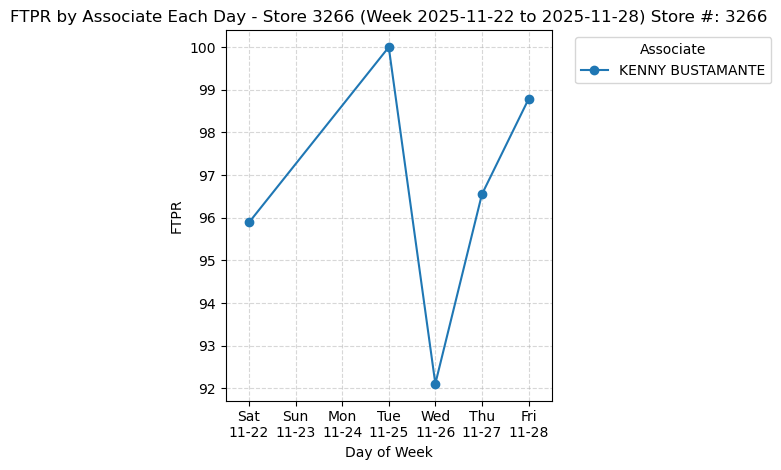

        Store #         Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
124603     3266  KENNY BUSTAMANTE       2025-11-22  95.89         73.00       70.00      41.50        1.71              70.00                 1      0.00             2                          0                            0                        0.00                    0.00                  

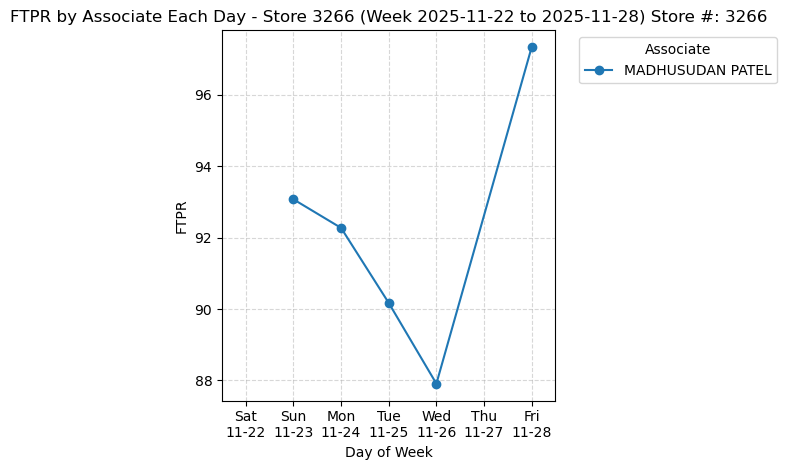

        Store #         Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
123928     3266  MADHUSUDAN PATEL       2025-11-23 93.07        274.00      255.00      45.20        6.00             266.00                 5      0.00             3                          0                            0                        0.00                    0.00                    

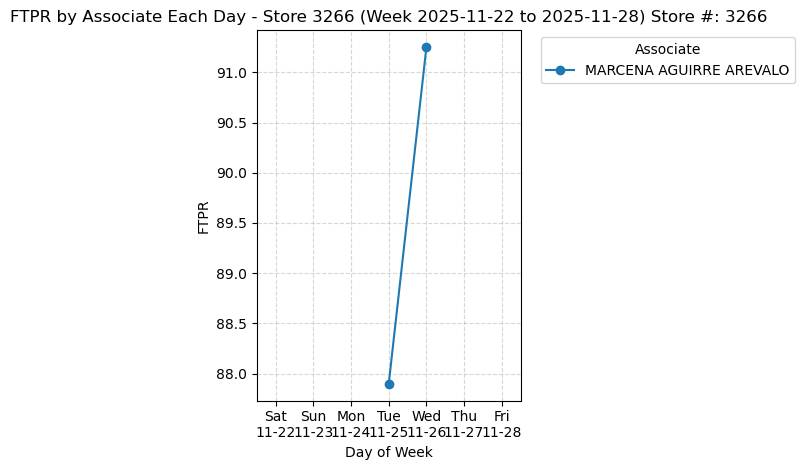

        Store #                Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
121891     3266  MARCENA AGUIRRE AREVALO       2025-11-25 87.90        124.00      109.00      50.30        2.37             116.00                 3      0.00            12                          0                            0                        0.00                    0.00      

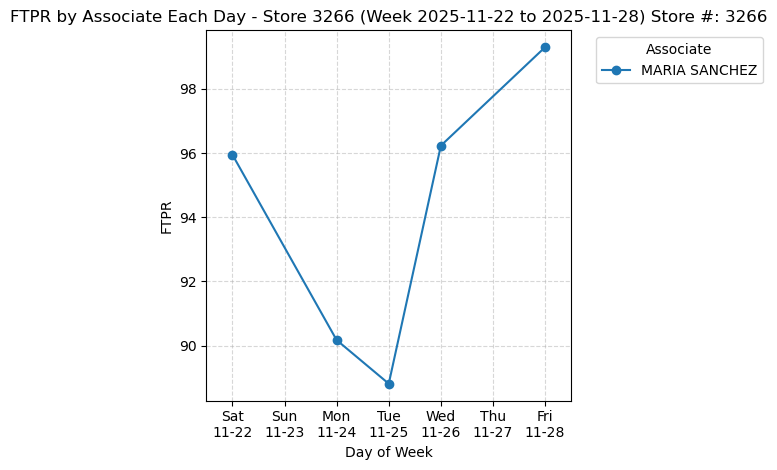

        Store #      Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
124604     3266  MARIA SANCHEZ       2025-11-22 95.95        321.00      308.00      55.20        5.78             310.00                 9      0.00             2                          0                            0                        0.00                    0.00                     0    

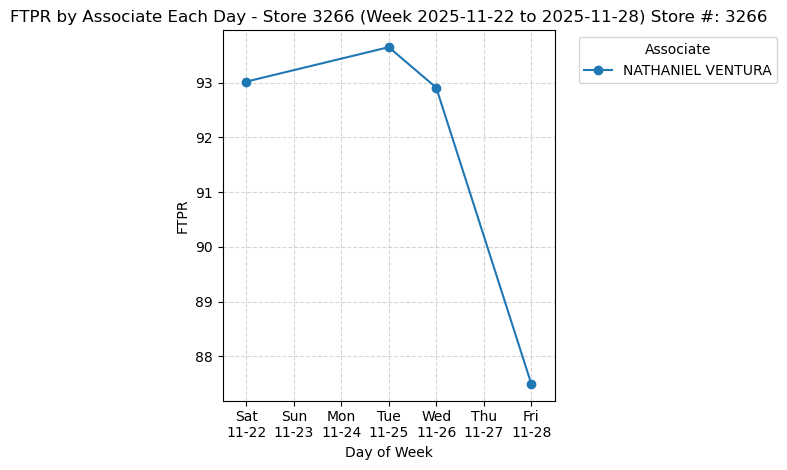

        Store #          Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
124605     3266  NATHANIEL VENTURA       2025-11-22 93.02         86.00       80.00      58.10        1.45              80.00                 4      0.00             2                          0                            0                        0.00                    0.00                  

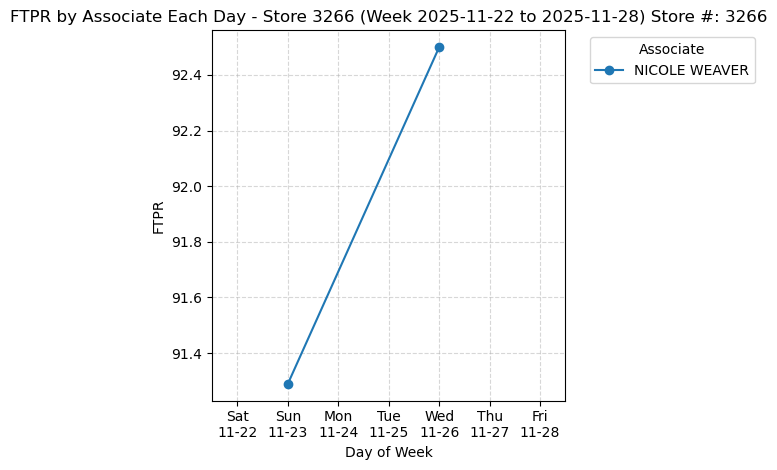

        Store #      Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
123929     3266  NICOLE WEAVER       2025-11-23 91.29        310.00      283.00      69.00        4.20             284.00                 6      0.00            21                          0                            0                        0.00                    0.00                     0    

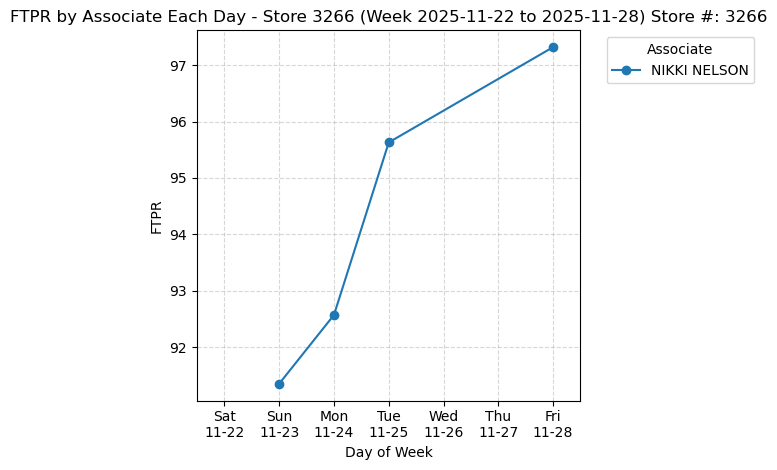

        Store #     Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
123930     3266  NIKKI NELSON       2025-11-23 91.35        185.00      169.00      62.00        2.94             169.00                13      0.00             4                          0                            0                        0.00                    0.00                     0      

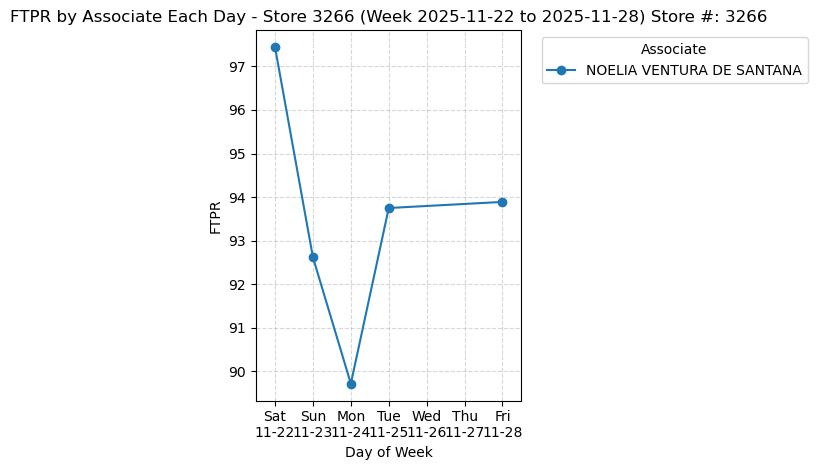

        Store #                  Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
124606     3266  NOELIA VENTURA DE SANTANA       2025-11-22 97.44         39.00       38.00      86.00        0.44              38.00                 0      0.00             1                          0                            0                        0.00                    0.00  

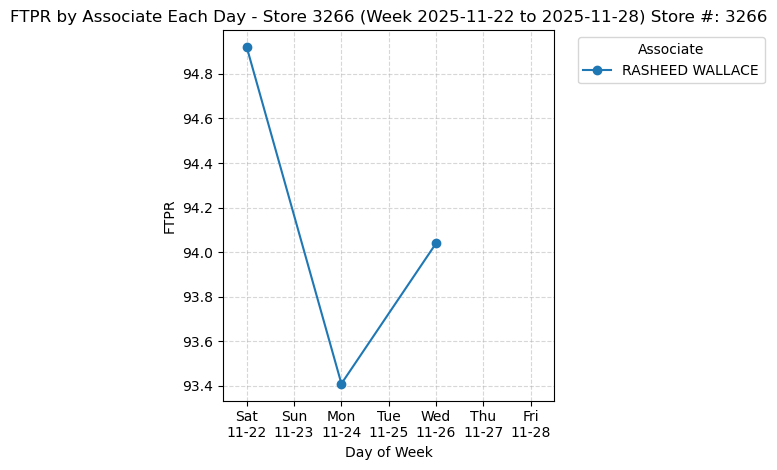

        Store #        Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
124608     3266  RASHEED WALLACE       2025-11-22 94.92        315.00      299.00      81.50        3.68             299.00                 1      0.00            20                          0                            0                        0.00                    0.00                     0

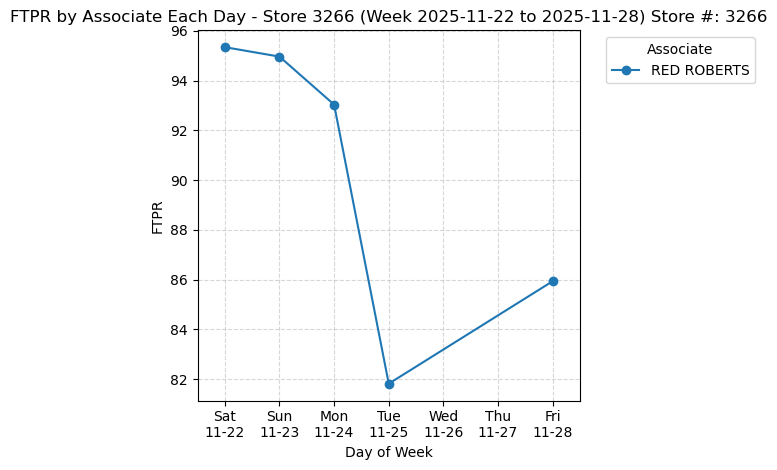

        Store #    Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
124609     3266  RED ROBERTS       2025-11-22 95.35        129.00      123.00      40.80        3.16             123.00                 6      0.00             1                          3                            0                        0.00                    3.00                     0        

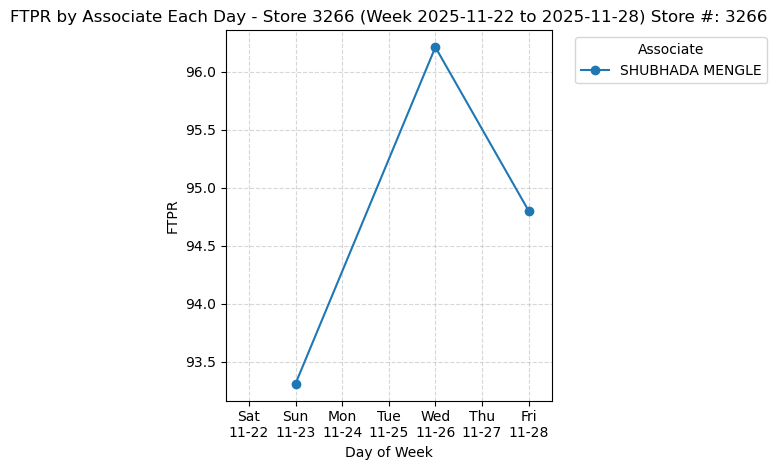

        Store #        Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
123934     3266  SHUBHADA MENGLE       2025-11-23 93.31        299.00      279.00      49.10        6.09             279.00                20      0.00             2                          0                            0                        0.00                    0.00                     0

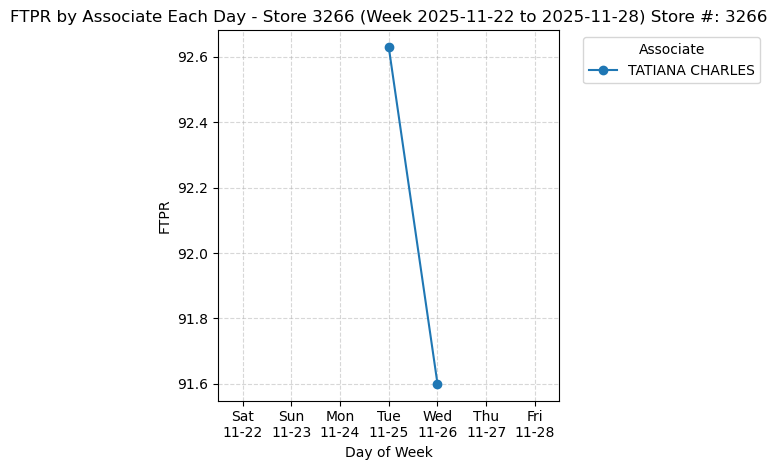

        Store #        Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
121899     3266  TATIANA CHARLES       2025-11-25 92.63         95.00       88.00      75.30        1.18              88.00                 1      0.00            12                          3                            2                        0.00                    1.00                     0

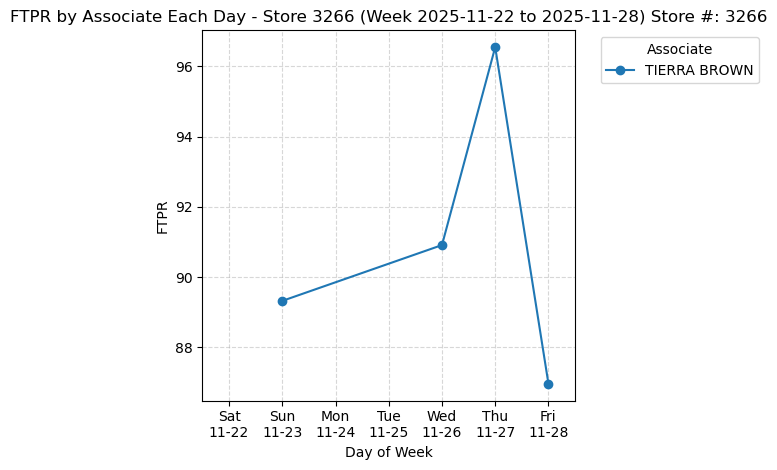

        Store #     Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
123935     3266  TIERRA BROWN       2025-11-23 89.32        103.00       92.00      56.30        1.65              92.00                 1      0.00            11                          0                            0                        0.00                    0.00                     0      

In [3989]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime format
#df['Custom Week End'] = pd.to_datetime(df['Custom Week End'])
#df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start'])
# Convert specific columns to datetime
df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start'], errors='coerce')
df['Custom Week End'] = pd.to_datetime(df['Custom Week End'], errors='coerce')
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'], errors='coerce')
# Today reference
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")

# Get last full week end date
last_full_week_end = df['Custom Week End'][df['Custom Week End'] < today].max()
print(f"Last full week end date: {last_full_week_end.date()}")
last_full_week_start = df['Custom Week Start'][df['Custom Week End'] == last_full_week_end].max()
print(f"Last full week start date: {last_full_week_start.date()}") 

# Filter for selected store and last full week
df_selected_store = df.loc[df['Store #'] == selected_store].copy()
if selected_store == 3266:
    df_selected_store = df_selected_store[df_selected_store['Associate'].apply(lambda x: x in associate_list_3266)]

# Filter for last full week (all days in that week)
df_lw = df_selected_store[
    (df_selected_store['Custom Week Start'] == last_full_week_start) &
    (df_selected_store['Custom Week End'] == last_full_week_end)
]

# Sort by Associate and Day of Pick Date for plotting
df_lw = df_lw.sort_values(['Associate', 'Day of Pick Date'])

# Set full week for consistent x-axis
week_start = df_lw['Day of Pick Date'].min().normalize()
week_dates = pd.date_range(start=week_start, periods=7, freq='D')
week_of_interest = df_lw['Week'].max()


'''# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(18, 10))
df_lw['FTPR'].index = df_lw['FTPR'].astype(str)
df_lw['FTP Actual'].index = df_lw['FTP Actual'].astype(str)

ax1.plot(df_lw['Day of Pick Date'], df_lw['FTPR'], marker='o', color='blue', label='FTPR')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('FTPR')
ax1.set_title(f'FTPR by Associate Each Day - Store {selected_store} (Week {week_of_interest}) Store #: {selected_store}')
ax1.set_xticks(week_dates)
ax1.set_xticklabels([d.strftime('%a\n%m-%d') for d in week_dates])  # e.g., Mon\n05-13
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.grid(axis='x', linestyle='--', alpha=0.5)
# Add padding to the left and right
left_pad = pd.Timedelta(days=0.5)
right_pad = pd.Timedelta(days=0.5)
ax1.set_xlim(week_dates.min() - left_pad, week_dates.max() + right_pad)
ax1.legend(title='Associate', bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.plot(df_lw['Day of Pick Date'], df_lw['FTP Actual'], marker='o', color='orange', label='Pick Rate')
ax2.set_ylabel('Pick Rate')
ax2.legend(title='Associate', bbox_to_anchor=(1.05, 0.9), loc='upper left')
ax2.grid(axis='y', linestyle='--', alpha=0.5)
ax2.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# Plot
plt.figure(figsize=(14, 7))'''
show_all_legend = True
if show_all_legend:
    for associate, group in df_lw.groupby('Associate'):
        plt.plot(group['Day of Pick Date'], group['FTPR'], marker='o', label=associate)

        plt.title(f'FTPR by Associate Each Day - Store {selected_store} (Week {week_of_interest}) Store #: {selected_store}')
        plt.xlabel('Day of Week')
        plt.ylabel('FTPR')
        plt.xticks(week_dates, [d.strftime('%a\n%m-%d') for d in week_dates])  # e.g., Mon\n05-13
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        # Add padding to the left and right
        left_pad = pd.Timedelta(days=0.5)
        right_pad = pd.Timedelta(days=0.5)
        plt.xlim(week_dates.min() - left_pad, week_dates.max() + right_pad)
        plt.legend(title='Associate', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        print(f'{df_lw.loc[df_lw["Associate"] == associate]}')
    

<h1>Graph FTPR for each Associate WTD by day worked</h1>

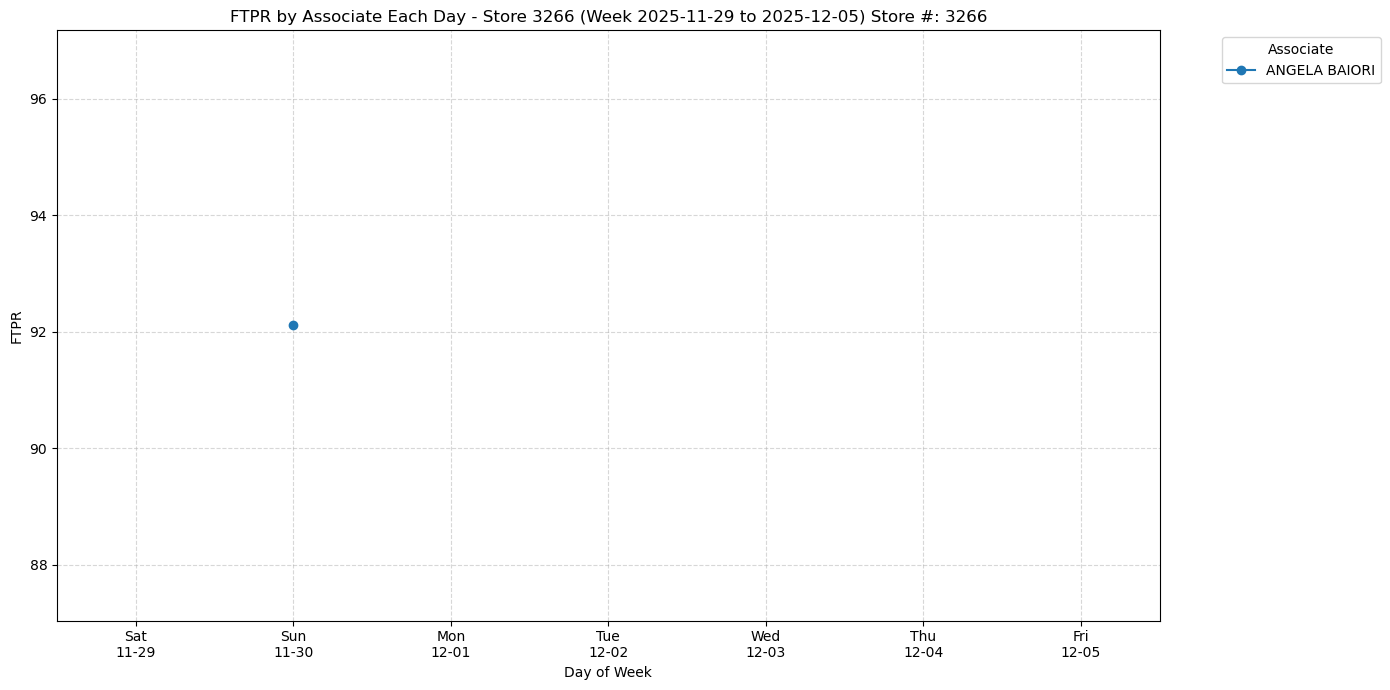

        Store #      Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
119404     3266  ANGELA BAIORI       2025-11-30 92.11        228.00      210.00      44.40        4.84             211.00                 4      0.00            15                          1                            0                        0.00                    1.00                     0    

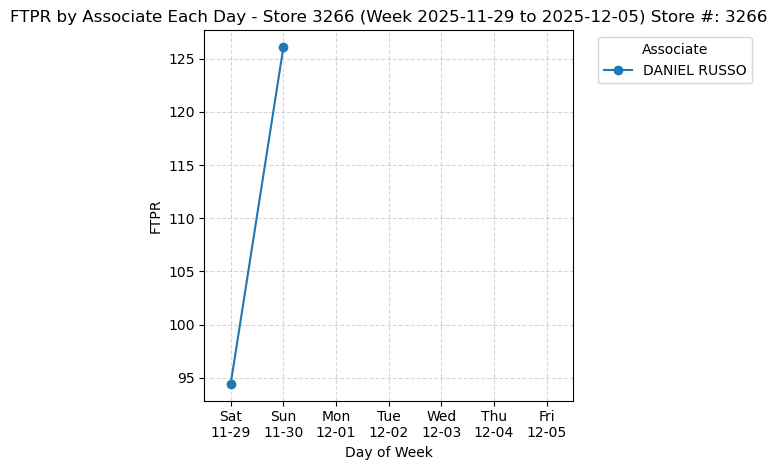

        Store #     Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120046     3266  DANIEL RUSSO       2025-11-29  94.44        108.00      102.00      50.20        2.21             102.00                 9      0.00             1                          0                            0                        0.00                    0.00                     0    

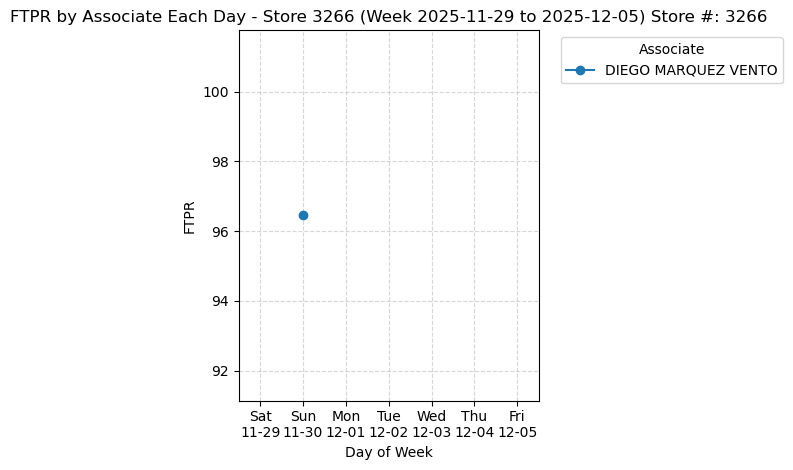

        Store #            Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
119408     3266  DIEGO MARQUEZ VENTO       2025-11-30 96.45        282.00      272.00      58.10        4.80             272.00                 7      0.00             8                          0                            0                        0.00                    0.00              

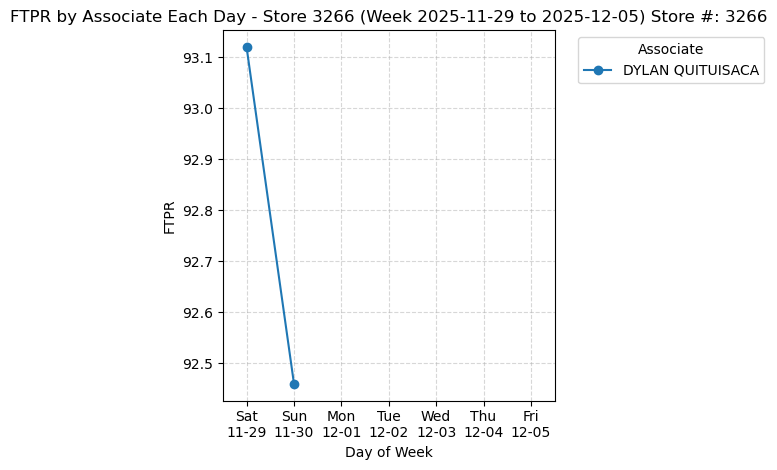

        Store #         Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120049     3266  DYLAN QUITUISACA       2025-11-29 93.12        276.00      257.00      61.10        4.25             257.00                 3      0.00            14                          0                            0                        0.00                    0.00                    

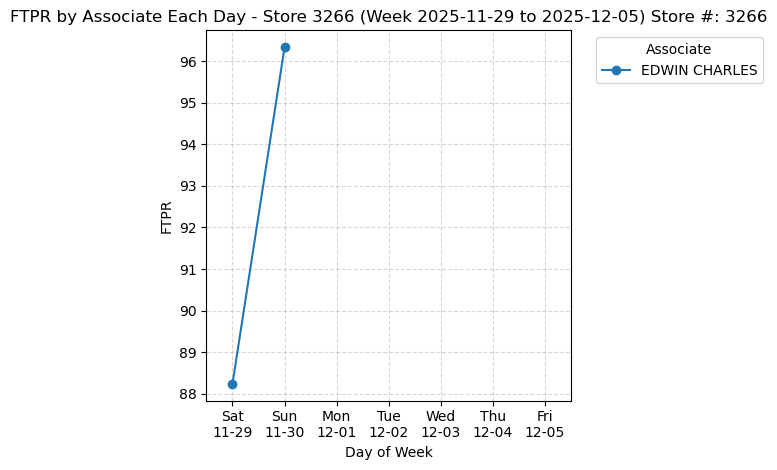

        Store #      Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120050     3266  EDWIN CHARLES       2025-11-29 88.24         34.00       30.00      76.80        0.44              30.00                 4      0.00             0                          0                            0                        0.00                    0.00                     0    

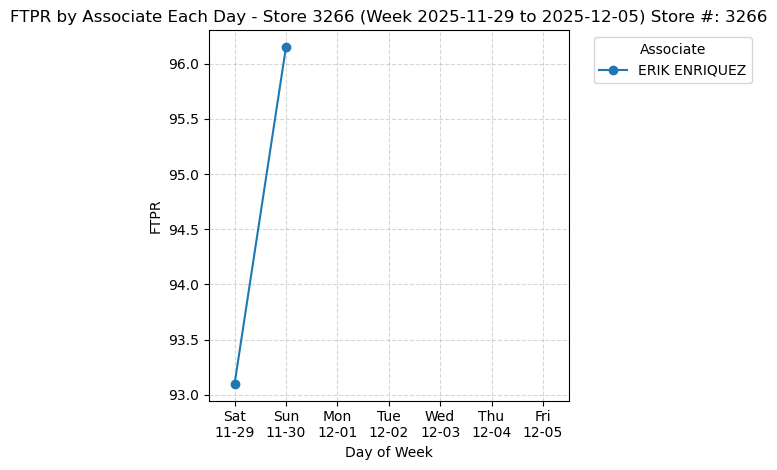

        Store #      Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120051     3266  ERIK ENRIQUEZ       2025-11-29 93.10         87.00       81.00      55.10        1.49              81.00                 1      0.00             5                          0                            0                        0.00                    0.00                     0    

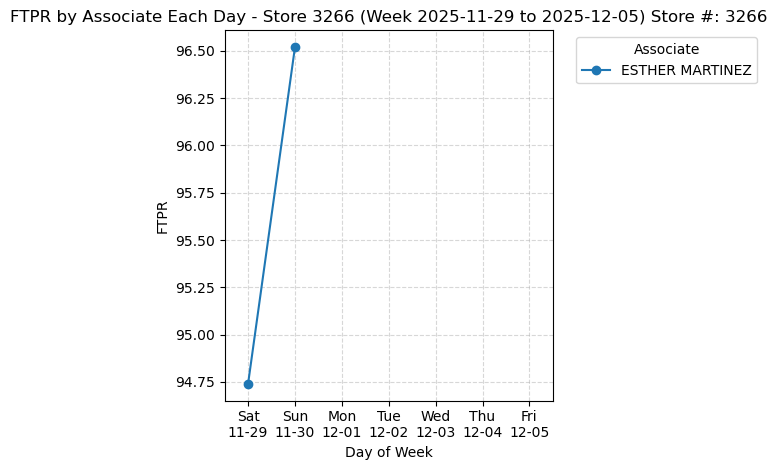

        Store #        Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120052     3266  ESTHER MARTINEZ       2025-11-29 94.74        171.00      162.00      40.10        4.22             162.00                 7      0.00             4                          3                            0                        0.00                    3.00                     0

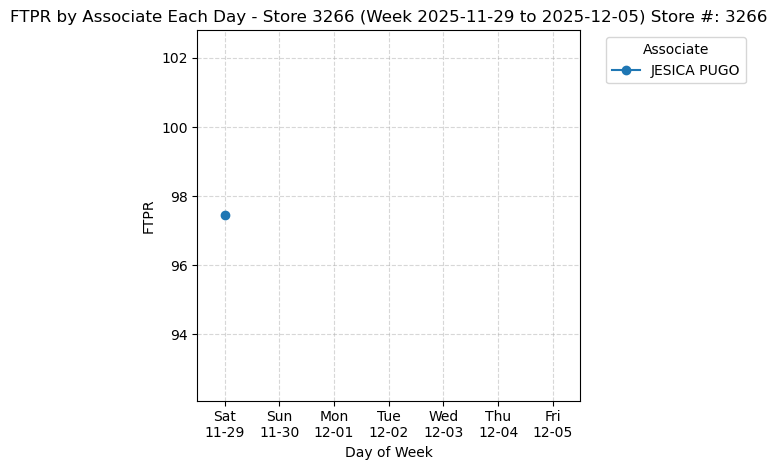

        Store #    Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120054     3266  JESICA PUGO       2025-11-29 97.44        156.00      152.00      40.50        3.90             153.00                 5      0.00             4                         10                            0                        0.00                   10.00                     0        

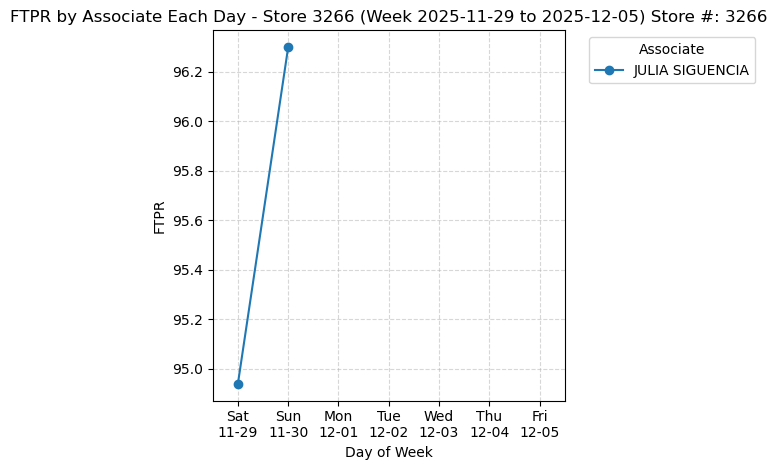

        Store #        Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120055     3266  JULIA SIGUENCIA       2025-11-29 94.94        158.00      150.00      38.70        4.17             157.00                 4      0.00             8                          1                            0                        0.00                    1.00                     0

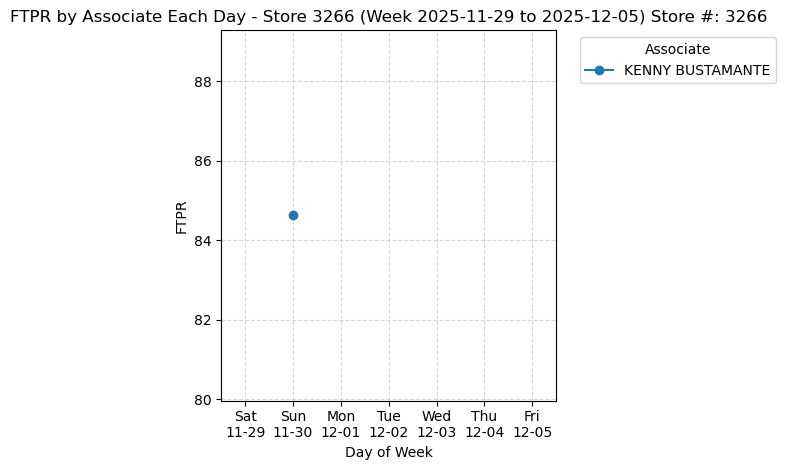

        Store #         Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
119416     3266  KENNY BUSTAMANTE       2025-11-30 84.62         26.00       22.00      51.20        0.51              23.00                 3      0.00             2                          0                            0                        0.00                    0.00                    

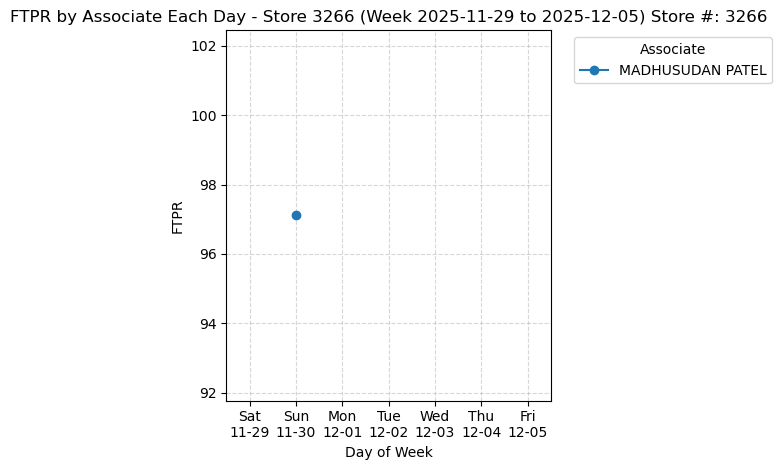

        Store #         Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
119417     3266  MADHUSUDAN PATEL       2025-11-30 97.11        173.00      168.00      33.90        5.10             168.00                 5      0.00             3                          0                            0                        0.00                    0.00                    

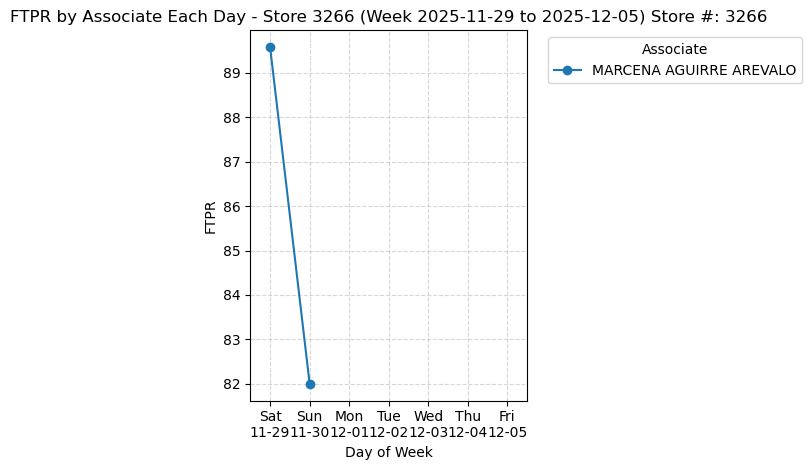

        Store #                Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120057     3266  MARCENA AGUIRRE AREVALO       2025-11-29 89.58         96.00       86.00      55.30        1.63              86.00                 4      0.00             8                          0                            0                        0.00                    0.00      

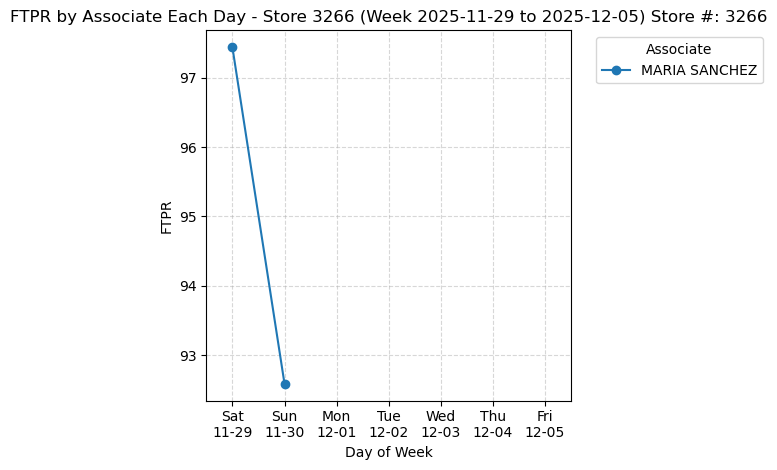

        Store #      Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120058     3266  MARIA SANCHEZ       2025-11-29 97.44        313.00      305.00      52.90        5.84             305.00                 4      0.00            13                          0                            0                        0.00                    0.00                     0    

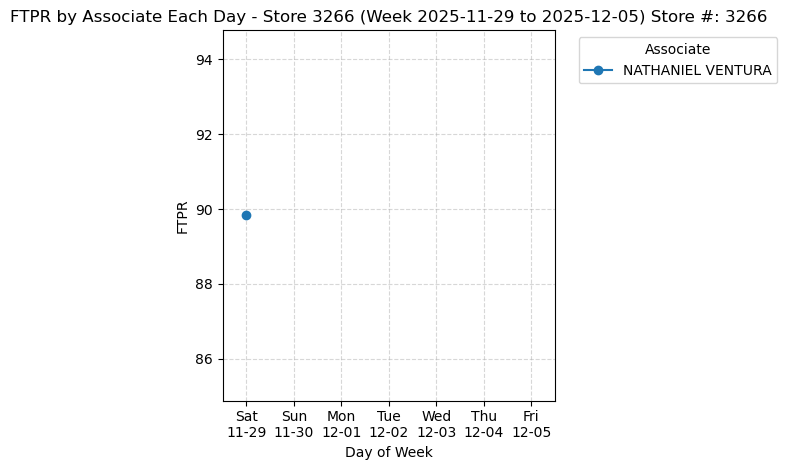

        Store #          Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120059     3266  NATHANIEL VENTURA       2025-11-29 89.83         59.00       53.00      49.60        1.49              69.00                 5      0.00             2                          1                            0                        1.00                    0.00                  

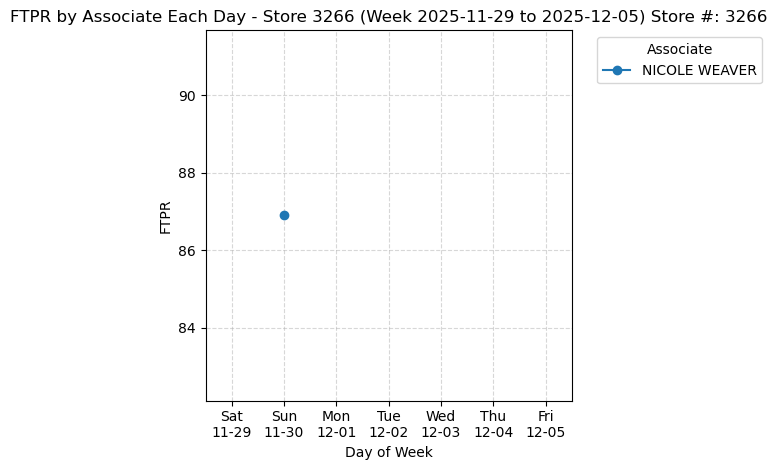

        Store #      Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
119420     3266  NICOLE WEAVER       2025-11-30 86.90         84.00       73.00      57.30        1.31              73.00                 2      0.00            11                          0                            0                        0.00                    0.00                     0    

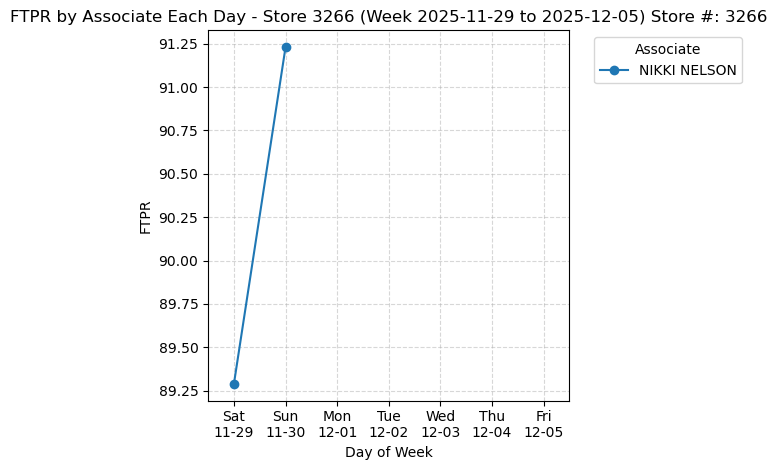

        Store #     Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120060     3266  NIKKI NELSON       2025-11-29 89.29        140.00      125.00      34.40        3.81             125.00                 6      0.00            15                          0                            0                        0.00                    0.00                     0      

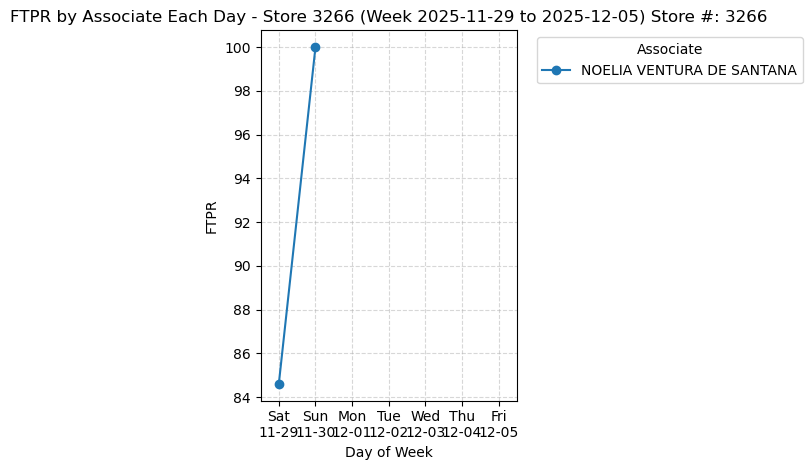

        Store #                  Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120061     3266  NOELIA VENTURA DE SANTANA       2025-11-29  84.62         65.00       55.00      39.90        1.50              55.00                 5      0.00             9                          0                            0                        0.00                    0.00

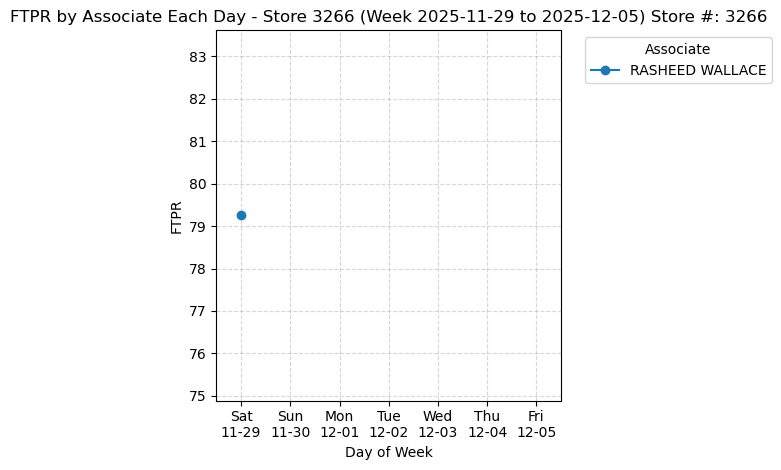

        Store #        Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120063     3266  RASHEED WALLACE       2025-11-29 79.25         53.00       42.00      37.90        1.22              42.00                 4      0.00             9                          0                            0                        0.00                    0.00                     0

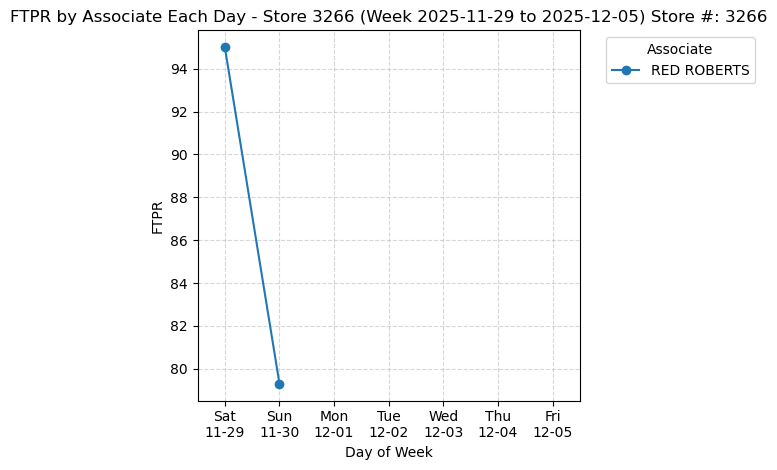

        Store #    Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120064     3266  RED ROBERTS       2025-11-29 95.00        200.00      190.00      45.30        4.24             190.00                 2      0.00            12                          7                            0                        0.00                    7.00                     0        

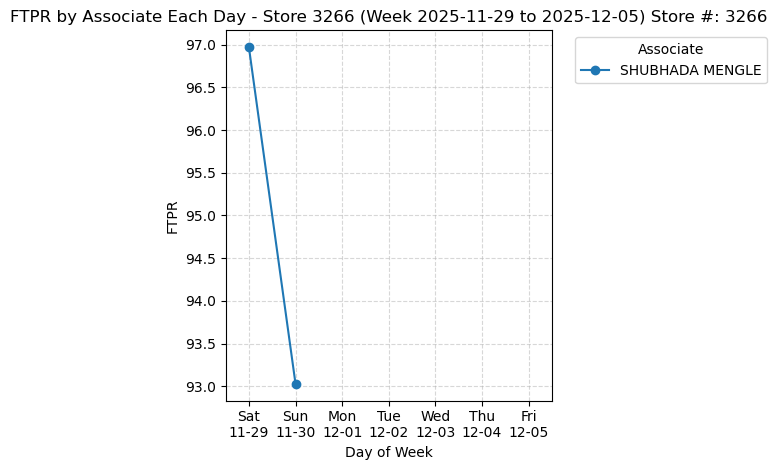

        Store #        Associate Day of Pick Date  FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120066     3266  SHUBHADA MENGLE       2025-11-29 96.97         33.00       32.00      43.60        0.78              32.00                 2      0.00             0                          0                            0                        0.00                    0.00                     0

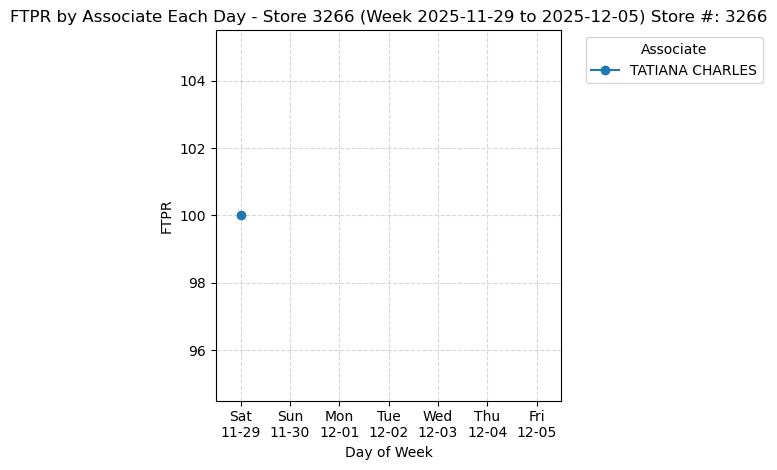

        Store #        Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
120069     3266  TATIANA CHARLES       2025-11-29 100.00         19.00       19.00      47.70        0.40              19.00                 0      0.00             2                          0                            0                        0.00                    0.00                    

In [3990]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime formats
#df['Custom Week End'] = pd.to_datetime(df['Custom Week End'])
#df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start'])
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])

# Get current week data
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
week_of_interest = df['Week'].max()

df['Custom Week Start'] = pd.to_datetime(df['Custom Week Start']).dt.date
df['Custom Week End'] = pd.to_datetime(df['Custom Week End']).dt.date
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date']).dt.date

df_selected_store = df[df['Store #'] == selected_store].copy()
if selected_store == 3266:
        df_selected_store = df_selected_store[df_selected_store['Associate'].isin(associate_list_3266)]
# Step 2: Filter for data in the current WTD week
# Assumes df contains 'Custom Week Start', 'Custom Week End', 'Day of Pick Date'
df_cw = df_selected_store[
    (df_selected_store['Custom Week Start'].astype(str) <= today) &
    (df_selected_store['Custom Week End'].astype(str) >= today) &
    (df_selected_store['Day of Pick Date'].astype(str) <= today)  # ensure we only use data up to today
].copy()

#df_wtd = df.loc[df['Week'] == week_of_interest, :]
if df_cw.empty:
    print("No data available for the current week-to-date (WTD).")
else:

    #df_cw = df_selected_store[df_selected_store['Week'] == week_of_interest]
    df_cw = df_cw.sort_values(['Associate', 'Day of Pick Date'])

    # Set full week for consistent x-axis
    #week_start = df_cw['Day of Pick Date'].min().normalize()
    week_start = df_cw['Day of Pick Date'].min()
    week_dates = pd.date_range(start=week_start, periods=7, freq='D')

    # Plot
    plt.figure(figsize=(14, 7))
    for associate, group in df_cw.groupby('Associate'):
        plt.plot(group['Day of Pick Date'], group['FTPR'], marker='o', label=associate)

        plt.title(f'FTPR by Associate Each Day - Store {selected_store} (Week {week_of_interest}) Store #: {selected_store}')
        plt.xlabel('Day of Week')
        plt.ylabel('FTPR')
        plt.xticks(week_dates, [d.strftime('%a\n%m-%d') for d in week_dates])  # e.g., Mon\n05-13
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.xticks(week_dates, [d.strftime('%a\n%m-%d') for d in week_dates])
        # Add timedelta padding to the min and max
        left_pad = pd.Timedelta(days=0.5)
        right_pad = pd.Timedelta(days=0.5)

        plt.xlim(week_dates.min() - left_pad, week_dates.max() + right_pad)
        plt.legend(title='Associate', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        print(f'{df_cw.loc[df_cw['Associate'] == associate]}')


In [3991]:
run_test_models = False

<h1>disregard the models below for now as of 4/18/2025</h1>

<h2>Using PyTorch (mps) to make a model that predicts FTPR, Pick Rate, Picked As Req Qty</h2>

In [3992]:
if run_test_models:
    # Load and preprocess data
    # Assuming 'df' is the provided DataFrame
    #df = df.copy()
    features = ['Pick Hours', 'Qty Req to Pick', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate', 'Picked As Req Qty']

    X = df[features].values
    y = df[targets].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the neural network
    class MultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(MultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 64)
            self.fc2 = nn.Linear(64, 128)
            self.fc3 = nn.Linear(128, output_dim)
            self.relu = nn.ReLU()
        
        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Initialize the model, loss function, and optimizer
    input_dim = len(features)
    output_dim = len(targets)
    model = MultiOutputRegression(input_dim, output_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor)
        y_pred_test = model(X_test_tensor)

        train_mse = mean_squared_error(y_train, y_pred_train.numpy())
        test_mse = mean_squared_error(y_test, y_pred_test.numpy())

        train_r2 = r2_score(y_train, y_pred_train.numpy())
        test_r2 = r2_score(y_test, y_pred_test.numpy())

    print("Training Metrics:")
    print(f"MSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print("Testing Metrics:")
    print(f"MSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")


In [3993]:
if run_test_models:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    start_time = time.time()
    # Define the model architecture with dropout for regularization
    class EnhancedMultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(EnhancedMultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)
            self.fc2 = nn.Linear(128, 256)
            self.fc3 = nn.Linear(256, 128)
            self.fc4 = nn.Linear(128, output_dim)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.2)

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.dropout(self.relu(self.fc2(x)))
            x = self.relu(self.fc3(x))
            x = self.fc4(x)
            return x

    # Assume df is your dataframe and contains the necessary columns
    # Features and targets
    features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
                'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate']

    X = df[features].values
    y = df[targets].values

    # Split data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features and targets
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.transform(y_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader for mini-batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, Loss Function, Optimizer
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    model = EnhancedMultiOutputRegression(input_dim, output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Training the model
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

    # Evaluating the model
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).numpy()
        y_pred_test = model(X_test_tensor).numpy()

    # Reverse scaling to compute metrics
    y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
    y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

    y_train_rescaled = target_scaler.inverse_transform(y_train)
    y_test_rescaled = target_scaler.inverse_transform(y_test)

    train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
    train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

    test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
    test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

    end_time = time.time()
    # Print metrics
    print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
    print(f'Total time: {end_time - start_time}')


In [3994]:
if run_test_models:
    # Check device
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    device = 'cpu'
    print(f"Using device: {device}")
    #device = 'cpu'
    # Define the model architecture with dropout for regularization
    class EnhancedMultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(EnhancedMultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)        # First hidden layer
            self.fc2 = nn.Linear(128, 256)              # Second hidden layer
            self.fc3 = nn.Linear(256, 128)              # Third hidden layer
            self.fc4 = nn.Linear(128, 64)               # Fourth hidden layer (new)
            self.fc5 = nn.Linear(64, output_dim)        # Output layer
            self.relu = nn.ReLU()                       # ReLU activation
            self.dropout = nn.Dropout(0.3)              # Dropout for regularization

        def forward(self, x):
            x = self.relu(self.fc1(x))                  # Pass through first layer
            x = self.dropout(self.relu(self.fc2(x)))    # Pass through second layer
            x = self.relu(self.fc3(x))                  # Pass through third layer
            x = self.relu(self.fc4(x))                  # Pass through fourth layer (new)
            x = self.fc5(x)                             # Output layer
            return x

    # Features and target columns
    features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
                'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate']

    # Prepare data
    X = df[features].values
    y = df[targets].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features and targets
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.transform(y_test)

    # Convert data to PyTorch tensors and move to the specified device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Create DataLoader for mini-batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, Loss Function, Optimizer, and Scheduler
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    model = EnhancedMultiOutputRegression(input_dim, output_dim).to(device)  # Move model to device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

    # Training the model with validation loss and early stopping
    num_epochs = 100
    patience, early_stop_counter = 10, 0  # Early stopping patience
    best_val_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()
        val_loss /= len(test_loader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered")
                break

    # Load the best model for evaluation
    model.load_state_dict(torch.load('best_model.pt', weights_only=True))
    model.eval()

    # Evaluate on training and testing sets
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).cpu().numpy()
        y_pred_test = model(X_test_tensor).cpu().numpy()

    # Reverse scaling to compute metrics
    y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
    y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

    y_train_rescaled = target_scaler.inverse_transform(y_train)
    y_test_rescaled = target_scaler.inverse_transform(y_test)

    train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
    train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

    test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
    test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

    end_time = time.time()

    # Print metrics
    print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
    print(f"Total time with {device}: {end_time - start_time:.2f} seconds")


In [3995]:
if run_test_models:
    # Check device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define the model architecture with dropout for regularization
    class EnhancedMultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(EnhancedMultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)        # First hidden layer
            self.fc2 = nn.Linear(128, 256)              # Second hidden layer
            self.fc3 = nn.Linear(256, 128)              # Third hidden layer
            self.fc4 = nn.Linear(128, 64)               # Fourth hidden layer (new)
            self.fc5 = nn.Linear(64, output_dim)        # Output layer
            self.relu = nn.ReLU()                       # ReLU activation
            self.dropout = nn.Dropout(0.3)              # Dropout for regularization

        def forward(self, x):
            x = self.relu(self.fc1(x))                  # Pass through first layer
            x = self.dropout(self.relu(self.fc2(x)))    # Pass through second layer
            x = self.relu(self.fc3(x))                  # Pass through third layer
            x = self.relu(self.fc4(x))                  # Pass through fourth layer (new)
            x = self.fc5(x)                             # Output layer
            return x

    # Features and target columns
    features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
                'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate']

    # Prepare data
    X = df[features].values
    y = df[targets].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features and targets
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.transform(y_test)

    # Convert data to PyTorch tensors and move to the specified device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Create DataLoader for mini-batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, Loss Function, Optimizer, and Scheduler
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    model = EnhancedMultiOutputRegression(input_dim, output_dim).to(device)  # Move model to device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

    # Training the model with validation loss and early stopping
    num_epochs = 100
    patience, early_stop_counter = 10, 0  # Early stopping patience
    best_val_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()
        val_loss /= len(test_loader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered")
                break

    # Load the best model for evaluation
    model.load_state_dict(torch.load('best_model.pt', weights_only=True))
    model.eval()

    # Evaluate on training and testing sets
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).cpu().numpy()
        y_pred_test = model(X_test_tensor).cpu().numpy()

    # Reverse scaling to compute metrics
    y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
    y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

    y_train_rescaled = target_scaler.inverse_transform(y_train)
    y_test_rescaled = target_scaler.inverse_transform(y_test)

    train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
    train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

    test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
    test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

    end_time = time.time()

    # Print metrics
    print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
    print(f"Total time with {device}: {end_time - start_time:.2f} seconds")


<h2>Attempt to make PyTorch model better</h2>

In [3996]:
if run_test_models:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    import time

    # Define Models with More Complexity
    class EnhancedModel(nn.Module):
        def __init__(self, input_size):
            super(EnhancedModel, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        
        def forward(self, x):
            return self.model(x)

    # Data Preparation (include interaction features or domain-specific knowledge)
    df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
    df['Total Exceptions'] = (
        df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
        df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
    )

    X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 'Nil Pick Qty',
            'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty',
            'Exception Nil Pick Qty', 'Pick Hours per Qty Req', 'Total Exceptions']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training Function with Learning Rate Scheduling
    def train_model_with_scheduler(model, optimizer, scheduler, criterion, X_train, y_train, X_test, y_test, epochs=500):
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(torch.tensor(X_train, dtype=torch.float32))
            loss = criterion(outputs.flatten(), torch.tensor(y_train.values, dtype=torch.float32))
            loss.backward()
            optimizer.step()
            scheduler.step(loss)  # Adjust learning rate based on validation loss
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(torch.tensor(X_test, dtype=torch.float32)).flatten().numpy()
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
        return mse, r2, predictions

    # Train and Evaluate Models
    start_time = time.time()
    input_size = X_train_scaled.shape[1]

    # FTPR Model
    ftpr_model = EnhancedModel(input_size)
    optimizer_ftpr = optim.Adam(ftpr_model.parameters(), lr=0.01)
    scheduler_ftpr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ftpr, patience=10, factor=0.5, verbose=True)
    criterion = nn.MSELoss()
    ftpr_mse, ftpr_r2, ftpr_preds = train_model_with_scheduler(ftpr_model, optimizer_ftpr, scheduler_ftpr, criterion, X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr)

    # Pick Rate Model
    pick_rate_model = EnhancedModel(input_size)
    optimizer_pick_rate = optim.Adam(pick_rate_model.parameters(), lr=0.01)
    scheduler_pick_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pick_rate, patience=10, factor=0.5, verbose=True)
    pick_rate_mse, pick_rate_r2, pick_rate_preds = train_model_with_scheduler(pick_rate_model, optimizer_pick_rate, scheduler_pick_rate, criterion, X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate)

    # Picked As Req Qty Model
    picked_as_req_qty_model = EnhancedModel(input_size)
    optimizer_picked_as_req_qty = optim.Adam(picked_as_req_qty_model.parameters(), lr=0.01)
    scheduler_picked_as_req_qty = optim.lr_scheduler.ReduceLROnPlateau(optimizer_picked_as_req_qty, patience=10, factor=0.5, verbose=True)
    picked_as_req_qty_mse, picked_as_req_qty_r2, picked_as_req_qty_preds = train_model_with_scheduler(
        picked_as_req_qty_model, optimizer_picked_as_req_qty, scheduler_picked_as_req_qty, criterion, X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty
    )

    end_time = time.time()

    # Results
    print(f"FTPR Prediction Metrics:\nMSE: {ftpr_mse:.4f}, R2 Score: {ftpr_r2:.4f}")
    print(f"Pick Rate Prediction Metrics:\nMSE: {pick_rate_mse:.4f}, R2 Score: {pick_rate_r2:.4f}")
    print(f"Picked As Req Qty Prediction Metrics:\nMSE: {picked_as_req_qty_mse:.4f}, R2 Score: {picked_as_req_qty_r2:.4f}")
    print(f"Total time: {end_time - start_time:.2f} seconds")


In [3997]:
if run_test_models:
    # Feature importance using Random Forest for FTPR
    from sklearn.ensemble import RandomForestRegressor

    # Train a Random Forest model on FTPR to find important features
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train_scaled, y_train_ftpr)
    importances = rf.feature_importances_

    # Display feature importance
    feature_importance = sorted(zip(importances, X.columns), reverse=True)
    print("Feature Importance for FTPR:")
    for importance, feature in feature_importance:
        print(f"{feature}: {importance:.4f}")

    # Select top features based on importance
    top_features = [feature for importance, feature in feature_importance if importance > 0.05]
    X_train_ftpr = X_train_scaled[:, [X.columns.get_loc(f) for f in top_features]]
    X_test_ftpr = X_test_scaled[:, [X.columns.get_loc(f) for f in top_features]]

    # Use only these features in the FTPR model
    ftpr_model = EnhancedModel(len(top_features))


In [3998]:
if run_test_models:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    import time

    # Define Models with More Complexity
    class EnhancedModel(nn.Module):
        def __init__(self, input_size):
            super(EnhancedModel, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        
        def forward(self, x):
            return self.model(x)

    # Data Preparation based on Feature Importance
    df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
    df['Total Exceptions'] = (
        df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
        df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
    )

    # Selecting features based on importance
    X = df[['Picked As Req Qty', 'Pick Hours per Qty Req', 'Nil Pick Qty', 'Qty Req to Pick', 
            'Substitution Qty', 'Pick Hours', 'Total Exceptions']]  # Focus on important features

    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training Function with Learning Rate Scheduling
    def train_model_with_scheduler(model, optimizer, scheduler, criterion, X_train, y_train, X_test, y_test, epochs=500):
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(torch.tensor(X_train, dtype=torch.float32))
            loss = criterion(outputs.flatten(), torch.tensor(y_train.values, dtype=torch.float32))
            loss.backward()
            optimizer.step()
            scheduler.step(loss)  # Adjust learning rate based on validation loss
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(torch.tensor(X_test, dtype=torch.float32)).flatten().numpy()
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
        return mse, r2, predictions

    # Train and Evaluate Models
    start_time = time.time()
    input_size = X_train_scaled.shape[1]

    # FTPR Model
    ftpr_model = EnhancedModel(input_size)
    optimizer_ftpr = optim.Adam(ftpr_model.parameters(), lr=0.01)
    scheduler_ftpr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ftpr, patience=10, factor=0.5, verbose=True)
    criterion = nn.MSELoss()
    ftpr_mse, ftpr_r2, ftpr_preds = train_model_with_scheduler(ftpr_model, optimizer_ftpr, scheduler_ftpr, criterion, X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr)

    # Pick Rate Model
    pick_rate_model = EnhancedModel(input_size)
    optimizer_pick_rate = optim.Adam(pick_rate_model.parameters(), lr=0.01)
    scheduler_pick_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pick_rate, patience=10, factor=0.5, verbose=True)
    pick_rate_mse, pick_rate_r2, pick_rate_preds = train_model_with_scheduler(pick_rate_model, optimizer_pick_rate, scheduler_pick_rate, criterion, X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate)

    # Picked As Req Qty Model
    picked_as_req_qty_model = EnhancedModel(input_size)
    optimizer_picked_as_req_qty = optim.Adam(picked_as_req_qty_model.parameters(), lr=0.01)
    scheduler_picked_as_req_qty = optim.lr_scheduler.ReduceLROnPlateau(optimizer_picked_as_req_qty, patience=10, factor=0.5, verbose=True)
    picked_as_req_qty_mse, picked_as_req_qty_r2, picked_as_req_qty_preds = train_model_with_scheduler(
        picked_as_req_qty_model, optimizer_picked_as_req_qty, scheduler_picked_as_req_qty, criterion, X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty
    )

    end_time = time.time()

    # Results
    print(f"FTPR Prediction Metrics:\nMSE: {ftpr_mse:.4f}, R2 Score: {ftpr_r2:.4f}")
    print(f"Pick Rate Prediction Metrics:\nMSE: {pick_rate_mse:.4f}, R2 Score: {pick_rate_r2:.4f}")
    print(f"Picked As Req Qty Prediction Metrics:\nMSE: {picked_as_req_qty_mse:.4f}, R2 Score: {picked_as_req_qty_r2:.4f}")
    print(f"Total time: {end_time - start_time:.2f} seconds")

    # Feature Importance based on your provided data
    # These are the feature importance scores for FTPR as an example
    feature_importance = {
        'Picked As Req Qty': 0.2553,
        'Pick Hours per Qty Req': 0.1751,
        'Nil Pick Qty': 0.1545,
        'Qty Req to Pick': 0.1504,
        'Substitution Qty': 0.1096,
        'Pick Hours': 0.0977,
        'Exception Nil Pick Qty': 0.0210,
        'Total Exceptions': 0.0146,
        'Exception Substitution Qty': 0.0128,
        'Exception Qty Req to Pick': 0.0079,
        'Exception Picked As Req Qty': 0.0010
    }

    print("\nFeature Importance for FTPR:")
    for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{feature}: {importance:.4f}")


In [3999]:
if run_test_models:
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score
    import matplotlib.pyplot as plt
    from sklearn.ensemble import RandomForestRegressor

    # Data Preprocessing
    X = df[['Day of Pick Date', 'Qty Req to Pick', 'Pick Hours']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']

    # Convert date column to datetime format and extract day, month, year features
    df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])
    df['day_of_month'] = df['Day of Pick Date'].dt.day
    df['month'] = df['Day of Pick Date'].dt.month

    X = df[['Qty Req to Pick', 'Pick Hours', 'day_of_month', 'month']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']

    # Split data into training and testing sets
    X_train, X_test, y_ftpr_train, y_ftpr_test = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_pick_rate_train, y_pick_rate_test = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train models
    model_ftpr = RandomForestRegressor(n_estimators=100)
    model_ftpr.fit(X_train_scaled, y_ftpr_train)

    y_ftpr_pred = model_ftpr.predict(X_test_scaled)
    print("FTPR Model Evaluation:")
    print(f"MSE: {mean_squared_error(y_ftpr_test, y_ftpr_pred)}")
    print(f"R2 Score: {r2_score(y_ftpr_test, y_ftpr_pred)}")

    model_pick_rate = RandomForestRegressor(n_estimators=100)
    model_pick_rate.fit(X_train_scaled, y_pick_rate_train)

    y_pick_rate_pred = model_pick_rate.predict(X_test_scaled)
    print("Pick Rate Model Evaluation:")
    print(f"MSE: {mean_squared_error(y_pick_rate_test, y_pick_rate_pred)}")
    print(f"R2 Score: {r2_score(y_pick_rate_test, y_pick_rate_pred)}")

    # Plot predictions vs actual values
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_ftpr_test, y_ftpr_pred)
    plt.xlabel("Actual FTPR")
    plt.ylabel("Predicted FTPR")
    plt.title("FTPR Model Predictions")

    plt.subplot(1, 2, 2)
    plt.scatter(y_pick_rate_test, y_pick_rate_pred)
    plt.xlabel("Actual Pick Rate")
    plt.ylabel("Predicted Pick Rate")
    plt.title("Pick Rate Model Predictions")

    plt.tight_layout()
    plt.show()


<h2>Attempt to try different models to improve accuracy</h2>

In [4000]:
if run_test_models:
    from sklearn.model_selection import GridSearchCV

    # Define hyperparameter grids for FTPR and Pick Rate models
    ftpr_param_grid = {
        'n_estimators': [10, 50, 100, 200, 300],
        'max_depth': [None, 5, 10, 15, 20]
    }

    pick_rate_param_grid = {
        'n_estimators': [10, 50, 100, 200, 300],
        'max_depth': [None, 5, 10, 15, 20]
    }

    # Perform grid search for FTPR model
    ftpr_gs = GridSearchCV(RandomForestRegressor(), ftpr_param_grid, cv=5, n_jobs=-1)
    ftpr_gs.fit(X_train_scaled, y_ftpr_train)

    print("FTPR Model Best Parameters:", ftpr_gs.best_params_)
    print("FTPR Model Best Score:", ftpr_gs.best_score_)

    # Perform grid search for Pick Rate model
    pick_rate_gs = GridSearchCV(RandomForestRegressor(), pick_rate_param_grid, cv=5, n_jobs=-1)
    pick_rate_gs.fit(X_train_scaled, y_pick_rate_train)

    print("Pick Rate Model Best Parameters:", pick_rate_gs.best_params_)
    print("Pick Rate Model Best Score:", pick_rate_gs.best_score_)

    # Train models with best parameters and evaluate
    ftpr_best_model = ftpr_gs.best_estimator_
    pick_rate_best_model = pick_rate_gs.best_estimator_

    y_ftpr_pred = ftpr_best_model.predict(X_test_scaled)
    y_pick_rate_pred = pick_rate_best_model.predict(X_test_scaled)

    print("FTPR Model Evaluation (Best Parameters):")
    print("MSE:", mean_squared_error(y_ftpr_test, y_ftpr_pred))
    print("R2 Score:", r2_score(y_ftpr_test, y_ftpr_pred))

    print("Pick Rate Model Evaluation (Best Parameters):")
    print("MSE:", mean_squared_error(y_pick_rate_test, y_pick_rate_pred))
    print("R2 Score:", r2_score(y_pick_rate_test, y_pick_rate_pred))

compare pick times to pick rate

In [4001]:
df.head()

Store #                  Associate Day of Pick Date   FTPR  FTP Expected  FTP Actual  Pick Rate  Pick Hours  Picked As Req Qty  Substitution Qty  Ovrd Qty  Nil Pick Qty  Exception Qty Req to Pick  Exception Picked As Req Qty  Exception Substitution Qty  Exception Nil Pick Qty  First Pick Assgn Qty  First Disp Pick Qty  Qty Req to Pick Associate ID  Market  Month  Year  Day of Week # Day of Week Custom Week Start Custom Week End                      Week  FY Start Year  FY End Year Fiscal Year  Fiscal Week  Fiscal Month Number Fiscal Month  Handled_Exceptions OPD Start Date  Composite Score  Potential Skipped Items  Exception Rate  IsWeekend  Log Pick Rate  Log FTPR  Log FTP Actual  Log FTP Expected
85      3266            ANDREA FIGUEROA       2024-12-20  98.63        147.00      144.00      55.00        2.62             144.00                 1      0.00             2                          1                            1                        0.00                    0.00                     0                    0           147.00      a0f0grp     178     12  2024              4      Friday        2024-12-14      2024-12-20  2024-12-14 to 2024-12-20           2024         2025      FY2025           47                   11     December                   1     2024-12-20            85.01                        0            0.01          0           4.03      4.60            4.98              5.00
702     3266  NOELIA VENTURA DE SANTANA       2024-12-20  96.46        129.00      113.00      36.00        3.32             113.00                 5      0.00             8                          0                            0                        0.00                    0.00                     0                    0           129.00      n0v03hh     178     12  2024              4      Friday        2024-12-14      2024-12-20  2024-12-14 to 2024-12-20           2024         2025      FY2025           47                   11     December                   0     2024-12-20            72.32                        0            0.00          0           3.61      4.58            4.74              4.87
617     3266               MIROLLA SAID       2024-12-20  99.06        105.00      105.00      64.00        1.64             105.00                 0      0.00             0                          0                            0                        0.00                    0.00                     0                    0           105.00      m0s0q17     178     12  2024              4      Friday        2024-12-14      2024-12-20  2024-12-14 to 2024-12-20           2024         2025      FY2025           47                   11     December                   0     2024-12-20            79.99                        0            0.00          0           4.17      4.61            4.66              4.66
319     3266              ERIK ENRIQUEZ       2024-12-20 100.00          5.00        5.00      16.00        0.32               5.00                 0      0.00             0                          0                            0                        0.00                    0.00                     0                    0             5.00      e0e04sh     178     12  2024              4      Friday        2024-12-14      2024-12-20  2024-12-14 to 2024-12-20           2024         2025      FY2025           47                   11     December                   0     2024-12-20            45.83                        0            0.00          0           2.83      4.62            1.79              1.79
773     3266         SHAMIMA HAQUE MITU       2024-12-20 100.00         13.00       12.00      21.00        0.59              12.00                 0      0.00             0                          0                            0                        0.00                    0.00                     0                    0            13.00      s0m0uve     178     12  2024              4      Friday        2024-12-14      2024-12-20  20

In [4002]:
if run_test_models:
    import xgboost as xgb
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    # Data Preparation
    df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
    df['Total Exceptions'] = (
        df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
        df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
    )

    X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 'Nil Pick Qty',
            'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty',
            'Exception Nil Pick Qty', 'Pick Hours per Qty Req', 'Total Exceptions']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    # Train-Test Split
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model Training for FTPR
    ftpr_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
    ftpr_model.fit(X_train_scaled, y_train_ftpr)

    # Model Training for Pick Rate
    pick_rate_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
    pick_rate_model.fit(X_train_scaled, y_train_pick_rate)

    # Model Training for Picked As Req Qty
    picked_as_req_qty_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
    picked_as_req_qty_model.fit(X_train_scaled, y_train_picked_as_req_qty)

    # Predictions
    ftpr_preds = ftpr_model.predict(X_test_scaled)
    pick_rate_preds = pick_rate_model.predict(X_test_scaled)
    picked_as_req_qty_preds = picked_as_req_qty_model.predict(X_test_scaled)

    # Evaluation
    print("FTPR Metrics")
    print(f"MSE: {mean_squared_error(y_test_ftpr, ftpr_preds):.4f}")
    print(f"R2: {r2_score(y_test_ftpr, ftpr_preds):.4f}")

    print("\nPick Rate Metrics")
    print(f"MSE: {mean_squared_error(y_test_pick_rate, pick_rate_preds):.4f}")
    print(f"R2: {r2_score(y_test_pick_rate, pick_rate_preds):.4f}")

    print("\nPicked As Req Qty Metrics")
    print(f"MSE: {mean_squared_error(y_test_picked_as_req_qty, picked_as_req_qty_preds):.4f}")
    print(f"R2: {r2_score(y_test_picked_as_req_qty, picked_as_req_qty_preds):.4f}")


In [4003]:
if run_test_models:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score

    # ===========================================
    # Load and Preprocess Data
    # ===========================================

    # Example DataFrame (replace with actual data loading)
    # df = pd.read_csv('your_dataset.csv')

    # Convert 'Day of Pick Date' and other datetime columns to numeric features (e.g., day of the week)
    if "Day of Pick Date" in df.columns:
        df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
        df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
        df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month

    # Drop irrelevant columns
    X = df.drop(columns=[
        "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
        "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
        "Composite Score", "Associate ID"
    ])

    # Target variables
    y_ftpr = df["FTPR"]
    y_pick_rate = df["Pick Rate"]

    # Convert categorical features to numeric using one-hot encoding
    X_numeric = pd.get_dummies(X, drop_first=True)

    # Ensure all columns are numeric
    X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)

    # Split data into training and testing sets
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X_numeric, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X_numeric, y_pick_rate, test_size=0.2, random_state=42)

    # Scale numeric features for better performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ===========================================
    # Train and Evaluate Models
    # ===========================================

    # Define a function to train and evaluate models
    def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        print(f"{label} Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"R2: {r2:.4f}")
        return model

    # Train Random Forest Regressor for FTPR
    ftpr_model = RandomForestRegressor(n_estimators=500, random_state=42)
    ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

    # Train Random Forest Regressor for Pick Rate
    pick_rate_model = RandomForestRegressor(n_estimators=500, random_state=42)
    pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

    # ===========================================
    # Notes
    # ===========================================
    # - Handled datetime columns by extracting numeric features.
    # - Dropped irrelevant columns to avoid data leakage.
    # - Converted categorical features to numeric using `pd.get_dummies`.
    # - Ensured all columns are numeric with `pd.to_numeric` and replaced NaN values with 0.
    # - Scaled features using `StandardScaler` for improved model performance.


In [4004]:
if run_test_models:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Define constants
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    N_ESTIMATORS = 500

    def load_data(file_path):
        try:
            df = pd.read_csv(file_path)
            return df
        except FileNotFoundError:
            print("File not found.")
            return None

    def preprocess_data(df):
        if "Day of Pick Date" in df.columns:
            df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
            df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
            df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month
        
        X = df.drop(columns=[
            "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
            "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
            "Composite Score", "Associate ID"
        ])
        
        y_ftpr = df["FTPR"]
        y_pick_rate = df["Pick Rate"]
        
        X_numeric = pd.get_dummies(X, drop_first=True)
        X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)
        
        return X_numeric, y_ftpr, y_pick_rate

    def split_data(X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        return X_train, X_test, y_train, y_test

    def scale_features(X_train, X_test):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        print(f"{label} Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"R2: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        
        return model

    # Preprocess data
    X, y_ftpr, y_pick_rate = preprocess_data(df)

    # Split data
    X_train, X_test, y_train_ftpr, y_test_ftpr = split_data(X, y_ftpr)
    _, _, y_train_pick_rate, y_test_pick_rate = split_data(X, y_pick_rate)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    ftpr_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
    ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

    pick_rate_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
    pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

In [4005]:
if run_test_models:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Define constants
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    N_ESTIMATORS = 500

    def load_data(file_path):
        try:
            df = pd.read_csv(file_path)
            return df
        except FileNotFoundError:
            print("File not found.")
            return None

    def preprocess_data(df):
        if "Day of Pick Date" in df.columns:
            df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
            df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
            df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month
        
        X = df.drop(columns=[
            "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
            "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
            "Composite Score", "Associate ID"
        ])
        
        y_ftpr = df["FTPR"]
        y_pick_rate = df["Pick Rate"]
        
        X_numeric = pd.get_dummies(X, drop_first=True)
        X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)
        
        return X_numeric, y_ftpr, y_pick_rate

    def split_data(X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        return X_train, X_test, y_train, y_test

    def scale_features(X_train, X_test):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        print(f"{label} Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"R2: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        
        return model


    # Preprocess data
    X, y_ftpr, y_pick_rate = preprocess_data(df)

    # Split data
    X_train, X_test, y_train_ftpr, y_test_ftpr = split_data(X, y_ftpr)
    _, _, y_train_pick_rate, y_test_pick_rate = split_data(X, y_pick_rate)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    ftpr_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE, n_jobs=-1)
    ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

    pick_rate_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE, n_jobs=-1)
    pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

<h1>Put dataframe df into a single .csv</h1>

In [4006]:
df.drop_duplicates(inplace=True)
combine_data_to_csv()

Directory 'Data/Combined/' already exists.
total rows: 72302


In [4007]:
print(f'Platform: {platform.platform()}')
print(f'Platform processor: {platform.processor()}')
print(cpu_info())
notebook_end_time = time.time()
print(f"Total time taken: {notebook_end_time - notebook_start_time:.2f} seconds. Last run date: {datetime.now().date() } at {datetime.now().time()}")

Platform: macOS-26.2-arm64-arm-64bit
Platform processor: arm
Apple M4 Max
Total time taken: 150.84 seconds. Last run date: 2025-12-01 at 16:56:27.468279
